# FoDS Project: Covid 

## Preparation

### Structure
1. Environment
2. Data import

### 1. Environment
1. python == 3.11.8 
2. matplotlib=3.8.3
3. numpy=1.26.0
4. pandas=2.1.1
5. scipy=1.12.0
6. seaborn=0.13.2
7. sklearn=1.4.2

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from scipy.stats import boxcox
from sklearn.impute import KNNImputer
from scipy.interpolate import interp1d
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

### 2. Data import

In [2]:
data = pd.read_csv("../data/OWID-covid-data-28Feb2023.csv")
df = data

## 2 Getting an overview

### Structure
1. Basic overview
2. Datatypes
3. Locations and continents

### 1. Basic overview

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260567 entries, 0 to 260566
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    260567 non-null  object 
 1   continent                                   245944 non-null  object 
 2   location                                    260567 non-null  object 
 3   date                                        260567 non-null  object 
 4   total_cases                                 246027 non-null  float64
 5   new_cases                                   245704 non-null  float64
 6   new_cases_smoothed                          244500 non-null  float64
 7   total_deaths                                226322 non-null  float64
 8   new_deaths                                  226220 non-null  float64
 9   new_deaths_smoothed                         225034 non-null  float64
 

In [4]:
print(data.describe())

        total_cases     new_cases  new_cases_smoothed  total_deaths  \
count  2.460270e+05  2.457040e+05        2.445000e+05  2.263220e+05   
mean   5.351606e+06  1.171424e+04        1.176318e+04  8.028942e+04   
std    3.286233e+07  8.174768e+04        7.947016e+04  4.087985e+05   
min    1.000000e+00  0.000000e+00        0.000000e+00  1.000000e+00   
25%    5.833500e+03  0.000000e+00        4.286000e+00  1.250000e+02   
50%    6.252100e+04  3.600000e+01        7.614300e+01  1.361000e+03   
75%    6.499290e+05  8.110000e+02        9.911430e+02  1.107200e+04   
max    6.750579e+08  4.082893e+06        3.436562e+06  6.870547e+06   

          new_deaths  new_deaths_smoothed  total_cases_per_million  \
count  226220.000000        225034.000000            244910.000000   
mean      126.193347           126.779357             74555.434011   
std       734.270598           680.642217            125337.885283   
min         0.000000             0.000000                 0.001000   
25%       

In [5]:
print(data.head())

  iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
0           NaN            

In [6]:
print(data.tail())

       iso_code continent  location        date  total_cases  new_cases  \
260562      ZWE    Africa  Zimbabwe  2023-02-23     263921.0        NaN   
260563      ZWE    Africa  Zimbabwe  2023-02-24     263921.0        NaN   
260564      ZWE    Africa  Zimbabwe  2023-02-25     263921.0        NaN   
260565      ZWE    Africa  Zimbabwe  2023-02-26     263921.0        NaN   
260566      ZWE    Africa  Zimbabwe  2023-02-27     263921.0        NaN   

        new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
260562                 NaN        5663.0         0.0                0.143   
260563                 NaN        5663.0         0.0                0.143   
260564                 NaN        5663.0         0.0                0.143   
260565                 NaN        5663.0         0.0                0.143   
260566                 NaN        5663.0         0.0                0.143   

        ...  male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
26056

In [7]:
print("Number of observations:", data.shape[0])
print("Number of columns:", data.shape[1])

Number of observations: 260567
Number of columns: 67


### 2. Datatypes

#### 2.1 All datatypes

In [8]:
#Datatypes of each variable:
print(data.dtypes)

iso_code                                    object
continent                                   object
location                                    object
date                                        object
total_cases                                float64
                                            ...   
population                                 float64
excess_mortality_cumulative_absolute       float64
excess_mortality_cumulative                float64
excess_mortality                           float64
excess_mortality_cumulative_per_million    float64
Length: 67, dtype: object


#### 2.2 Integers

In [9]:
int_data = data.select_dtypes(include=("int64")).columns
print("INTEGERS: ", int_data)

INTEGERS:  Index([], dtype='object')


It seems we do not have any integers in our data. (We have but they are just not saved as such)

#### 2.3 Floats

In [10]:
float_data = data.select_dtypes(include=("float64")).columns
print("FLOATS: ", float_data)

FLOATS:  Index(['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths',
       'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hun

#### 2.4 Objects

In [11]:
object_data = data.select_dtypes(include=("object")).columns
print("OBJECTS:", object_data)
num_data = data[float_data] 

OBJECTS: Index(['iso_code', 'continent', 'location', 'date', 'tests_units'], dtype='object')


#### 2.5 Saving numerical and categorical data in seperate data frames

In [12]:
num_data = data[float_data] 
cat_data = data[object_data]

#### 2.6 Adjusting date datatype

In [13]:
data["date"] = pd.to_datetime(data["date"])

## 3 Introductory Visualizations

### Structure
1. Cases Visualized
2. Deaths Visualized

### 1. Cases Visualized

#### 1.1 Cases per day

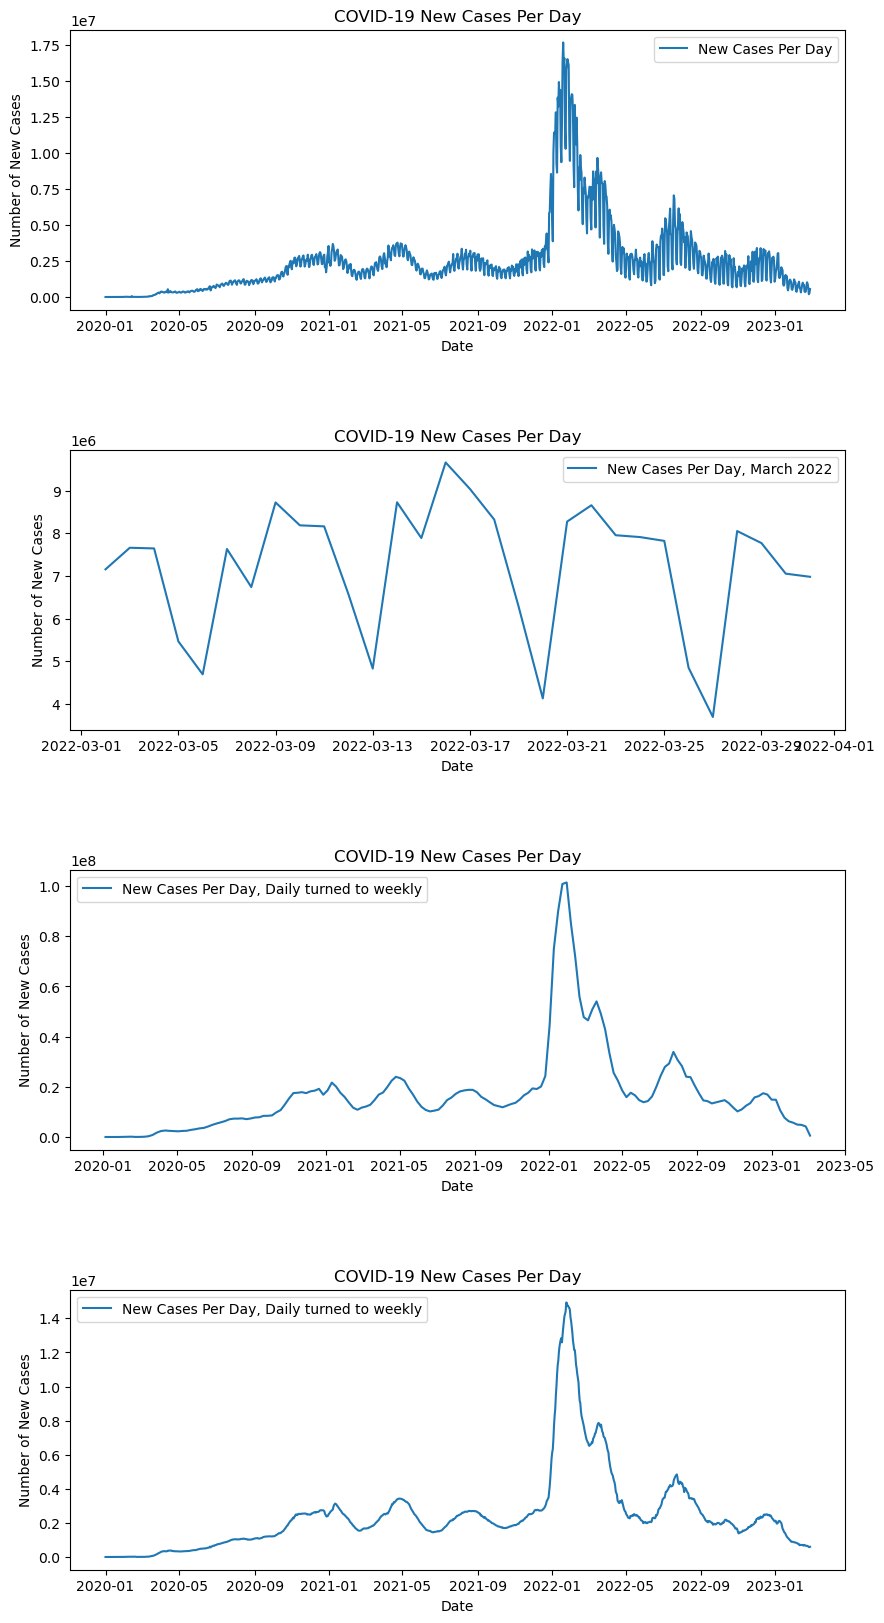

In [14]:
# Problem: Most countries did not publish covid numbers on the weekends
# Effect: This leads to an oscillating graph for daily new cases
# This can be solved with weekly new cases
# either extract data from new_daily or use the smoothed cases count
daily_cases = data.groupby('date')['new_cases'].sum()
data_march= data[(data['date']>'2022-03-01')&(data['date']<'2022-04-01')]
daily_cases_march = data_march.groupby('date')['new_cases'].sum()
daily_cases_weekly= data.groupby(pd.Grouper(key='date', freq='W')).sum()['new_cases']

# Plotting
fig, (ax1,ax2,ax3, ax4)=plt.subplots(4,1,figsize=(10,20))
ax1.plot(daily_cases, label='New Cases Per Day')
ax1.set(title='COVID-19 New Cases Per Day',
        xlabel='Date',
        ylabel='Number of New Cases'
        )
ax1.legend()
ax2.plot(daily_cases_march, label='New Cases Per Day, March 2022')
ax2.set(title='COVID-19 New Cases Per Day',
        xlabel='Date',
        ylabel='Number of New Cases'
        )
ax2.legend()
ax3.plot(daily_cases_weekly, label='New Cases Per Day, Daily turned to weekly')
ax3.set(title='COVID-19 New Cases Per Day',
        xlabel='Date',
        ylabel='Number of New Cases'
        )

ax3.legend()
ax4.plot(data.groupby('date')['new_cases_smoothed'].sum(), label='New Cases Per Day, Daily turned to weekly')
ax4.set(title='COVID-19 New Cases Per Day',
        xlabel='Date',
        ylabel='Number of New Cases'
        )

ax4.legend()
plt.subplots_adjust(hspace=0.5)
#plt.savefig('../output/Introductory_Visualizations/Cases/newcasestotal.png')


#### 1.2 Cases over time by continent compact

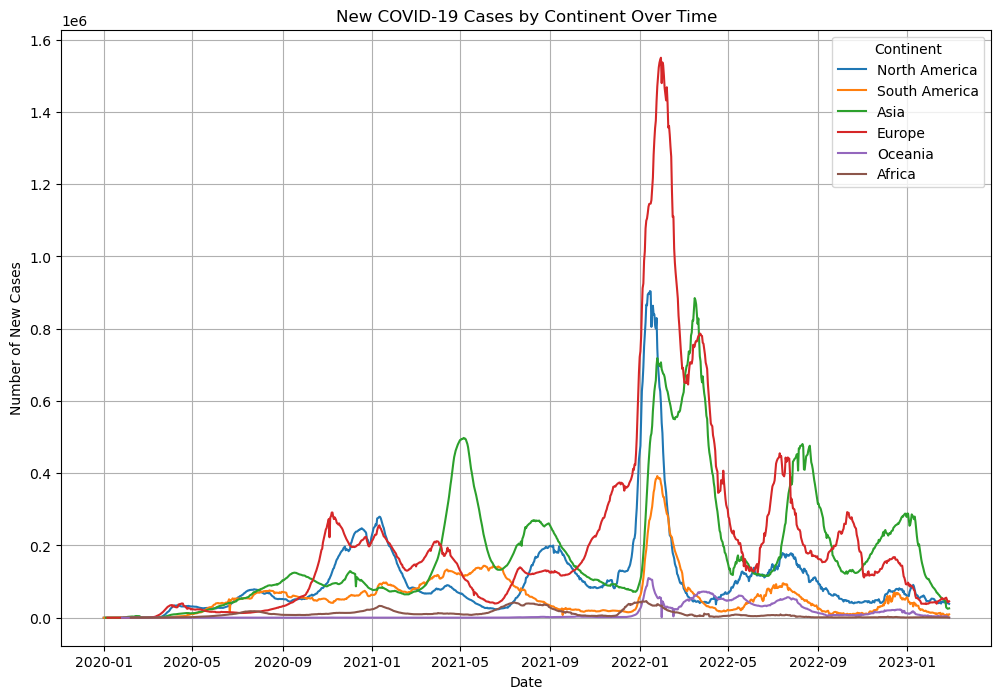

In [15]:
grouped_data = data[~(data['continent']==0)].groupby(['date', 'continent'])['new_cases_smoothed'].sum().reset_index()
plt.figure(figsize=(12, 8))
sns.lineplot(x='date', y='new_cases_smoothed', hue='continent', data=grouped_data)
plt.title('New COVID-19 Cases by Continent Over Time')
plt.xlabel('Date')
plt.ylabel('Number of New Cases')
plt.legend(title='Continent')
plt.grid(True)  
#plt.savefig('../output/Introductory_Visualizations/Cases/newcasesbycontinent')

#### 1.3 Cases over time by continent in subplots

Text(0.5, 0.98, 'New Cases by Continent')

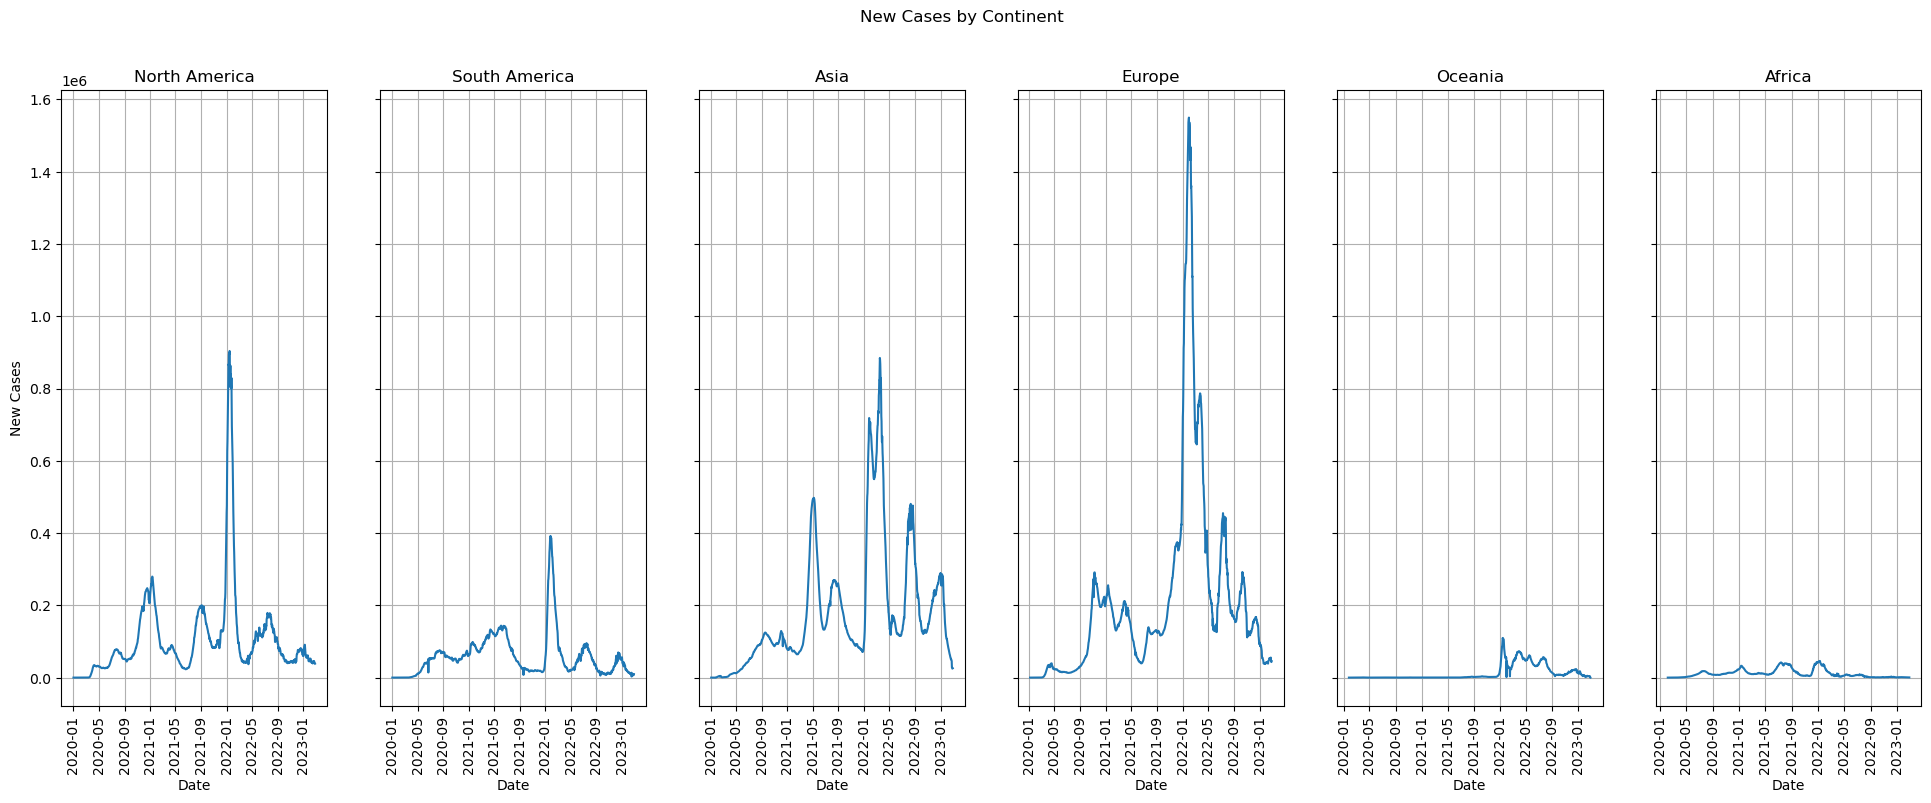

In [16]:
grouped_data = data[~(data['continent']==0)].groupby(['continent','date'])['new_cases_smoothed'].sum().reset_index()
continents_of_interest=['North America','South America','Asia','Europe','Oceania','Africa']
fig, axs = plt.subplots(1,6,figsize=(24,8), sharey=True)
for i,continent in enumerate(continents_of_interest):
        sns.lineplot(x='date', y='new_cases_smoothed',  data=grouped_data[grouped_data['continent']==continent],ax=axs[i])
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('New Cases')
        axs[i].set_title(continent)
        axs[i].tick_params(axis='x', rotation=90)
        axs[i].grid(True)
plt.suptitle('New Cases by Continent')
#plt.savefig('../output/Introductory_Visualizations/Cases/casesbycontinentsp')


#### 1.4 Total cases vs total cases per million by continent

continent
North America    103389954.0
Asia              44687597.0
Europe            39656681.0
South America     37038230.0
Oceania           11366361.0
Africa             4063237.0
Name: total_cases, dtype: float64
continent
Europe           724428.492
Asia             619133.100
North America    586576.041
South America    507761.115
Africa           472908.013
Oceania          434204.950
Name: total_cases_per_million, dtype: float64


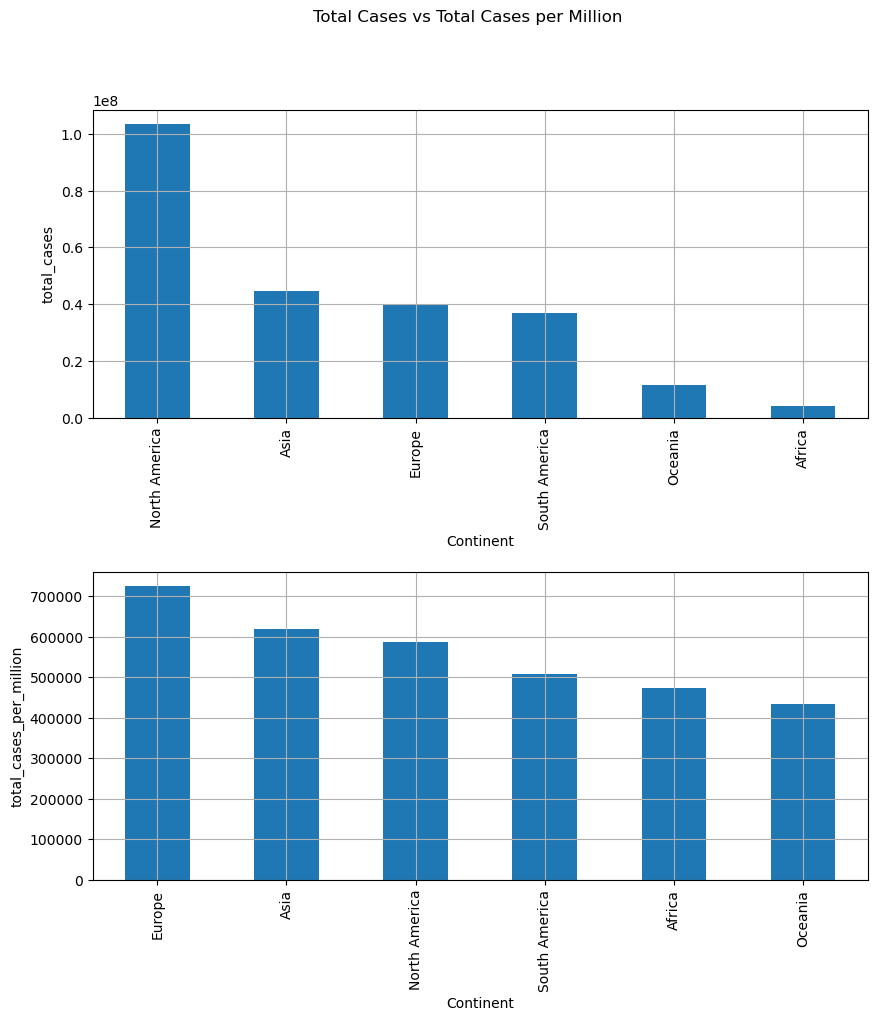

In [17]:
cases=['total_cases','total_cases_per_million']
fig, axs= plt.subplots(2,1,figsize=(10,10))
data_nozero=data[~(data['continent']==0)]
for i, variable in enumerate(cases):
        top_countries = data_nozero.groupby('continent')[variable].max().nlargest(10)
        print(top_countries)
        top_countries.plot(kind='bar', ax=axs[i],grid=True)
        axs[i].set_xlabel('Continent')
        axs[i].set_ylabel(variable)
plt.suptitle('Total Cases vs Total Cases per Million')
plt.subplots_adjust(hspace=0.5)
#plt.savefig('../output/Introductory_Visualizations/Cases/casesbycontinent.png')

#### 1.5 Total cases vs total cases per million by country

iso_code
USA    103389954.0
IND     44687597.0
FRA     39656681.0
DEU     38144033.0
BRA     37038230.0
JPN     33212438.0
KOR     30513721.0
ITA     25576852.0
GBR     24370154.0
RUS     21951059.0
Name: total_cases, dtype: float64
iso_code
CYP    724428.492
SMR    698604.927
AUT    660588.144
FRO    652484.139
SVN    626271.380
GIB    624996.175
BRN    619133.100
AND    599501.522
KOR    588888.260
SPM    586576.041
Name: total_cases_per_million, dtype: float64


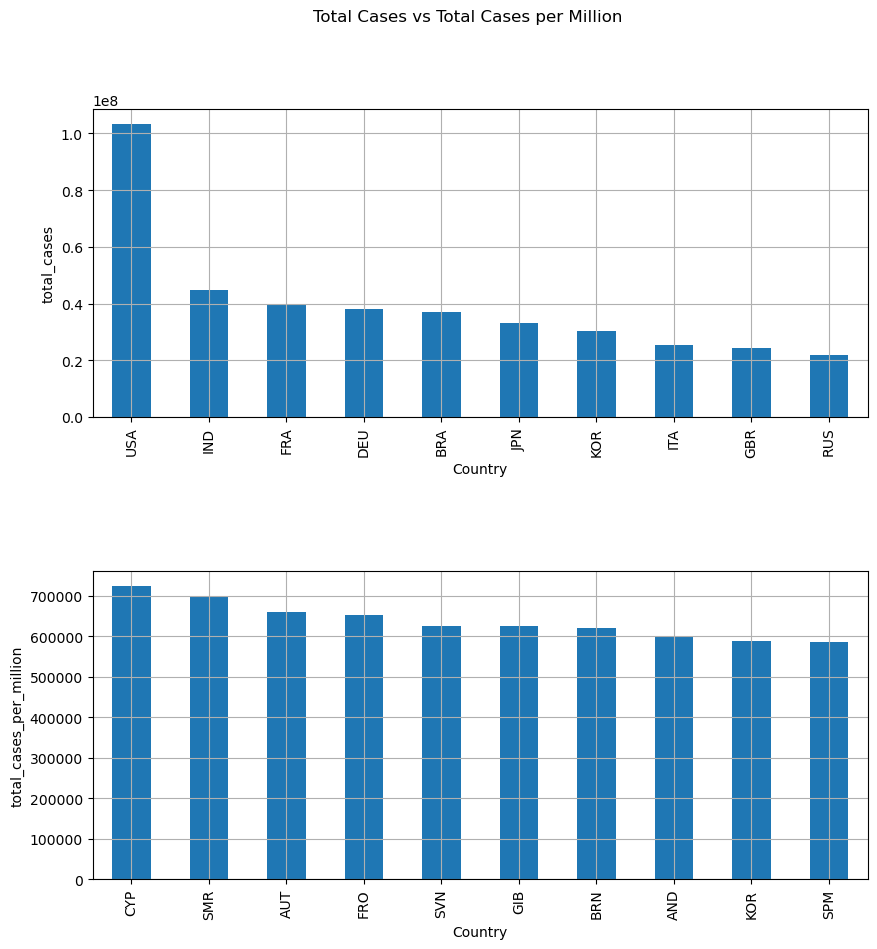

In [18]:
cases=['total_cases','total_cases_per_million']
fig, axs= plt.subplots(2,1,figsize=(10,10))
data_noowid=data[~data['iso_code'].str.startswith("OWID_")]
for i, variable in enumerate(cases):
        top_countries = data_noowid.groupby('iso_code')[variable].max().nlargest(10)
        print(top_countries)
        top_countries.plot(kind='bar', ax=axs[i],grid=True)
        axs[i].set_xlabel('Country')
        axs[i].set_ylabel(variable)
plt.suptitle('Total Cases vs Total Cases per Million')
plt.subplots_adjust(hspace=0.5)
#plt.savefig('../output/Introductory_Visualizations/Cases/casesbycountry.png')

#### 1.6 Scatter plots with variables of interest to see correlation with total cases

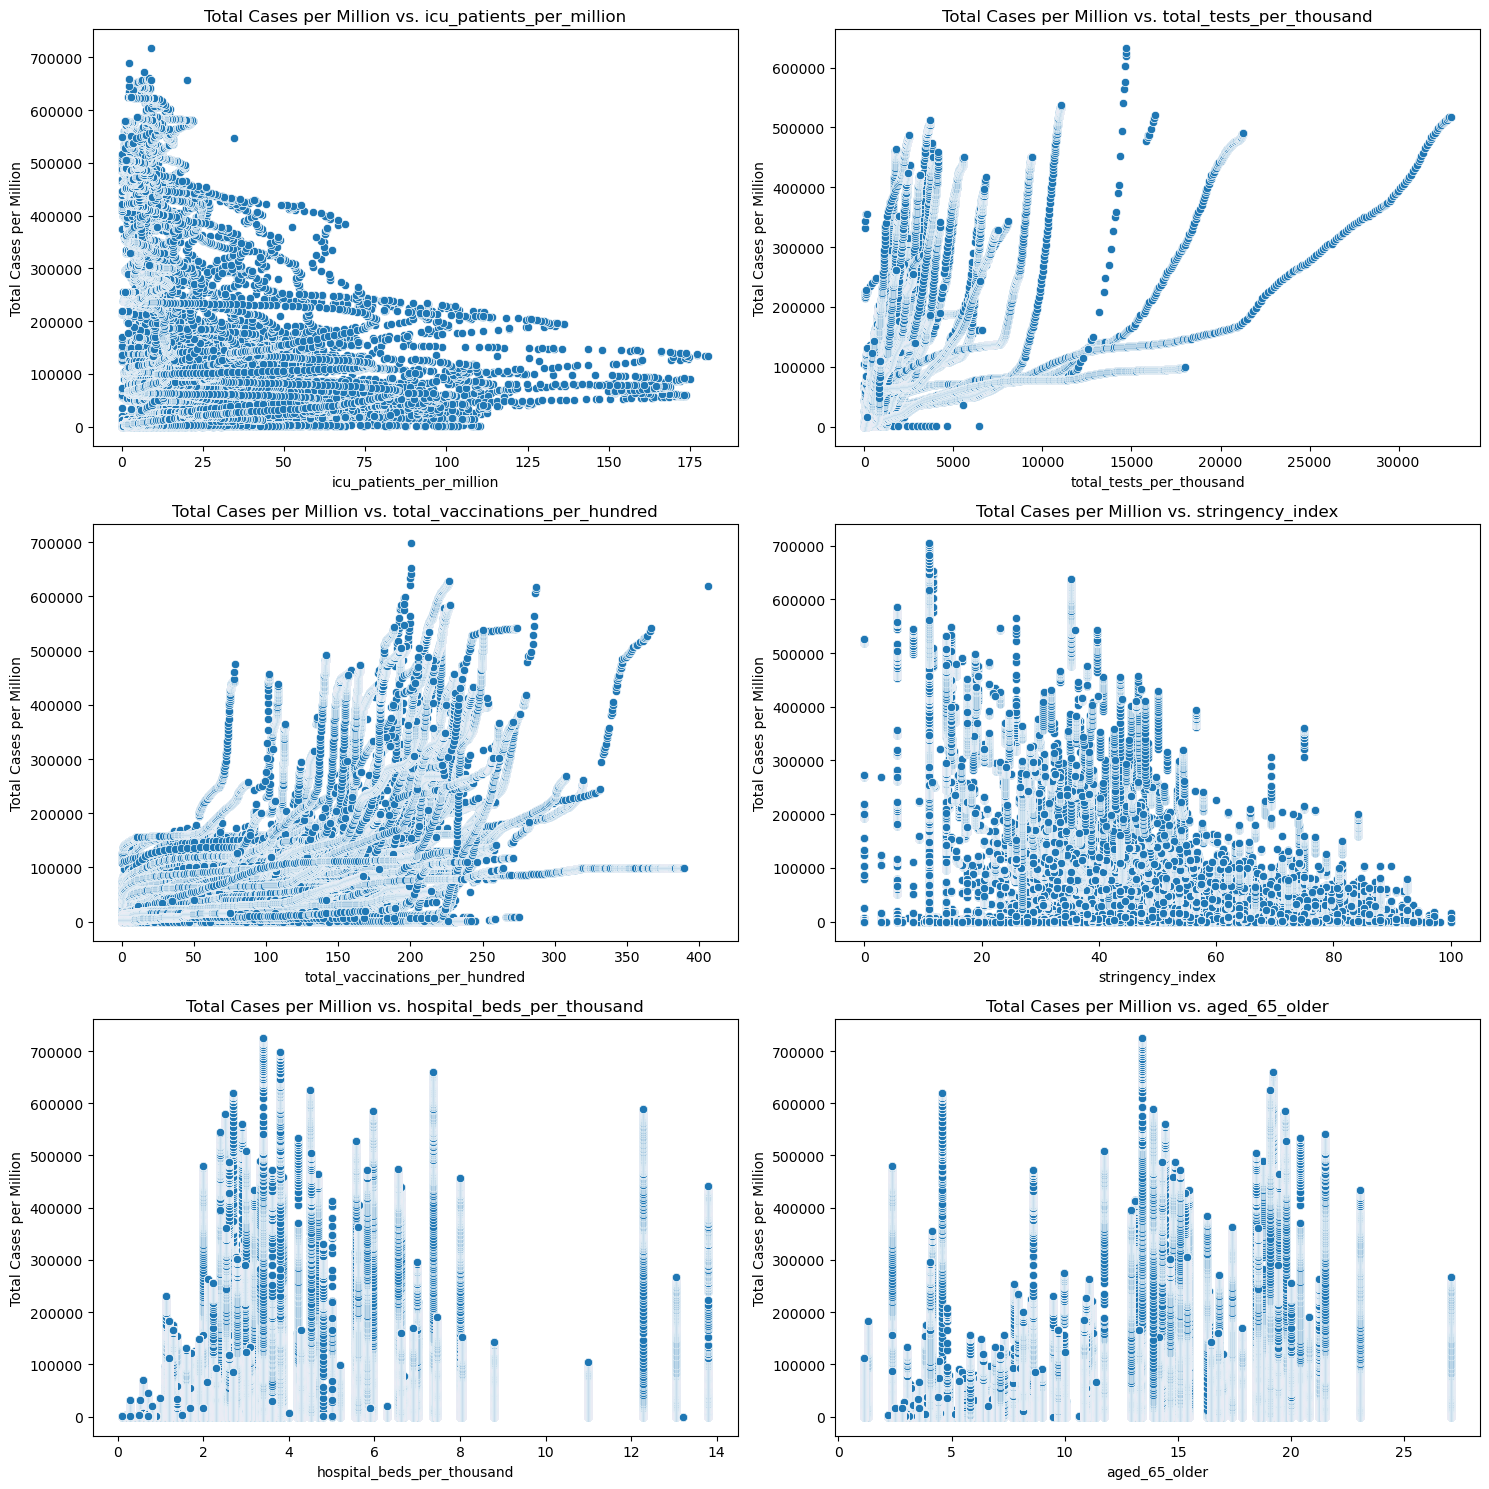

In [19]:
variables_of_interest = [
    'icu_patients_per_million', 'total_tests_per_thousand', 'total_vaccinations_per_hundred',
    'stringency_index', 'hospital_beds_per_thousand', 'aged_65_older'
]
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()
for i, variable in enumerate(variables_of_interest):
    sns.scatterplot(x=variable, y='total_cases_per_million', data=data, ax=axs[i], markers='.')
    axs[i].set_title(f'Total Cases per Million vs. {variable}')
    axs[i].set_xlabel(variable)
    axs[i].set_ylabel('Total Cases per Million')
plt.tight_layout()
#plt.savefig('../output/Introductory_Visualizations/Cases/totcasescorr.png')

### 2. Deaths visualized

#### 2.1 New deaths

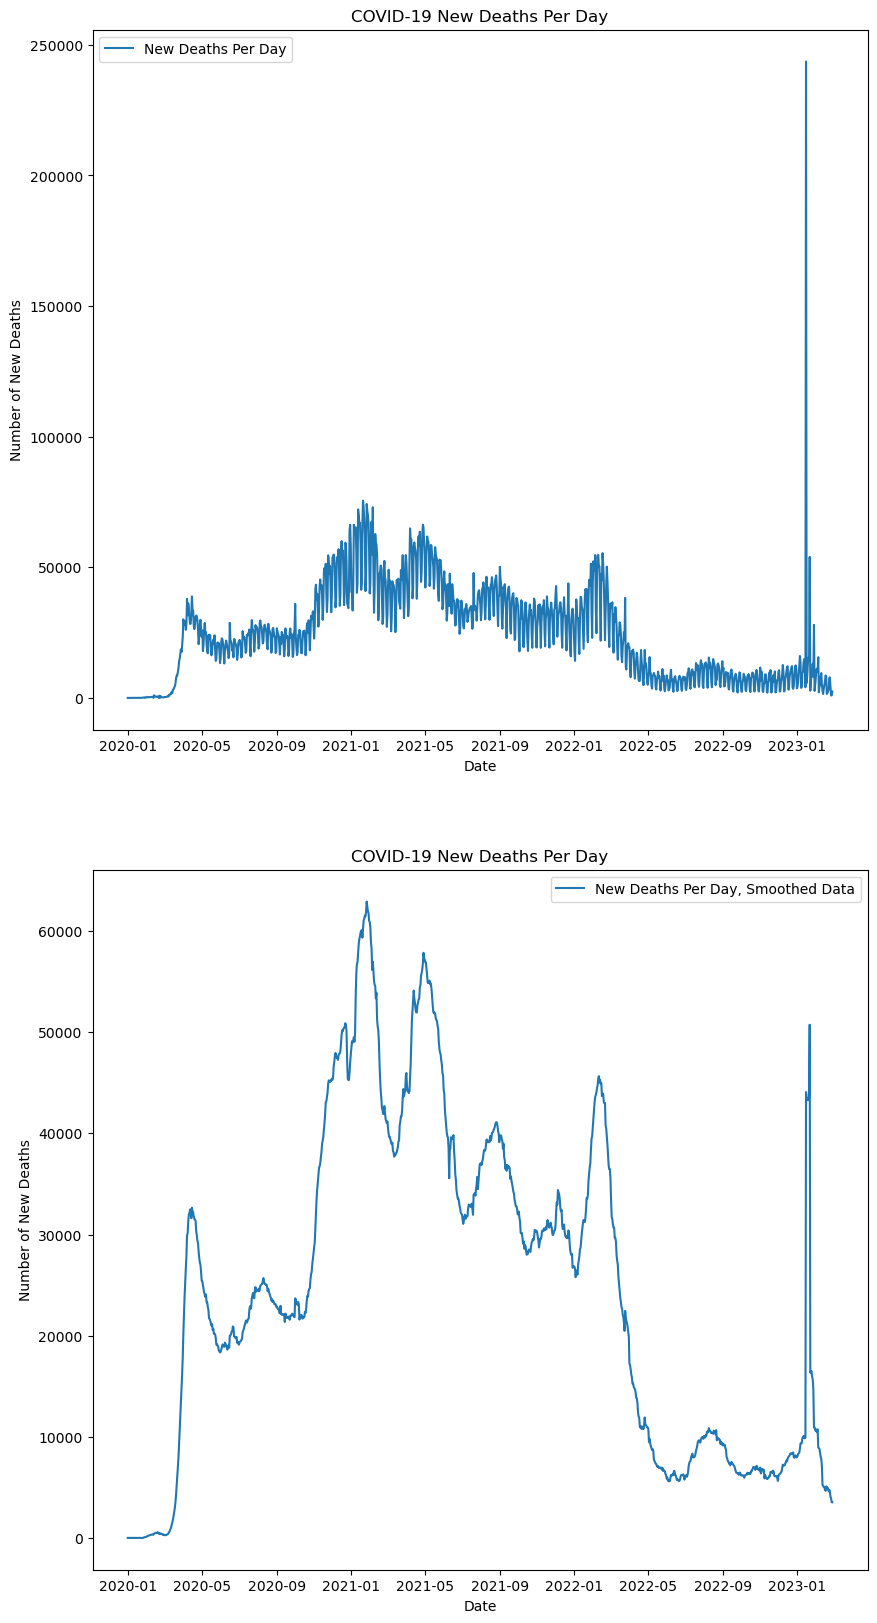

In [20]:
daily_deaths = data.groupby('date')['new_deaths'].sum()
daily_deaths_smoothed = data.groupby('date')['new_deaths_smoothed'].sum()

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,20))

ax1.plot(daily_deaths, label='New Deaths Per Day')
ax1.set(title='COVID-19 New Deaths Per Day', xlabel='Date', ylabel='Number of New Deaths')
ax1.legend()

ax2.plot(daily_deaths_smoothed, label='New Deaths Per Day, Smoothed Data')
ax2.set(title='COVID-19 New Deaths Per Day', xlabel='Date', ylabel='Number of New Deaths')
ax2.legend()

#plt.savefig("../output/Introductory_Visualizations/Deaths/new_deaths.png")

Trying to find out if there is a difference in deaths per million among the continents.

In [21]:
new_deaths_per_million_continent = data.groupby(['date', 'continent'])['new_deaths_per_million'].sum().reset_index()
new_deaths_per_million_continent_smoothed = data.groupby(['date', 'continent'])['new_deaths_smoothed_per_million'].sum().reset_index()
total_cases_per_continent = data.groupby(['date', 'continent'])['total_cases_per_million'].sum().reset_index()
print(new_deaths_per_million_continent)
print(new_deaths_per_million_continent_smoothed)

           date      continent  new_deaths_per_million
0    2020-01-01  North America                   0.000
1    2020-01-01  South America                   0.000
2    2020-01-02  North America                   0.000
3    2020-01-02  South America                   0.000
4    2020-01-03  North America                   0.000
...         ...            ...                     ...
6833 2023-02-27           Asia                   2.713
6834 2023-02-27         Europe                  19.885
6835 2023-02-27  North America                   0.855
6836 2023-02-27        Oceania                   0.000
6837 2023-02-27  South America                   1.555

[6838 rows x 3 columns]
           date      continent  new_deaths_smoothed_per_million
0    2020-01-01  North America                            0.000
1    2020-01-01  South America                            0.000
2    2020-01-02  North America                            0.000
3    2020-01-02  South America                            0

#### 2.2 New deaths per million by continent

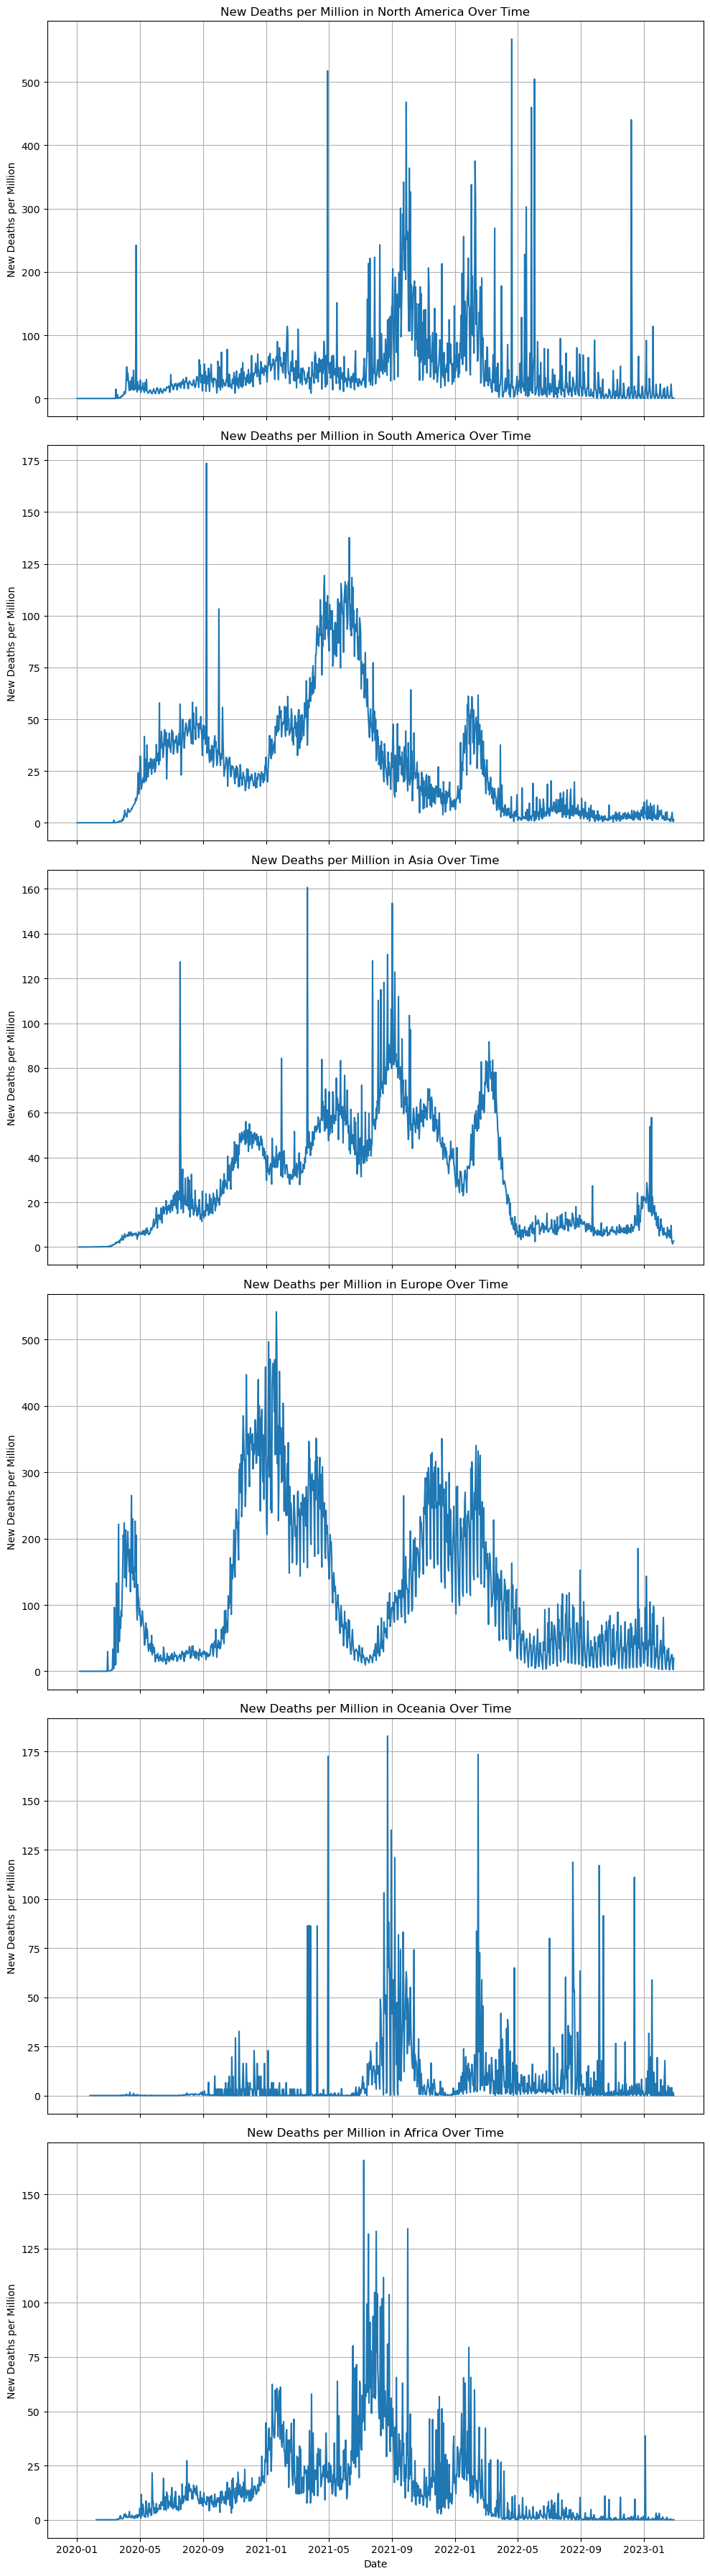

In [22]:
continents_deaths = new_deaths_per_million_continent['continent'].unique()
#Creating suplots per Continent with the real counts
fig, axes = plt.subplots(len(continents_deaths), 1, figsize=(10, 6*len(continents_deaths)), sharex=True)
# Iterate over each continent and create a subplot
for i, continent in enumerate(continents_deaths):
    continent_data = new_deaths_per_million_continent[new_deaths_per_million_continent['continent'] == continent]
    sns.lineplot(data=continent_data, x='date', y='new_deaths_per_million', ax=axes[i])
    axes[i].set_title(f'New Deaths per Million in {continent} Over Time')
    axes[i].set_ylabel('New Deaths per Million')
    axes[i].set_xlabel('Date')
    axes[i].grid(True)
    
plt.tight_layout()

#plt.savefig("../output/Introductory_Visualizations/Deaths/NewDeathsPerMillion_Subplots.png")


#### 2.3 Smoothed new deaths per million by continent

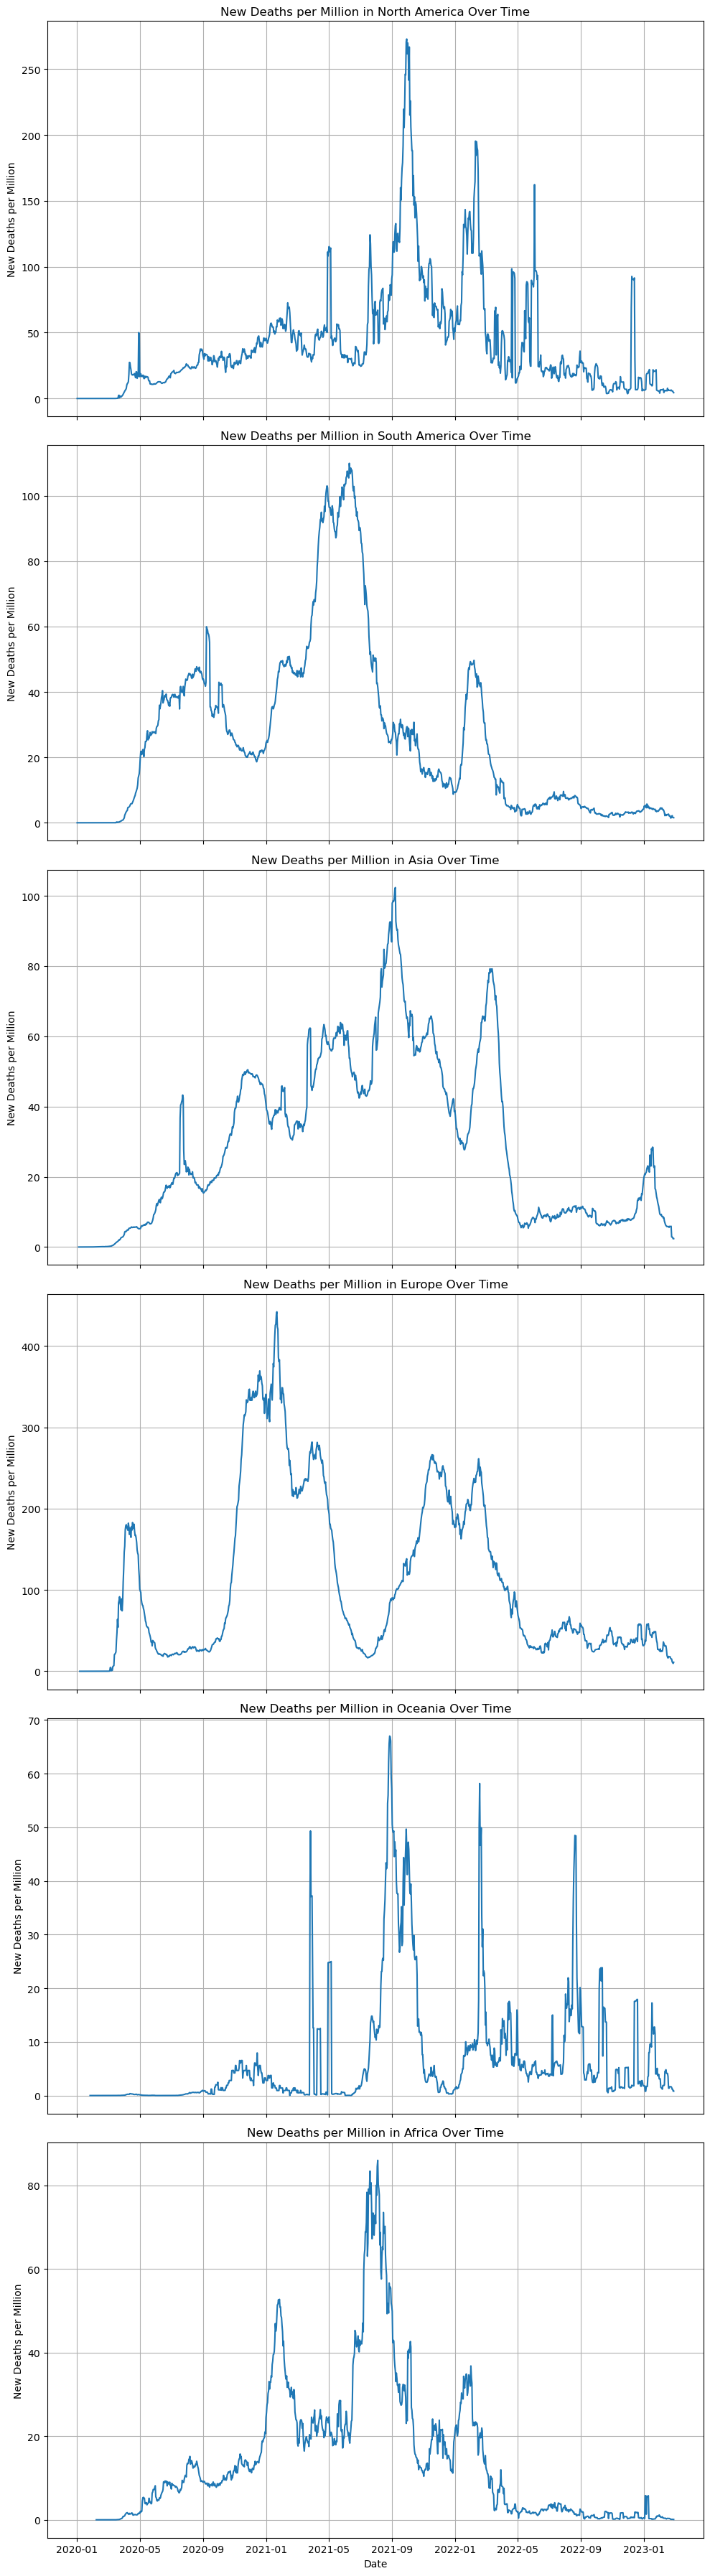

In [23]:
fig, axes = plt.subplots(len(continents_deaths), 1, figsize=(10, 6*len(continents_deaths)), sharex=True)

for i, continent in enumerate(continents_deaths):
    continent_data = new_deaths_per_million_continent_smoothed[new_deaths_per_million_continent_smoothed['continent'] == continent]
    sns.lineplot(data=continent_data, x='date', y='new_deaths_smoothed_per_million', ax=axes[i])
    axes[i].set_title(f'New Deaths per Million in {continent} Over Time')
    axes[i].set_ylabel('New Deaths per Million')
    axes[i].set_xlabel('Date')
    axes[i].grid(True)
    
plt.tight_layout()

#plt.savefig("../output/Introductory_Visualizations/Deaths/NewDeathsPerMillionSmoothed_Subplots.png")

#### 2.4 New deaths per million divided by total cases

Trying to make a statement about the severity by analyzing the new deaths per million divided by the total cases.
Merge the new deaths and total cases. Calculate new deaths per million divided by total cases per million.

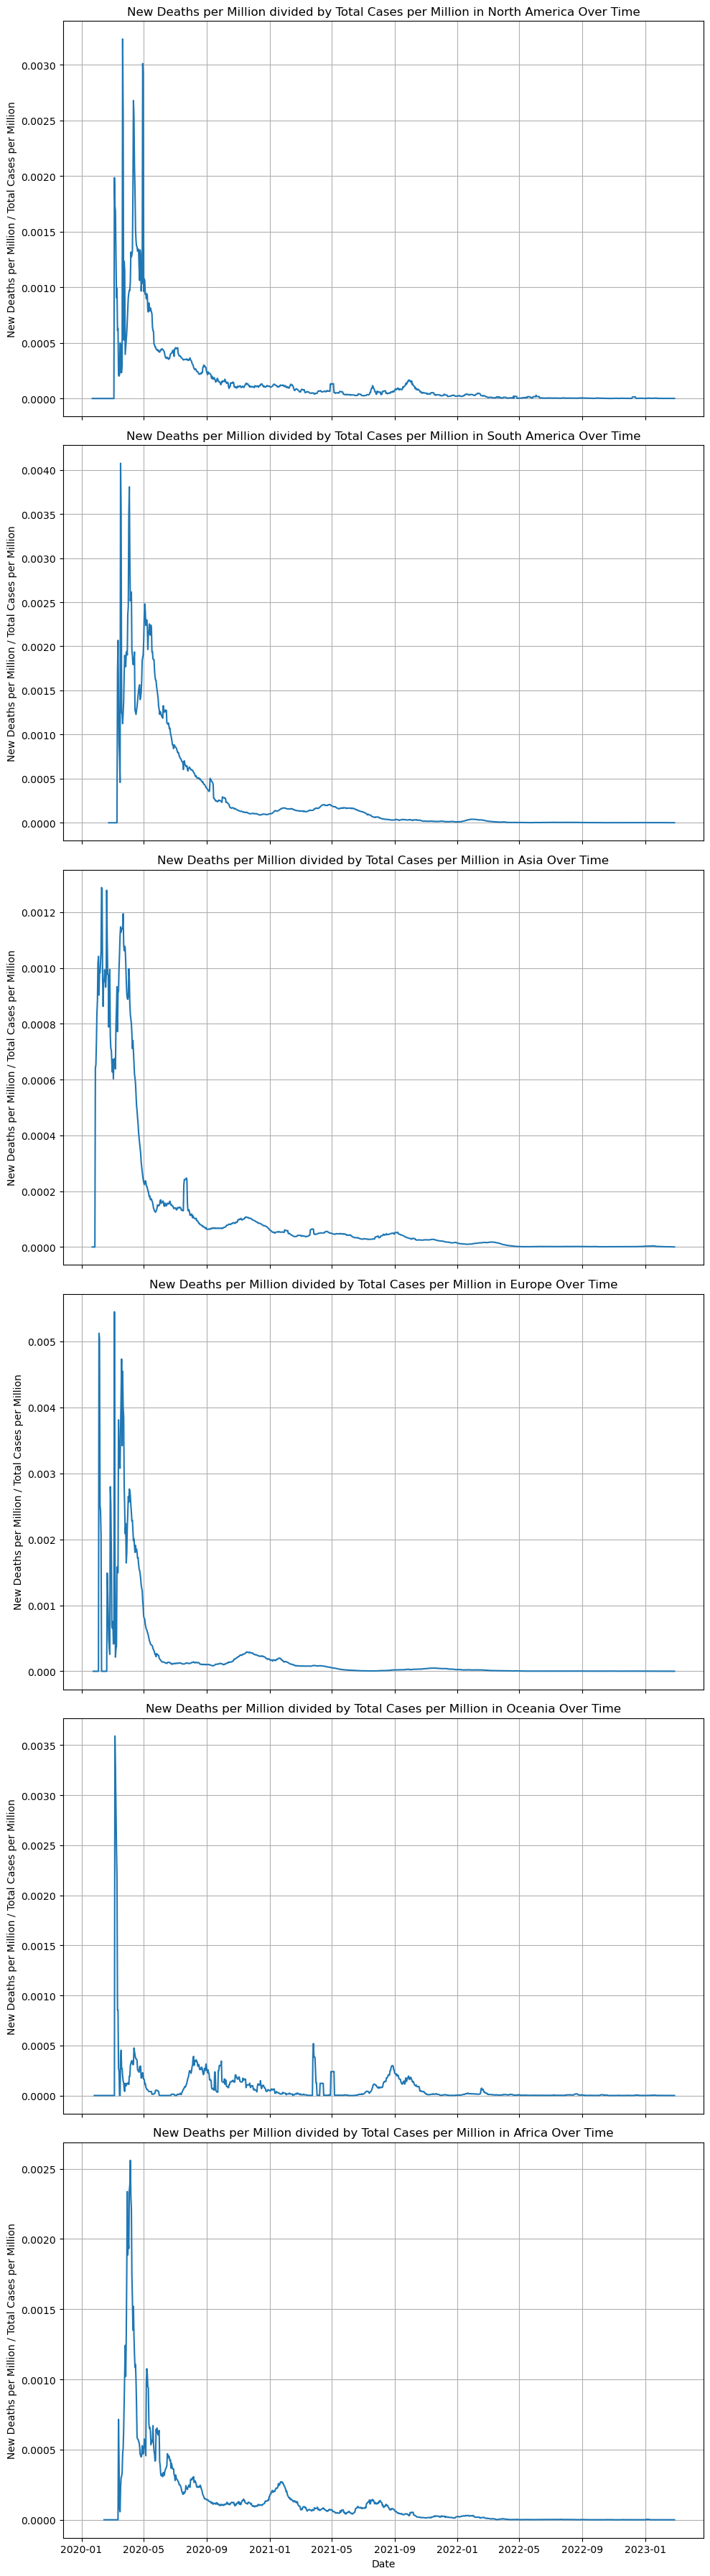

In [24]:
death_cases_merge = pd.merge(new_deaths_per_million_continent_smoothed, total_cases_per_continent, on=['date', 'continent'])
death_cases_merge['deaths_to_cases_ratio'] = death_cases_merge['new_deaths_smoothed_per_million'] / death_cases_merge['total_cases_per_million']


fig, axes = plt.subplots(len(continents_deaths), 1, figsize=(10, 6*len(continents_deaths)), sharex=True)

for i, continent in enumerate(continents_deaths):
    continent_data = death_cases_merge[death_cases_merge['continent'] == continent]
    sns.lineplot(data=continent_data, x='date', y='deaths_to_cases_ratio', ax=axes[i])
    axes[i].set_title(f'New Deaths per Million divided by Total Cases per Million in {continent} Over Time')
    axes[i].set_ylabel('New Deaths per Million / Total Cases per Million')
    axes[i].set_xlabel('Date')
    axes[i].grid(True)
    
plt.tight_layout()

#plt.savefig("../output/Introductory_Visualizations/Deaths/NewDeathsToCasesRatio_Subplots.png")

## 4 Missing Data Analysis


### Structure


1. Introductory remarks about OWID
2. Preparatory steps
3. First overview of missing data
4. Overview missing data "cases" and "deaths"
5. Total cases continent analysis
6. Factual accuracy
7. Country analysis


### 1. Introductory remarks about OWID

OWID itself states that it generally takes its data from 4 different sources:
1. Specialized institutes
2. Research articles
3. International Institutations or statistics agencies
4. Official data from government sources

More specifically, looking at the OWID COVID dataset online where all the sources are indicated, it can be seen that OWID takes most of the data directly from the WHO COVID dashboard and then completes it with other sources which is why this dataset can be expected to be quite complete. However, the following analysis is attempting to analyze how much data is missing from the dataset and what kind of data is missing. 

### 2. Preparatory steps

#### 2.1 Adjusting visualization settings

In [25]:
# Define colorblind-friendly palette
color_palette = sns.color_palette("colorblind")

In [26]:
#adjusting the viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### 2.2 Data Cleaning


In [27]:
#dropping duplicates
data = data.drop_duplicates()
#separating OWID from non_OWID data
data_without_OWID = data[~data['iso_code'].str.contains('OWID')]
data_OWID = data[data['iso_code'].str.contains('OWID')]

What OWID contains:

In [28]:
grouped_OWID_loc = data_OWID.groupby("location")
loc_OWID = list(grouped_OWID_loc.groups.keys())
print(loc_OWID)

['Africa', 'Asia', 'England', 'Europe', 'European Union', 'High income', 'International', 'Kosovo', 'Low income', 'Lower middle income', 'North America', 'Northern Cyprus', 'Northern Ireland', 'Oceania', 'Scotland', 'South America', 'Upper middle income', 'Wales', 'World']


OWID contains a few extra metrics and countries/continents or composites of such.

### 3. First overview of missing data

#### 3.1 Entries with complete information

In [29]:
#For how many entries do we have complete information?
(data.isna().sum(axis=1) == 0).sum()

0

#### 3.2 Missing values per column overall

In [30]:
#missing values overall per column
total_missing = data.isnull().sum()
total_missing_percentage = (total_missing / len(data)) * 100
total_missing_sorted = total_missing.sort_values()
total_missing_percentage_sorted = total_missing_percentage.sort_values()

[Text(0.5, 1.0, 'Missing values per variable'),
 Text(0.5, 0, 'Percentage of Missing Values'),
 Text(0, 0.5, 'Variables')]

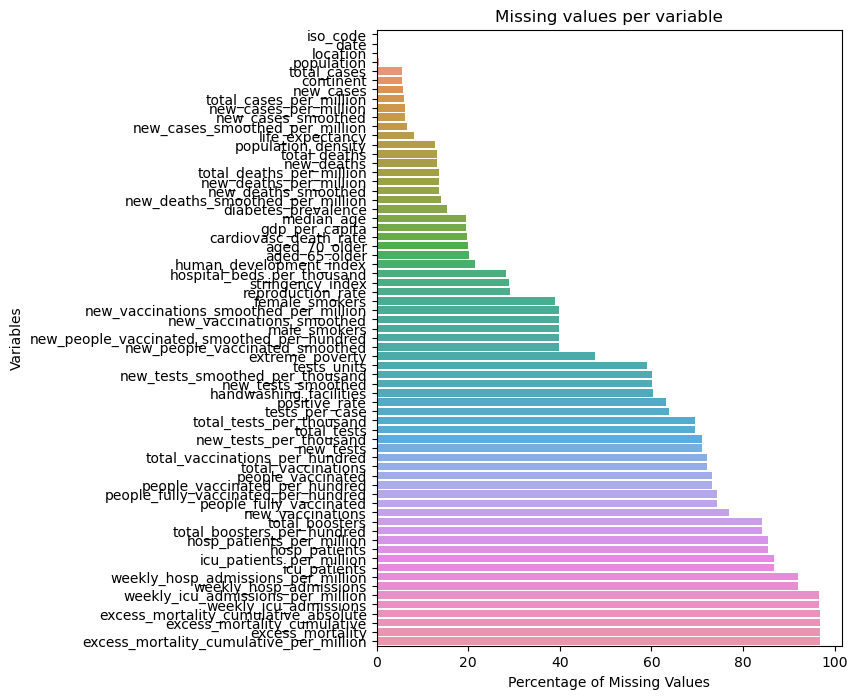

In [31]:
#graphing the missing values per column
plt.figure(figsize=(6, 8))
fig_mv_variables = sns.barplot(
    x = total_missing_percentage_sorted.values,
    y = total_missing_percentage_sorted.index
)
fig_mv_variables.set(
    title="Missing values per variable",
    xlabel="Percentage of Missing Values",
    ylabel="Variables"
)
#plt.savefig("../output/Missing_Data_Analysis/missing_data.png", bbox_inches="tight")              

### 4. Overview missing data "cases" and "deaths"

#### 4.1 Selecting only the columns containing information about cases and deaths

In [32]:
#selecting the columns about cases of interest
columns_about_cases = data.loc[:, data.columns.str.contains('cases')]
columns_about_cases.columns

Index(['total_cases', 'new_cases', 'new_cases_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million'], dtype='object')

In [33]:
columns_about_deaths = data.loc[:, data.columns.str.contains('death')]
columns_about_deaths.columns

Index(['total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'cardiovasc_death_rate'], dtype='object')

#### 4.2 Sorting and plotting overall missing data about cases

In [34]:
def missing_data_filtered(columns_of_interest):
    total_missing = columns_of_interest.isnull().sum()
    total_missing_percentage = (total_missing / len(data)) * 100
    total_missing_sorted = total_missing.sort_values()
    total_missing_percentage_sorted = total_missing_percentage.sort_values()
    return total_missing_percentage_sorted

total_missing_percentage_deaths_sorted = missing_data_filtered(columns_about_deaths)

[Text(0.5, 1.0, 'Missing values per variable'),
 Text(0.5, 0, 'Percentage of Missing Values'),
 Text(0, 0.5, 'Variables')]

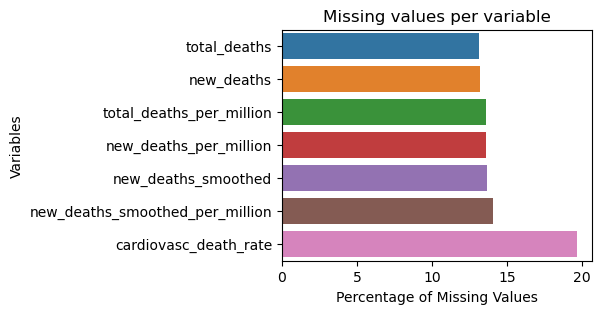

In [35]:
plt.figure(figsize=(4, 3))
deaths_overview = sns.barplot(
    x = total_missing_percentage_deaths_sorted.values,
    y = total_missing_percentage_deaths_sorted.index
)
deaths_overview.set(
    title="Missing values per variable",
    xlabel="Percentage of Missing Values",
    ylabel="Variables"
)
#plt.savefig("../output/Missing_Data_Analysis/deathsmissing_data.png", bbox_inches="tight")  

#### 4.3 Sorting and plotting overall missing data about deaths

In [36]:
total_missing_percentage_cases_sorted = missing_data_filtered(columns_about_cases)

[Text(0.5, 1.0, 'Missing values per variable'),
 Text(0.5, 0, 'Percentage of Missing Values'),
 Text(0, 0.5, 'Variables')]

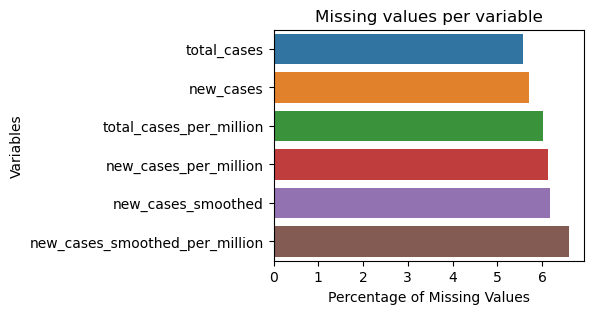

In [37]:
plt.figure(figsize=(4, 3))
cases_overview = sns.barplot(
    x = total_missing_percentage_cases_sorted.values,
    y = total_missing_percentage_cases_sorted.index
)
cases_overview.set(
    title="Missing values per variable",
    xlabel="Percentage of Missing Values",
    ylabel="Variables"
)
#plt.savefig("../output/Missing_Data_Analysis/casesmissing_data.png", bbox_inches="tight") 

There is in the overall dataset a lot more data around cases than deaths. However, amongst the columns that give information about either death or cases, the variability as to the amount of missing data is low.

### 5 Total cases continent analysis


#### 5.1 Amount of data per country

Comment: Since reporting is generally done on a national level, it makes sense to have a look at individual countries to find out where potential data is missing.

In [38]:
#how many countries are we dealing with overall
unique_values_world = data_without_OWID['iso_code'].unique()
print (len(unique_values_world))

229


In [39]:
#calculating the number of entries for each country
length_list = []
length_list_in_years = []

for i in range(len(unique_values_world)):
    country = unique_values_world[i]
    length_country = len(data_without_OWID.loc[df['iso_code'] == country])
    length_list.append(length_country)
    length_list_in_years.append(length_country/365)

sorted_country_length = sorted(length_list)

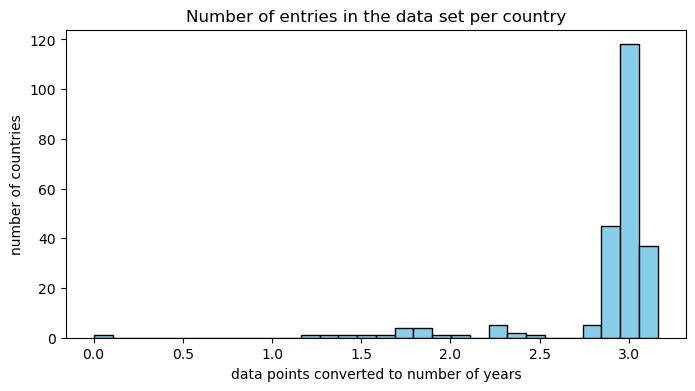

In [40]:
plt.figure(figsize=(8, 4))
plt.hist(length_list_in_years, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('data points converted to number of years')
plt.ylabel('number of countries')
plt.title("Number of entries in the data set per country")
plt.show()

#### 5.2 Total cases Asia


In [41]:
#different continents
filtered_continents = data_without_OWID["continent"].unique()
filtered_continents

array(['Asia', 'Europe', 'Africa', 'North America', 'South America',
       'Oceania'], dtype=object)

In [42]:
#function returning list of all different countries on one continent
def countries_per_continent(continent):
    filtered_continent = data_without_OWID.loc[df['continent'] == continent]
    unique_values_continent = filtered_continent['iso_code'].unique()
    return unique_values_continent

unique_values_Asia = countries_per_continent("Asia")
unique_values_Asia

array(['AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'BRN', 'KHM', 'CHN',
       'GEO', 'HKG', 'IND', 'IDN', 'IRN', 'IRQ', 'ISR', 'JPN', 'JOR',
       'KAZ', 'KWT', 'KGZ', 'LAO', 'LBN', 'MAC', 'MYS', 'MDV', 'MNG',
       'MMR', 'NPL', 'PRK', 'OMN', 'PAK', 'PSE', 'PHL', 'QAT', 'SAU',
       'SGP', 'KOR', 'LKA', 'SYR', 'TWN', 'TJK', 'THA', 'TLS', 'TUR',
       'TKM', 'ARE', 'UZB', 'VNM', 'YEM'], dtype=object)

In [43]:
def continent_values(continent_uniq_val):
    values = []
    for i in range(len(continent_uniq_val)):
        currentcountry = continent_uniq_val[i]
        filtered_country = data.loc[df['iso_code'] == currentcountry]
        no_rows_current_country = len(filtered_country)
        missing = (filtered_country["total_cases"].isnull().sum())
        total_missing_percentage_current_country = (missing / len(filtered_country)) * 100
        values.append(total_missing_percentage_current_country)
    return values

values_Asia = continent_values(unique_values_Asia)

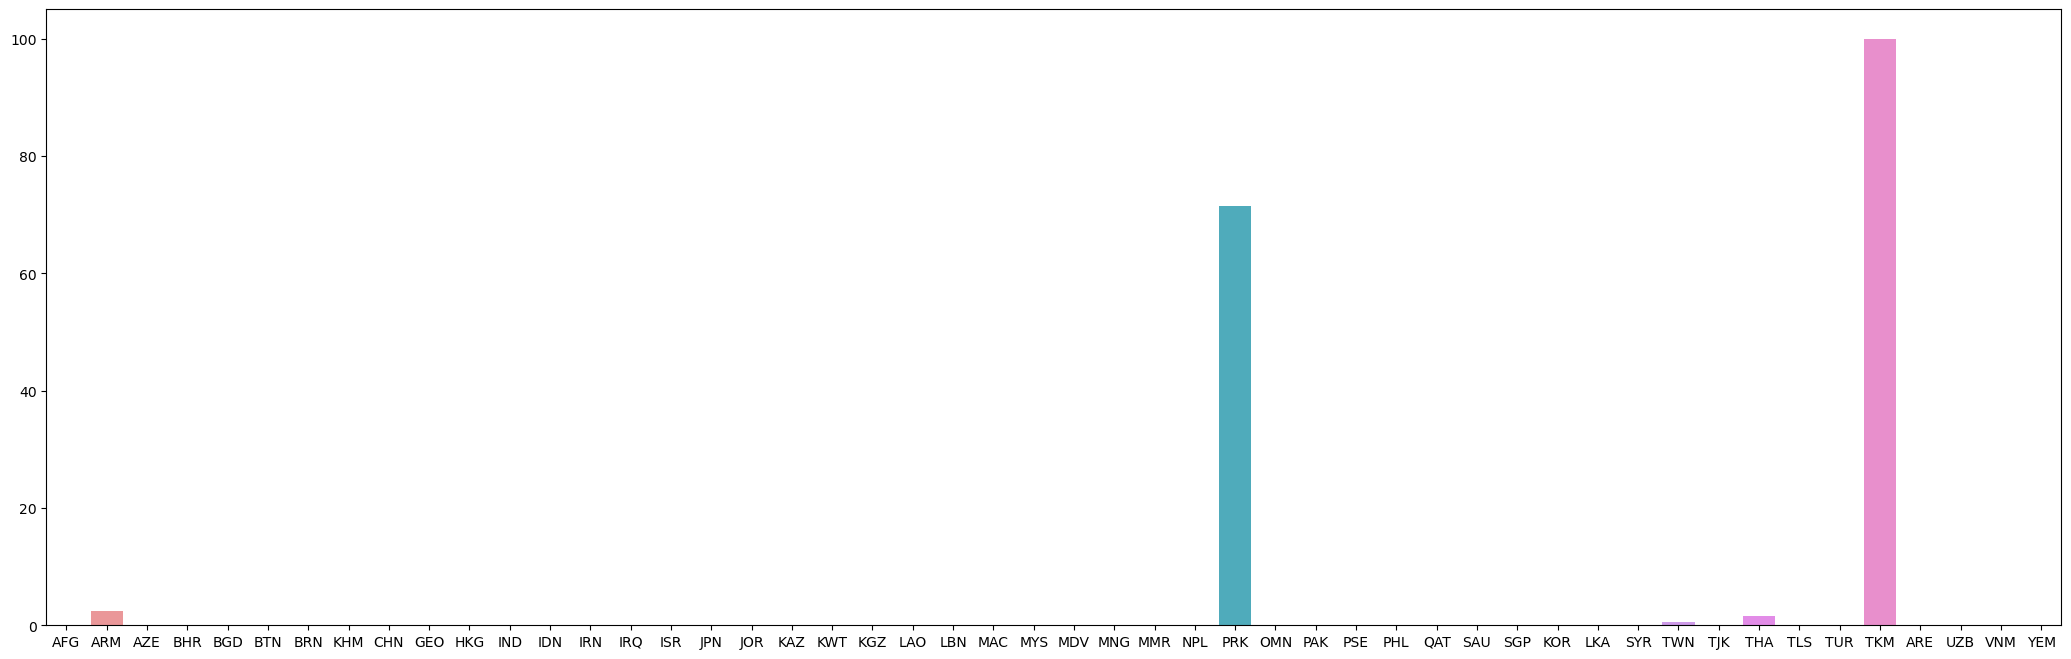

In [44]:
def plotting_barplot_continent (unique_codes, values):
    plt.figure(figsize=(26, 8))
    missing_values_Asia = sns.barplot(
        x = unique_codes,
        y = values
    )

    deaths_overview.set(
        title="Missing values per variable",
        xlabel="Percentage of Missing Values",
        ylabel="Variables"
    )

    #plt.savefig("../output/Missing_Data_Analysis/casesmissing_data2.png", bbox_inches="tight") 

plotting_barplot_continent(unique_values_Asia, values_Asia)

#### 5.3 Total Cases Europe

In [45]:
unique_values_Europe = countries_per_continent("Europe")
unique_values_Europe

array(['ALB', 'AND', 'AUT', 'BLR', 'BEL', 'BIH', 'BGR', 'HRV', 'CYP',
       'CZE', 'DNK', 'EST', 'FRO', 'FIN', 'FRA', 'DEU', 'GIB', 'GRC',
       'GGY', 'HUN', 'ISL', 'IRL', 'IMN', 'ITA', 'JEY', 'LVA', 'LIE',
       'LTU', 'LUX', 'MLT', 'MDA', 'MCO', 'MNE', 'NLD', 'MKD', 'NOR',
       'POL', 'PRT', 'ROU', 'RUS', 'SMR', 'SRB', 'SVK', 'SVN', 'ESP',
       'SWE', 'CHE', 'UKR', 'GBR', 'VAT'], dtype=object)

In [46]:
values_Europe = continent_values(unique_values_Europe)

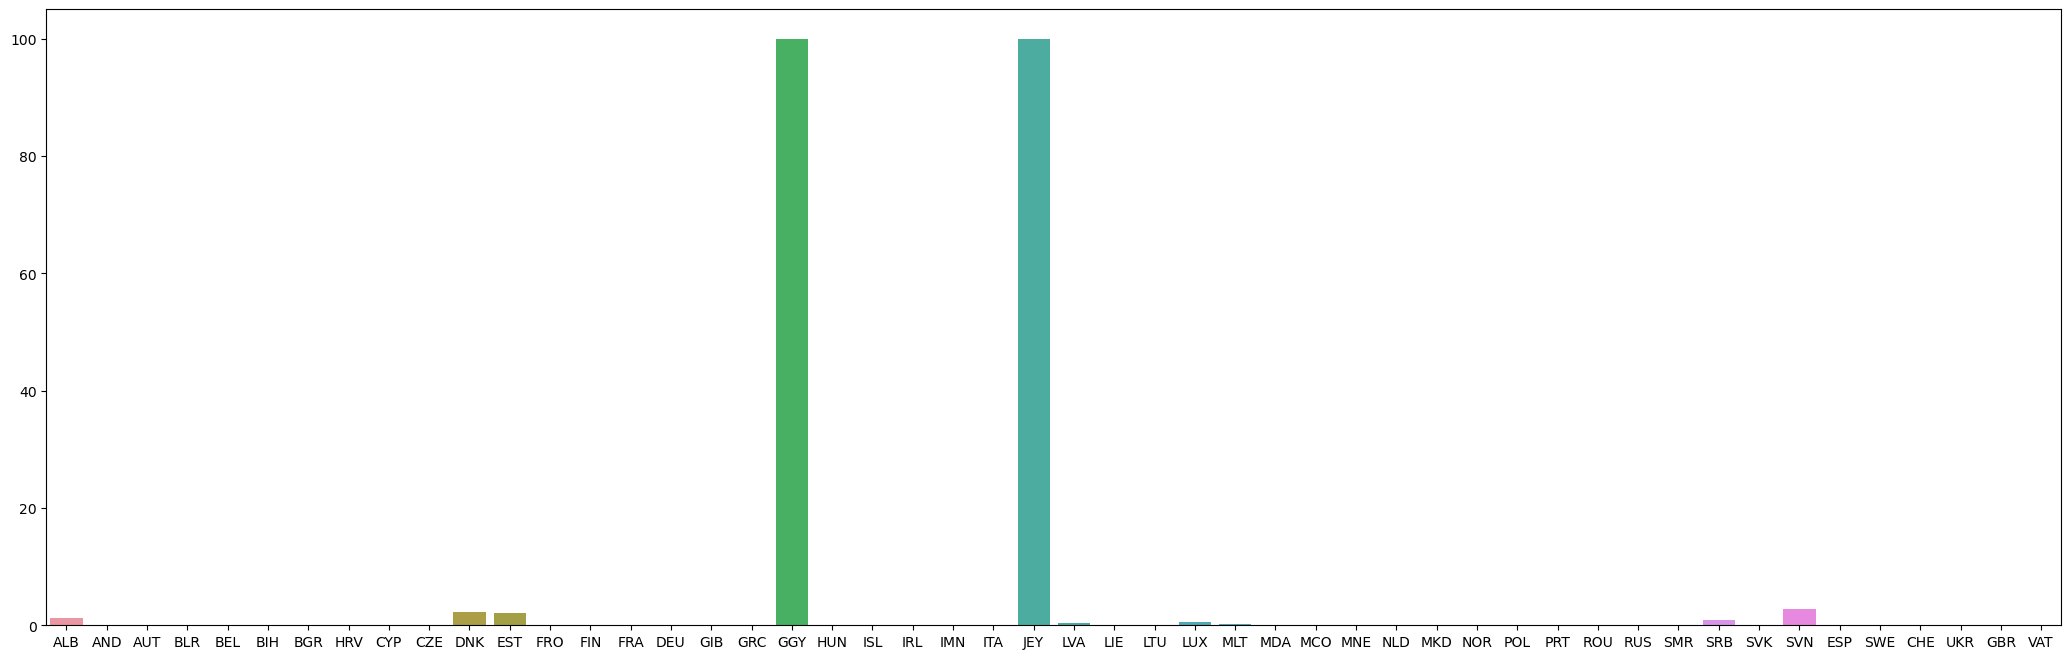

In [47]:
plotting_barplot_continent(unique_values_Europe, values_Europe)

#### 5.4 Total Cases Africa

In [48]:
unique_values_Africa = countries_per_continent("Africa")
unique_values_Africa

array(['DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CMR', 'CPV', 'CAF',
       'TCD', 'COM', 'COG', 'CIV', 'COD', 'DJI', 'EGY', 'GNQ', 'ERI',
       'SWZ', 'ETH', 'GAB', 'GMB', 'GHA', 'GIN', 'GNB', 'KEN', 'LSO',
       'LBR', 'LBY', 'MDG', 'MWI', 'MLI', 'MRT', 'MUS', 'MAR', 'MOZ',
       'NAM', 'NER', 'NGA', 'RWA', 'SHN', 'STP', 'SEN', 'SYC', 'SLE',
       'SOM', 'ZAF', 'SSD', 'SDN', 'TZA', 'TGO', 'TUN', 'UGA', 'ESH',
       'ZMB', 'ZWE'], dtype=object)

In [49]:
values_Africa = continent_values(unique_values_Africa)

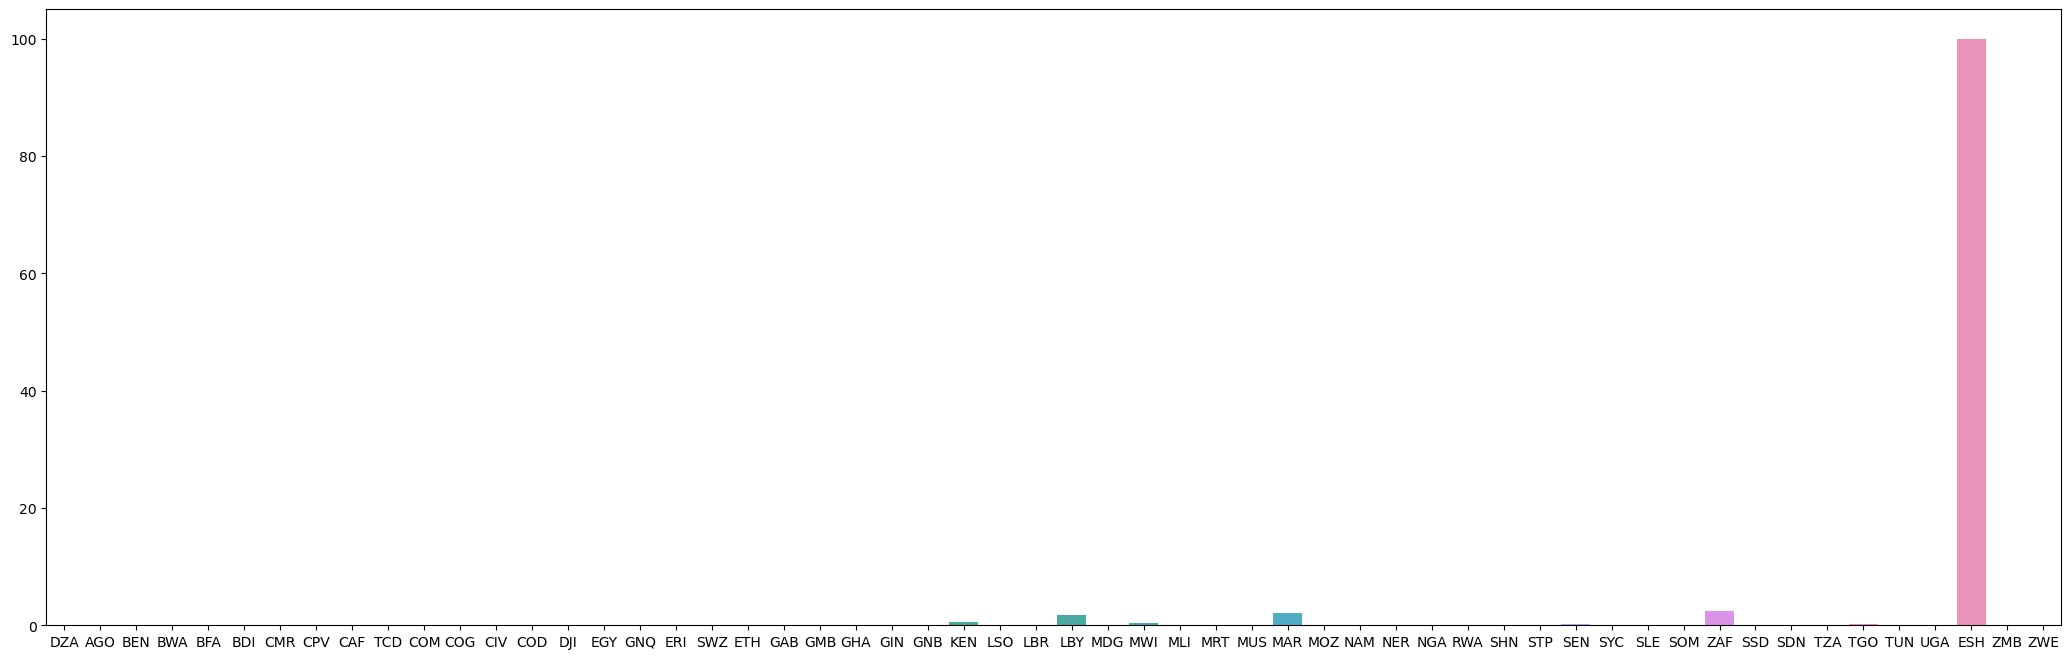

In [50]:
plotting_barplot_continent(unique_values_Africa, values_Africa)

#### 5.5 Total Cases North America

In [51]:
unique_values_North_America = countries_per_continent("North America")
unique_values_North_America

array(['AIA', 'ATG', 'ABW', 'BHS', 'BRB', 'BLZ', 'BMU', 'BES', 'VGB',
       'CAN', 'CYM', 'CRI', 'CUB', 'CUW', 'DMA', 'DOM', 'SLV', 'GRL',
       'GRD', 'GTM', 'HTI', 'HND', 'JAM', 'MEX', 'MSR', 'NIC', 'PAN',
       'PRI', 'KNA', 'LCA', 'SPM', 'VCT', 'SXM', 'TTO', 'TCA', 'USA',
       'VIR'], dtype=object)

In [52]:
values_North_America = continent_values(unique_values_North_America)

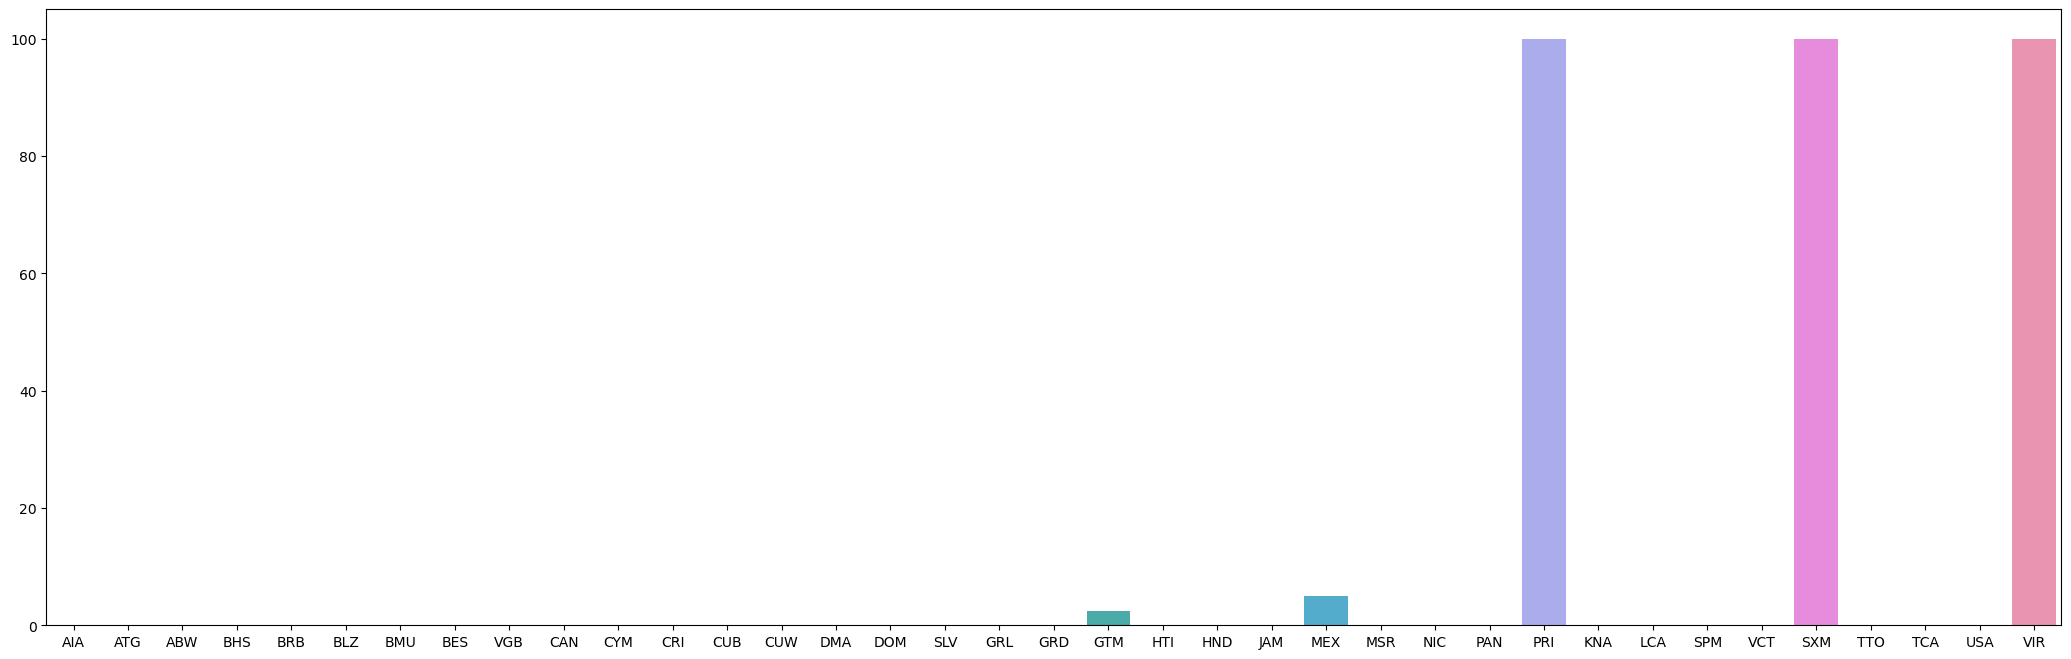

In [53]:
plotting_barplot_continent(unique_values_North_America, values_North_America)

### 6. Factual accuracy

#### 6.1 Do total cases and new cases lead to the same numbers?

Looking at Canada the reporting started on 23 of January but the first death was on March 9. A quick search on the internet confirms that 9 March was the date on which the frist Canadian person died. That makes 46 days on which there is no data on deaths. But there are 1132 entries for Canada and hence 46/1132 = 4%. In the case of Switzerland 10 no values for deaths and 1099 rows so that would make 1% of the data missing. For Germany 42/1128 = 4%. All of this data is not missing, it is just wrongly classified as NA when these should be zero.

In [54]:
def comparison_total_new_cases(country): 
    filtered_country = data_without_OWID.loc[df["location"] == "Sweden"]
    filtered_country_total_cases_from_tc = filtered_country.iloc[-1, 4]
    print ("total cases from the total cases column: ", filtered_country_total_cases_from_tc)
    print ("total cases when summing over new cases: ", filtered_country["new_cases"].sum())

comparison_total_new_cases("Sweden")

total cases from the total cases column:  2697827.0
total cases when summing over new cases:  2697827.0


#### 6.2 How accurate are vaccination statistics?

According to Wikipedia, the first vaccination in Switzerland, Germany and France tool place on December 23 2020, December 22, 2020 and December 17, 2020 respectively. The dataset confirms these:

In [55]:
def first_vaccination_statistics_accuracy(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_country.reset_index(drop=True)
    first_vaccination_index = filtered_country["total_vaccinations"].first_valid_index()
    return filtered_country.iloc[first_vaccination_index,:5]
    
first_vaccination_statistics_accuracy("France")

iso_code                       FRA
continent                   Europe
location                    France
date           2020-12-27 00:00:00
total_cases              2599937.0
Name: 338, dtype: object

### 7. Country analysis

#### 7.1 Function to replace missing data with zeros

In [56]:
#here is how to replace the mssing values with zero values
def replace_missing_data(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    #filtered_country = filtered_Italy.reset_index(drop=True)
    missing_vals = ["NA", "", None, np.NaN]
    missing_country = filtered_country.isin(missing_vals)


#### 7.2 Function for missing values excluding missing at the end and at the beginning for a specific country

In [57]:
def filtering_missing_country(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_country.reset_index(drop=True)
    filtered_country_summary = filtered_country.isnull().sum()
    first_valid_indices_country = filtered_country.apply(lambda x: x.first_valid_index())
    last_valid_indices_country = filtered_country.apply(lambda x: x.last_valid_index())
    length = len(filtered_country) - 1

    filtered_country_summary_df = filtered_country_summary.to_frame()
    first_valid_indices_country_df = first_valid_indices_country.to_frame()
    last_valid_indices_country_df = last_valid_indices_country.to_frame()
    list_of_dataframes = [filtered_country_summary_df, first_valid_indices_country_df, last_valid_indices_country]

    comparison_country = pd.merge(filtered_country_summary_df, first_valid_indices_country_df, left_index=True, right_index=True)
    comparison_country = comparison_country.rename(columns={"0_x": '# of missing entries', "0_y": "first entry"})
    diff_first = filtered_country_summary_df - first_valid_indices_country_df
    last_valid_indices_country_df_diff = length - last_valid_indices_country_df
    diff_overall = filtered_country_summary_df - first_valid_indices_country_df - last_valid_indices_country_df_diff
    comparison_country = comparison_country.assign(diff_first = diff_first, \
                last_entry= last_valid_indices_country_df, diff_last = last_valid_indices_country_df_diff, \
                diff_overall = diff_overall)
    return (comparison_country)

In [58]:
filtering_missing_country("Finland")

# of missing entries  first entry  diff_first  last_entry  diff_last  diff_overall
iso_code                                                       0          0.0         0.0      1125.0        0.0           0.0
continent                                                      0          0.0         0.0      1125.0        0.0           0.0
location                                                       0          0.0         0.0      1125.0        0.0           0.0
date                                                           0          0.0         0.0      1125.0        0.0           0.0
total_cases                                                    0          0.0         0.0      1125.0        0.0           0.0
new_cases                                                      4          0.0         4.0      1121.0        4.0           0.0
new_cases_smoothed                                             9          5.0         4.0      1121.0        4.0           0.0
total_deaths                                                  38         38.0         0.0      1125.0        0.0           0.0
new_deaths                                                    43         38.0         5.0      1121.0        4.0           1.0
new_deaths_smoothed                                           48         43.0         5.0      1121.0        4.0           1.0
total_cases_per_million                                        0          0.0         0.0      1125.0        0.0           0.0
new_cases_per_million                                          4          0.0         4.0      1121.0        4.0           0.0
new_cases_smoothed_per_million                                 9          5.0         4.0      1121.0        4.0           0.0
total_deaths_per_million                                      38         38.0         0.0      1125.0        0.0           0.0
new_deaths_per_million                                        43         38.0         5.0      1121.0        4.0           1.0
new_deaths_smoothed_per_million                               48         43.0         5.0      1121.0        4.0           1.0
reproduction_rate                                             99         43.0        56.0      1069.0       56.0           0.0
icu_patients                                                 318         52.0       266.0      1037.0       88.0         178.0
icu_patients_per_million                                     318         52.0       266.0      1037.0       88.0         178.0
hosp_patients                                                318         52.0       266.0      1037.0       88.0         178.0
hosp_patients_per_million                                    318         52.0       266.0      1037.0       88.0         178.0
weekly_icu_admissions                                       1126          NaN         NaN         NaN        NaN           NaN
weekly_icu_admissions_per_million                           1126          NaN         NaN         NaN        NaN           NaN
weekly_hosp_admissions                                      1126          NaN         NaN         NaN        NaN           NaN
weekly_hosp_admissions_per_million                          1126          NaN         NaN         NaN        NaN           NaN
total_tests                                                  281         29.0       252.0       873.0      252.0           0.0
new_tests                                                    281         29.0       252.0       873.0      252.0           0.0
total_tests_per_thousand                                     281         29.0       252.0       873.0      252.0           0.0
new_tests_per_thousand                                       281         29.0       252.0       873.0      252.0           0.0
new_tests_smoothed                                           288         36.0       252.0       873.0      252.0           0.0
new_tests_smoothed_per_thousand                              288         36.0       252.0       873.0      

#### 7.3 Function total diff for many countries

In [59]:
def locations_per_continent(continent):
    filtered_continent = data_without_OWID.loc[df['continent'] == continent]
    unique_values_continent = filtered_continent['location'].unique()
    return unique_values_continent

In [60]:
unique_locations_Europe = locations_per_continent("Europe")
empty_df = pd.DataFrame()

def several_countries(list, dataframe):
    count = 0
    for i in (list):
        country = filtering_missing_country(i)
        #print (country)
        country_diff_overall_column = country["diff_overall"]
        #print (country_diff_overall_column)
        country_diff_overall_column_df = country_diff_overall_column.to_frame()
        if count == 0:
            combined_df = pd.concat([empty_df, country_diff_overall_column_df], axis=1)
            count = 1
        elif count > 0:
            combined_df = pd.concat([combined_df, country_diff_overall_column_df], axis=1)
        #print (country_diff_overall_column_df)
        combined_df = combined_df.rename(columns={'diff_overall': i})
    return (combined_df)

several_countries(unique_locations_Europe, empty_df)

Albania  Andorra  Austria  Belarus  Belgium  Bosnia and Herzegovina  Bulgaria  Croatia  Cyprus  Czechia  Denmark  Estonia  Faeroe Islands  Finland  France  Germany  Gibraltar  Greece  Guernsey  Hungary  Iceland  Ireland  Isle of Man  Italy  Jersey  Latvia  Liechtenstein  Lithuania  Luxembourg  Malta  Moldova  Monaco  Montenegro  Netherlands  North Macedonia  Norway  Poland  Portugal  Romania  Russia  San Marino  Serbia  Slovakia  Slovenia  Spain  Sweden  Switzerland  Ukraine  United Kingdom  Vatican
iso_code                                        0.0      0.0      0.0      0.0      0.0                     0.0       0.0      0.0     0.0      0.0      0.0      0.0             0.0      0.0     0.0      0.0        0.0     0.0       0.0      0.0      0.0      0.0          0.0    0.0     0.0     0.0            0.0        0.0         0.0    0.0      0.0     0.0         0.0          0.0              0.0     0.0     0.0       0.0      0.0     0.0         0.0     0.0       0.0       0.0    0.0     0.0          0.0      0.0             0.0      0.0
continent                                       0.0      0.0      0.0      0.0      0.0                     0.0       0.0      0.0     0.0      0.0      0.0      0.0             0.0      0.0     0.0      0.0        0.0     0.0       0.0      0.0      0.0      0.0          0.0    0.0     0.0     0.0            0.0        0.0         0.0    0.0      0.0     0.0         0.0          0.0              0.0     0.0     0.0       0.0      0.0     0.0         0.0     0.0       0.0       0.0    0.0     0.0          0.0      0.0             0.0      0.0
location                                        0.0      0.0      0.0      0.0      0.0                     0.0       0.0      0.0     0.0      0.0      0.0      0.0             0.0      0.0     0.0      0.0        0.0     0.0       0.0      0.0      0.0      0.0          0.0    0.0     0.0     0.0            0.0        0.0         0.0    0.0      0.0     0.0         0.0          0.0              0.0     0.0     0.0       0.0      0.0     0.0         0.0     0.0       0.0       0.0    0.0     0.0          0.0      0.0             0.0      0.0
date                                            0.0      0.0      0.0      0.0      0.0                     0.0       0.0      0.0     0.0      0.0      0.0      0.0             0.0      0.0     0.0      0.0        0.0     0.0       0.0      0.0      0.0      0.0          0.0    0.0     0.0     0.0            0.0        0.0         0.0    0.0      0.0     0.0         0.0          0.0              0.0     0.0     0.0       0.0      0.0     0.0         0.0     0.0       0.0       0.0    0.0     0.0          0.0      0.0             0.0      0.0
total_cases                                     0.0      0.0      0.0      0.0      0.0                     0.0       0.0      0.0     0.0      0.0      0.0      0.0             0.0      0.0     0.0      0.0        0.0     0.0       NaN      0.0      0.0      0.0          0.0    0.0     NaN     0.0            0.0        0.0         0.0    0.0      0.0     0.0         0.0          0.0              0.0     0.0     0.0       0.0      0.0     0.0         0.0     0.0       0.0       0.0    0.0     0.0          0.0      0.0             0.0      0.0
new_cases                                       0.0      0.0      4.0      0.0      0.0                     0.0       0.0      0.0     0.0      5.0      1.0      1.0             0.0      0.0    12.0      0.0        4.0     0.0       NaN      0.0      2.0      4.0          0.0    1.0     NaN     0.0            2.0        1.0         1.0    1.0      0.0     2.0         0.0          0.0              1.0     0.0     0.0       1.0      0.0     0.0         0.0     2.0       2.0       0.0    5.0     0.0          0.0      0.0             4.0      0.0
new_cases_smoothed                              0.0      0.0      3.0      0.0      0.0                     0.0       0.0      0.0     0.0      5.0      1.0      1.0             0.0      0.0    20.0   

In [61]:
country_of_interest = "Finland"
filtered = data_without_OWID.loc[df['location'] == country_of_interest]
filtered = filtered.reset_index(drop=True)
vaccinations = filtered["total_vaccinations"]
vaccinations.head(500)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
15           NaN
16           NaN
17           NaN
18           NaN
19           NaN
20           NaN
21           NaN
22           NaN
23           NaN
24           NaN
25           NaN
26           NaN
27           NaN
28           NaN
29           NaN
30           NaN
31           NaN
32           NaN
33           NaN
34           NaN
35           NaN
36           NaN
37           NaN
38           NaN
39           NaN
40           NaN
41           NaN
42           NaN
43           NaN
44           NaN
45           NaN
46           NaN
47           NaN
48           NaN
49           NaN
50           NaN
51           NaN
52           NaN
53           NaN
54           NaN
55           NaN
56           NaN
57           NaN
58           N

Finland and other countries only reporting once per week

## 5 Handling of missing data

### Structure
1. Decision to delete columns 63:67
2. Decision to delete entire countries
3. Decision over keeping or deleting/imputing columns 0:16 (Nico)
4. Decision over keeping or deleting/imputing columns 16:32 (Leon)
5. Decision over keeping or deleting/imputing columns 32:48 (Florin)
6. Decision over keeping or deleting/imputing columns 48:63 (Sevi)
7. Actual imputations and deletions

### 1. Decision to delete columns 63:67

In [62]:
missing_percentages = df.iloc[:,63:].isnull().sum() / df.shape[0] *100
print(missing_percentages)

excess_mortality_cumulative_absolute       96.6807
excess_mortality_cumulative                96.6807
excess_mortality                           96.6807
excess_mortality_cumulative_per_million    96.6807
dtype: float64


More than 95% of entries are missing. These four columns will be deleted entirely

### 2. Decision to delete entire countries

#### 2.1 What countries miss how many rows entirely?

What countries are missing entire columns? Helps us determine if we should maybe just remove the countries instead of the columns

In [63]:
result_data = []
for column in df.columns:
    grouped_by_iso = df.groupby("iso_code")
    nan_counts = grouped_by_iso[column].apply(lambda x: x.isnull().all())
    result_data.extend([{'ISO_Code': iso_code, 'Column': column, 'All_NaN': all_nan} for iso_code, all_nan in zip(nan_counts.index, nan_counts.values)])

result_df = pd.DataFrame(result_data)
most_true_iso_code = result_df.loc[result_df['All_NaN']].groupby('ISO_Code').size().sort_values(ascending=False)

print("ISO code with the most occurrences of completely missing entire columns in their respective row:", most_true_iso_code)

ISO code with the most occurrences of completely missing entire columns in their respective row: ISO_Code
OWID_INT    58
ESH         56
VAT         55
MNP         50
PCN         50
JEY         50
TKL         49
SPM         49
OWID_CYN    49
GGY         49
NIU         49
SXM         47
GUM         46
VIR         46
SHN         45
FLK         45
OWID_SCT    43
OWID_ENG    43
OWID_WLS    43
OWID_NIR    43
PRI         41
BES         39
FSM         39
TKM         39
OWID_EUN    38
OWID_HIC    38
OWID_ASI    38
OWID_EUR    38
OWID_LIC    38
OWID_OCE    38
OWID_LMC    38
OWID_SAM    38
OWID_AFR    38
OWID_NAM    38
TUV         38
OWID_UMC    38
WLF         37
MSR         37
COK         37
TCA         36
IMN         35
PRK         35
ERI         34
PLW         34
MHL         32
VGB         32
GRL         30
NRU         29
AIA         29
NCL         28
MCO         28
PYF         27
WSM         26
SMR         26
MAC         26
VEN         26
KIR         24
CYM         24
TON         24
SLB      

OWID seems more and more useless. Maybe also delete other countries entirely.

Trying to find out where to make the cutoff point for the countries:

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'OWID_INT'),
  Text(1, 0, 'ESH'),
  Text(2, 0, 'VAT'),
  Text(3, 0, 'MNP'),
  Text(4, 0, 'PCN'),
  Text(5, 0, 'JEY'),
  Text(6, 0, 'TKL'),
  Text(7, 0, 'SPM'),
  Text(8, 0, 'OWID_CYN'),
  Text(9, 0, 'GGY'),
  Text(10, 0, 'NIU'),
  Text(11, 0, 'SXM'),
  Text(12, 0, 'GUM'),
  Text(13, 0, 'VIR'),
  Text(14, 0, 'SHN'),
  Text(15, 0, 'FLK'),
  Text(16, 0, 'OWID_SCT'),
  Text(17, 0, 'OWID_ENG'),
  Text(18, 0, 'OWID_WLS'),
  Text(19, 0, 'OWID_NIR')])

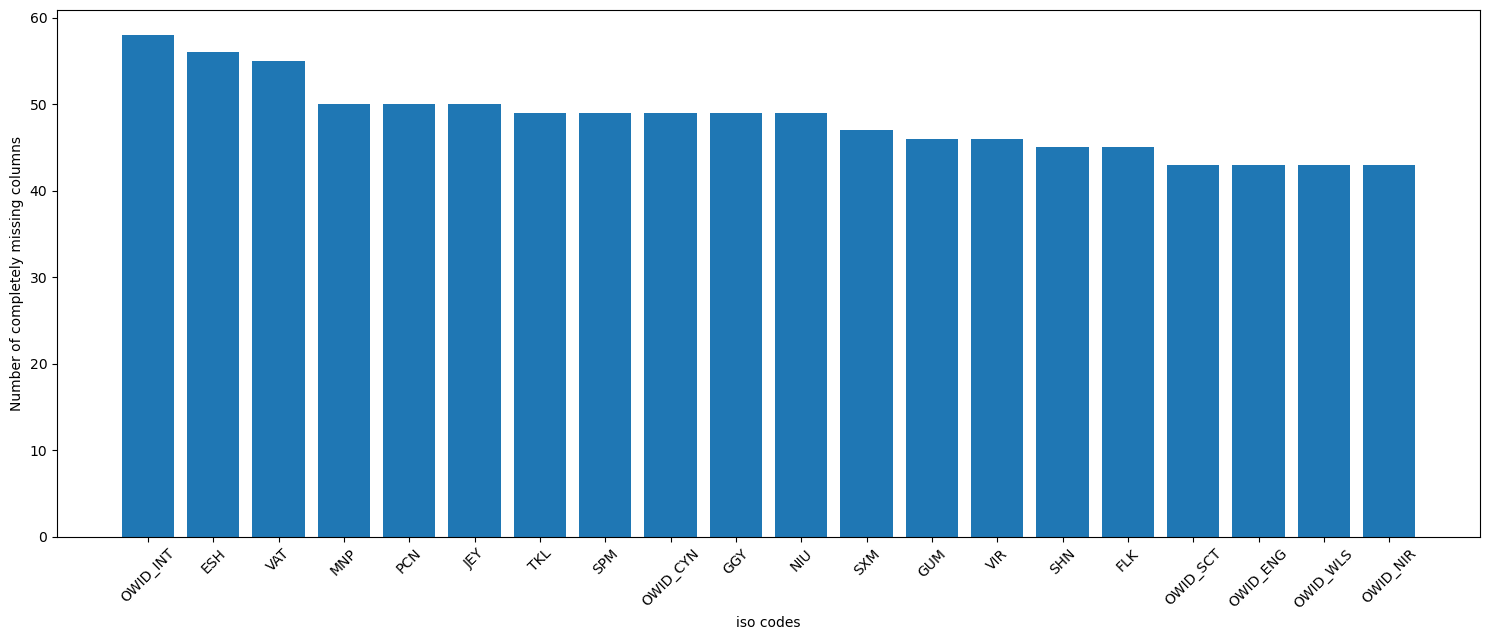

In [64]:
top20_missing_complete_loc= most_true_iso_code.head(20)
plt.figure(figsize=(15,6))
plt.bar(top20_missing_complete_loc.index, top20_missing_complete_loc)
plt.xlabel("iso codes")
plt.ylabel("Number of completely missing columns")
plt.tight_layout()
plt.xticks(rotation=45)

This topic of row/country deletion has to be visited again after deleting columns that can be deleted for sure.

### 3. Decision over keeping or deleting/imputing columns 0:16 (Nico)

#### 3.1 Missing data percentages (Nico)

In [65]:
columns_nico = data.columns[0:16]
missing_data_nico = df[columns_nico].isnull().sum() 
missing_data_nico_percentage = missing_data_nico / df.shape[0] * 100
print(missing_data_nico_percentage)

iso_code                            0.000000
continent                           5.611992
location                            0.000000
date                                0.000000
total_cases                         5.580139
new_cases                           5.704099
new_cases_smoothed                  6.166168
total_deaths                       13.142493
new_deaths                         13.181639
new_deaths_smoothed                13.636800
total_cases_per_million             6.008819
new_cases_per_million               6.132780
new_cases_smoothed_per_million      6.592930
total_deaths_per_million           13.566185
new_deaths_per_million             13.605330
new_deaths_smoothed_per_million    14.058572
dtype: float64


We can see that the first 4 columns are all (except continent) complete. This makes sense since they contain information about the country and date and did not have to be measured.
In general the amount of missing values is very low. For this reason and since cases and deaths are our Label, we cannot delete a column from this part. 

#### 3.2 Missing data per country

In the next step we will look if there are certain countries missing a huge amount of data. If that were the case we could delete the entries of those couuntries. To get an overview I created a plot for each continent containing all the countries and their respective missing entries in the first 16 columns.

In [66]:
#print(pd.DataFrame(filtering_missing_country('Finland'))['# of missing entries'][0:16]) 
#print(locations_per_continent('Europe'))

def missingdata_country_nico(continent):
    missing_data_countrylist_nico = []
    
    for country in locations_per_continent(continent):
        missing_data_country_nico = pd.DataFrame(filtering_missing_country(country))
        sum_missing_entries_nico = missing_data_country_nico['# of missing entries'][0:16].sum()
        missing_data_countrylist_nico.append({'Country': country, 'Missing Entries': sum_missing_entries_nico})
        #print(f"{country}: {sum_missing_entries_nico}")
    missing_data_country_df_nico = pd.DataFrame(missing_data_countrylist_nico)
    
    # Create countplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Country', y='Missing Entries', data=missing_data_country_df_nico)
    plt.title('Missing Entries per Country in ' + continent)
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.xlabel('Country')
    plt.ylabel('Number of Missing Entries')
    plt.tight_layout()
    safepoint = "../output/Missing_Data_Analysis/cols0-15/missing_data-" + continent +".png"
    plt.savefig(safepoint)


#for continent in continents_of_interest:
    #missingdata_country_nico(continent)

It is clearly visible that there are a few outliers, which have a lot of missing data.

In the next part of the code I wanted to check if the 'per million' numbers are deducted from the total numbers. This was done with the total cases and toatal cases per million.

In [67]:
for country in locations_per_continent('Europe'):
    country_entries_totalcases = df[df[columns_nico[2]] == country].iloc[:, 4]
    country_entries_totalcasesmillion = df[df[columns_nico[2]] == country].iloc[:, 10]
    country_entries_missing_totalcases = country_entries_totalcases.isnull().sum()
    country_entries_missing_totalcasesmillion = country_entries_totalcasesmillion.isnull().sum()
    print(country, country_entries_missing_totalcases, country_entries_missing_totalcasesmillion)

Albania 13 13
Andorra 0 0
Austria 0 0
Belarus 0 0
Belgium 0 0
Bosnia and Herzegovina 0 0
Bulgaria 0 0
Croatia 0 0
Cyprus 1 1
Czechia 0 0
Denmark 25 25
Estonia 24 24
Faeroe Islands 0 0
Finland 0 0
France 0 0
Germany 0 0
Gibraltar 0 0
Greece 0 0
Guernsey 695 695
Hungary 1 1
Iceland 0 0
Ireland 0 0
Isle of Man 0 0
Italy 0 0
Jersey 687 687
Latvia 5 5
Liechtenstein 0 0
Lithuania 0 0
Luxembourg 6 6
Malta 2 2
Moldova 0 0
Monaco 0 0
Montenegro 0 0
Netherlands 0 0
North Macedonia 0 0
Norway 1 1
Poland 0 0
Portugal 1 1
Romania 0 0
Russia 0 0
San Marino 0 0
Serbia 9 9
Slovakia 0 0
Slovenia 32 32
Spain 0 0
Sweden 0 0
Switzerland 0 0
Ukraine 0 0
United Kingdom 1 1
Vatican 0 0


These results make sense and show that the 'per million' entries are probably deducted from the total numbers. This means the amount of missing entries per country is the same in those two columns. This means we only have to concentrate on the column total cases, to get a feedback on how many entries in general are missing.

Now we try to find out how many percentage of the data are missing in each country in the columns total cases and total deaths.

In [68]:
def missingdata_cases_nico(continent):
    missing_data_caseslist_nico = []
    
    for country in locations_per_continent(continent):
        country_cases_nico = df[df[columns_nico[2]] == country].iloc[:, 4]
        country_casesmissing_nico = country_cases_nico.isnull().sum()
        country_casesmissing_nico_percentage = (country_casesmissing_nico / len(country_cases_nico)) * 100
        if country_casesmissing_nico_percentage == 100:
            print('Hier fehlen 100% von den Daten: ' + country)
        missing_data_caseslist_nico.append({'Country': country, 'Missing Entries': country_casesmissing_nico_percentage})
        #print(f"{country}: {sum_missing_entries_nico}")
    country_missingcases_df_nico = pd.DataFrame(missing_data_caseslist_nico)
    #print(country_missingcases_df_nico)
    
    # Create countplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Country', y='Missing Entries', data=country_missingcases_df_nico)
    plt.title('Percentage of Missing Entries in Total Cases per Country in ' + continent)
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.xlabel('Country')
    plt.ylabel('Percentage of Missing Entries in total cases')
    plt.tight_layout()
    safepoint = "../output/Missing_Data_Analysis/cols0-15/missing_totalcases-" + continent +".png"
    plt.savefig(safepoint)
    

#for continent in continents_of_interest:
    #missingdata_cases_nico(continent)

In all of these countries all entries in total cases are missing: Puerto Rico, Sint Maarten (Dutch part), United States Virgin Islands, Turkmenistan, Guernsey, Jersey, Western Sahara, Guam, Niue, Northern Mariana Islands, Pitcairn, Tokelau. I recommend to delete these countries.
Now we will have a look at the column total deaths:

In [69]:
def missingdata_deaths_nico(continent):
    missing_data_deathslist_nico = []
    
    for country in locations_per_continent(continent):
        country_deaths_nico = df[df[columns_nico[2]] == country].iloc[:, 7]
        country_deathsmissing_nico = country_deaths_nico.isnull().sum()
        country_deathsmissing_nico_percentage = (country_deathsmissing_nico / len(country_deaths_nico)) * 100
        if country_deathsmissing_nico_percentage == 100:
            print('Hier fehlen 100% von den Daten: ' + country)
        missing_data_deathslist_nico.append({'Country': country, 'Missing Entries': country_deathsmissing_nico_percentage})
        #print(f"{country}: {sum_missing_entries_nico}")
    country_missingdeaths_df_nico = pd.DataFrame(missing_data_deathslist_nico)
    #print(country_missingdeaths_df_nico)


    # Create countplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Country', y='Missing Entries', data=country_missingdeaths_df_nico)
    plt.title('Percentage of Missing Entries in Total Deaths per Country in ' + continent)
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.xlabel('Country')
    plt.ylabel('Percentage of Missing Entries in total deaths')
    plt.tight_layout()
    safepoint = "../output/Missing_Data_Analysis/cols0-15/missing_totaldeaths-" + continent +".png"
    plt.savefig(safepoint)
    

#for continent in continents_of_interest:
    #missingdata_deaths_nico(continent)

Countries in which all the entries in the column total deaths are missing are: Puerto Rico,Sint Maarten (Dutch part),United States Virgin Islands, Turkmenistan, Falkland Islands, Guernsey, Jersey, Vatican, Saint Helena, Western Sahara, Guam, Niue, Northern Mariana Islands, Pitcairn, Tokelau, Tuvalu. 

These contain also all the countries which were missing all entries in the column total cases. My recommendation is to delete these countries from the dataset.

Finally we will have a look at the regions in the OWID part of the dataset:

In [70]:
def missingdata_cases_nico_OWID():
    missing_data_caseslist_OWID_nico = []
    
    for location in loc_OWID:
        country_casesOWID_nico = df[df[columns_nico[2]] == location].iloc[:, 4]
        country_casesmissingOWID_nico = country_casesOWID_nico.isnull().sum()
        country_casesmissingOWID_nico_percentage = (country_casesmissingOWID_nico / len(country_casesOWID_nico)) * 100
        if country_casesmissingOWID_nico_percentage == 100:
            print('Hier fehlen 100% von den Daten: ' + location)
        missing_data_caseslist_OWID_nico.append({'Country': location, 'Missing Entries': country_casesmissingOWID_nico_percentage})
        #print(f"{country}: {sum_missing_entries_nico}")
    country_missingcasesOWID_df_nico = pd.DataFrame(missing_data_caseslist_OWID_nico)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Country', y='Missing Entries', data=country_missingcasesOWID_df_nico)
    plt.title('Percentage of Missing Entries in Total Cases per Location in OWID')
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.xlabel('Location')
    plt.ylabel('Percentage of Missing Entries in total cases')
    plt.tight_layout()
    safepoint = "../output/Missing_Data_Analysis/cols0-15/missing_totalcases-OWID.png"
    plt.savefig(safepoint)
    

#missingdata_cases_nico_OWID()

In [71]:
def missingdata_deaths_nico_OWID():
    missing_data_deathslist_OWID_nico = []
    
    for location in loc_OWID:
        country_deathsOWID_nico = df[df[columns_nico[2]] == location].iloc[:, 7]
        country_deathsmissingOWID_nico = country_deathsOWID_nico.isnull().sum()
        country_deathsmissingOWID_nico_percentage = (country_deathsmissingOWID_nico / len(country_deathsOWID_nico)) * 100
        if country_deathsmissingOWID_nico_percentage == 100:
            print('Hier fehlen 100% von den Daten: ' + location)
        missing_data_deathslist_OWID_nico.append({'Country': location, 'Missing Entries': country_deathsmissingOWID_nico_percentage})
        #print(f"{country}: {sum_missing_entries_nico}")
    country_missingdeathsOWID_df_nico = pd.DataFrame(missing_data_deathslist_OWID_nico)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Country', y='Missing Entries', data=country_missingdeathsOWID_df_nico)
    plt.title('Percentage of Missing Entries in Total Deaths per Location in OWID')
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
    plt.xlabel('Location')
    plt.ylabel('Percentage of Missing Entries in total deaths')
    plt.tight_layout()
    safepoint = "../output/Missing_Data_Analysis/cols0-15/missing_totaldeaths-OWID.png"
    plt.savefig(safepoint)
    

#missingdata_deaths_nico_OWID()

Here we can see that the regions England, Northern Ireland, Northern Cyprus, Scotland and Wales are missing all datapoints. I recommend to delete these regions too.

### 4. Decision over keeping or deleting/imputing columns 16:32 (Leon)

#### 4.1 Missing data percentages (Leon)

In [72]:
columns_leon = data.columns[16:32]
missing_percentages_leon = df[columns_leon].isnull().sum() / df.shape[0] *100
print(missing_percentages_leon)

reproduction_rate                     29.071218
icu_patients                          86.680969
icu_patients_per_million              86.680969
hosp_patients                         85.499699
hosp_patients_per_million             85.499699
weekly_icu_admissions                 96.655371
weekly_icu_admissions_per_million     96.655371
weekly_hosp_admissions                92.091861
weekly_hosp_admissions_per_million    92.091861
total_tests                           69.532980
new_tests                             71.061953
total_tests_per_thousand              69.532980
new_tests_per_thousand                71.061953
new_tests_smoothed                    60.100473
new_tests_smoothed_per_thousand       60.100473
positive_rate                         63.185284
dtype: float64


At first glance it only makes sense to keep reproduction rate and maybe the ones with percentages of missing data below 75%

#### 4.2 Visualization of variables of Interest (Leon)

Visualizing all my variables for three countries to determine usefulness and worth of imputation.

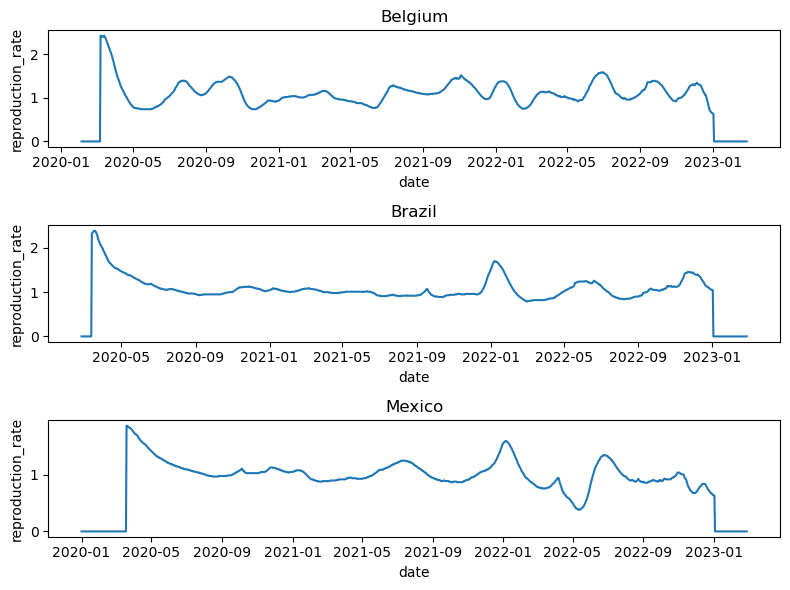

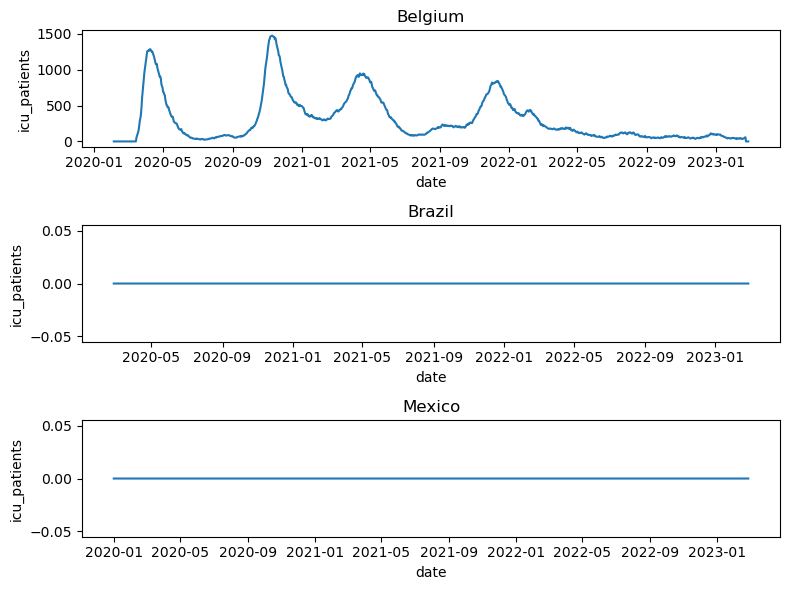

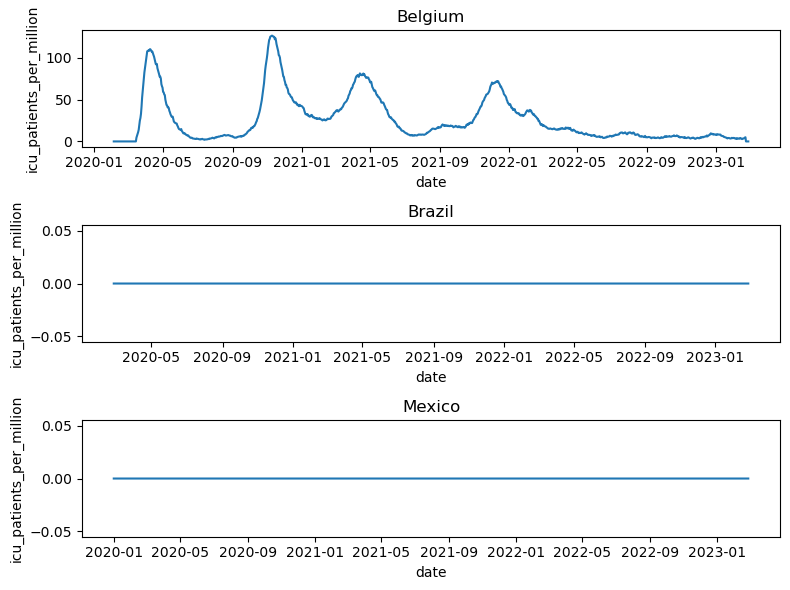

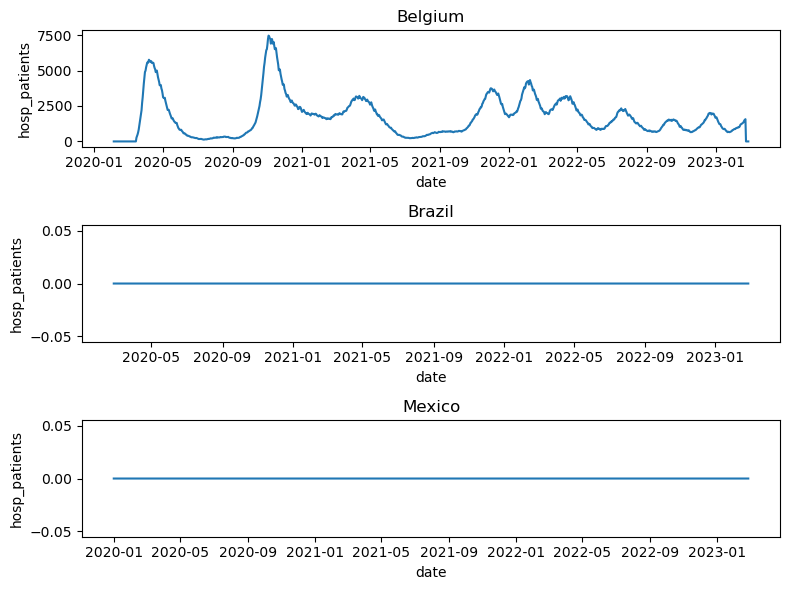

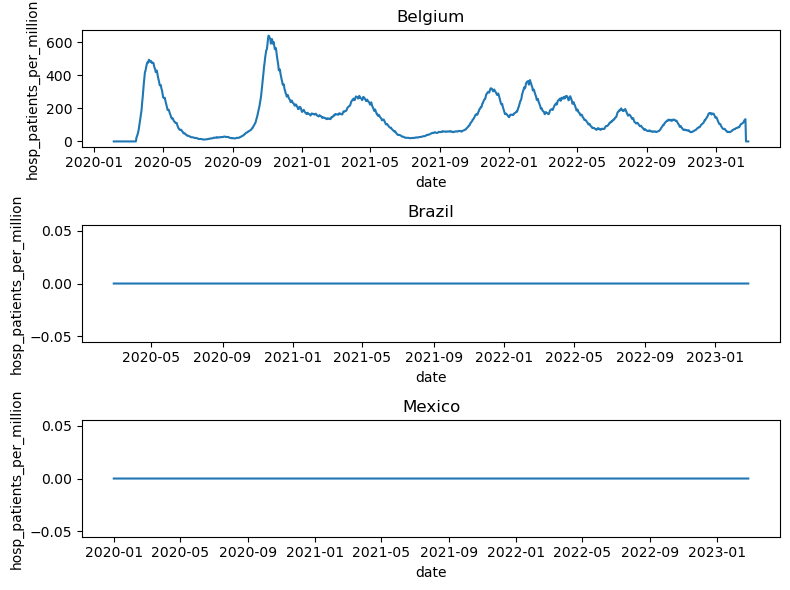

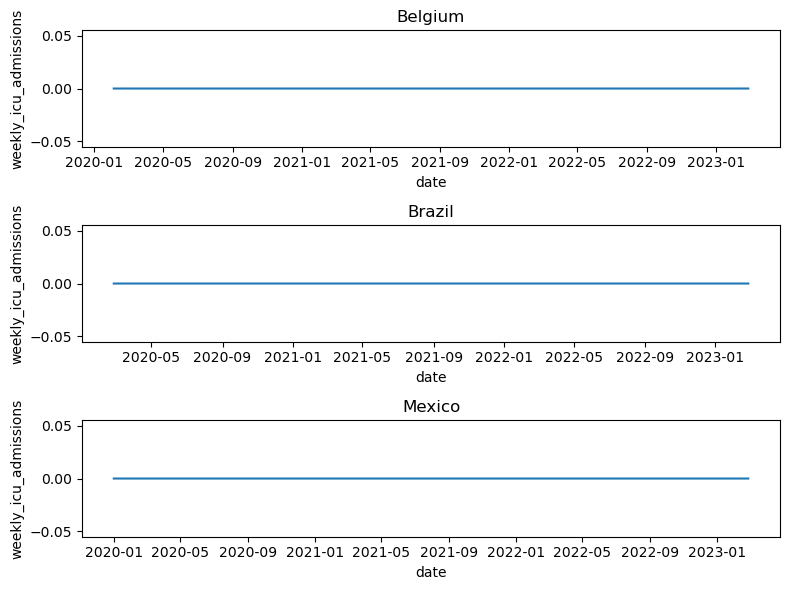

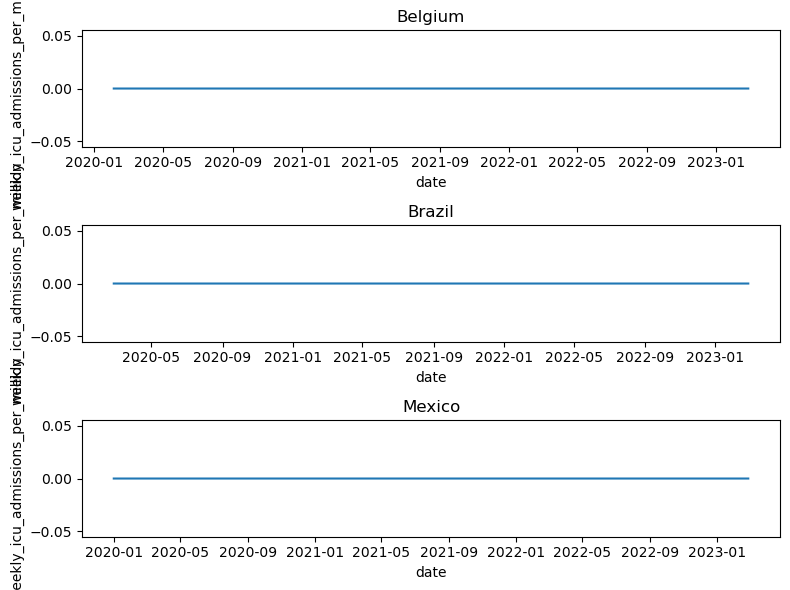

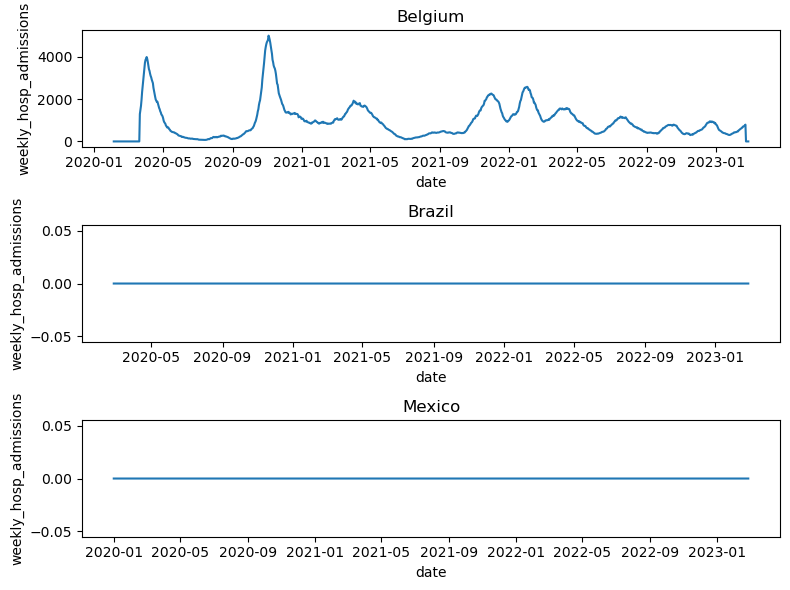

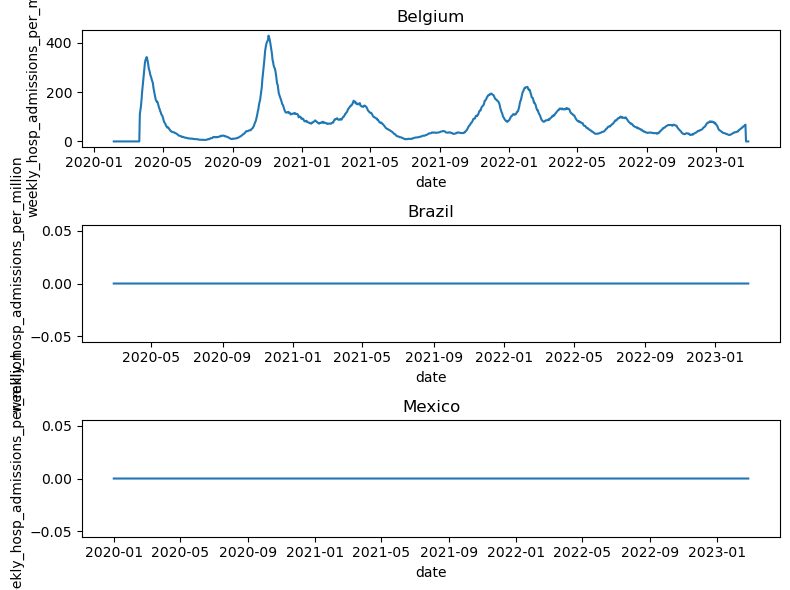

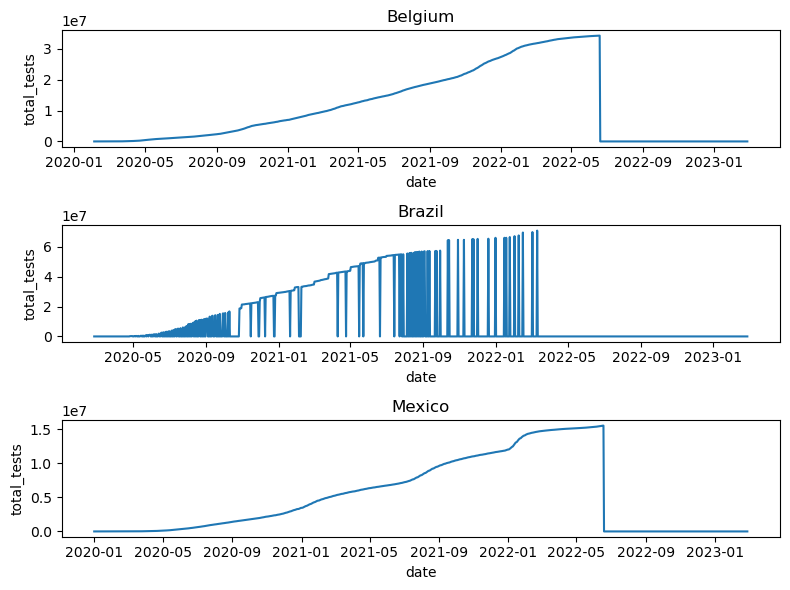

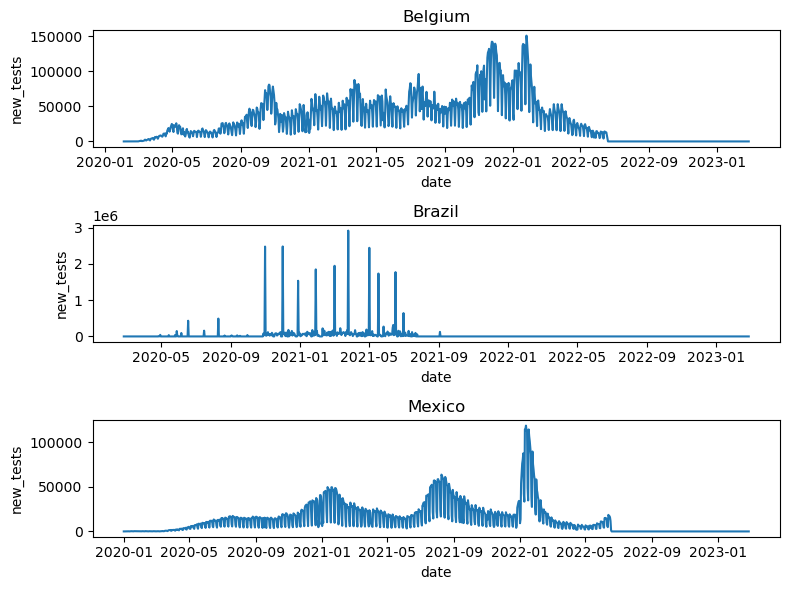

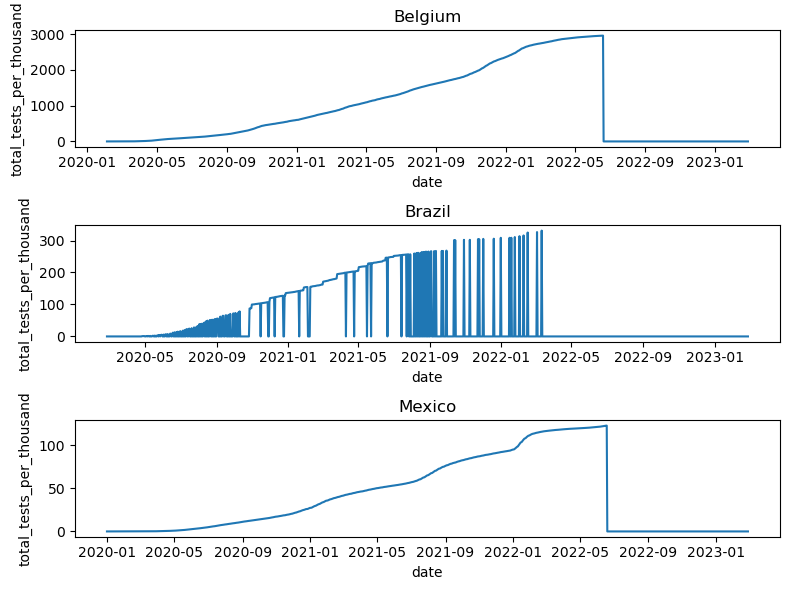

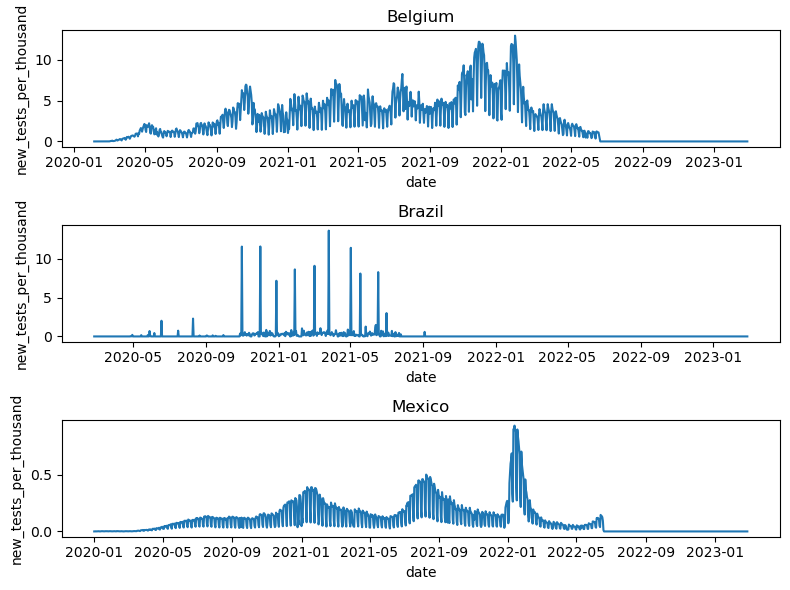

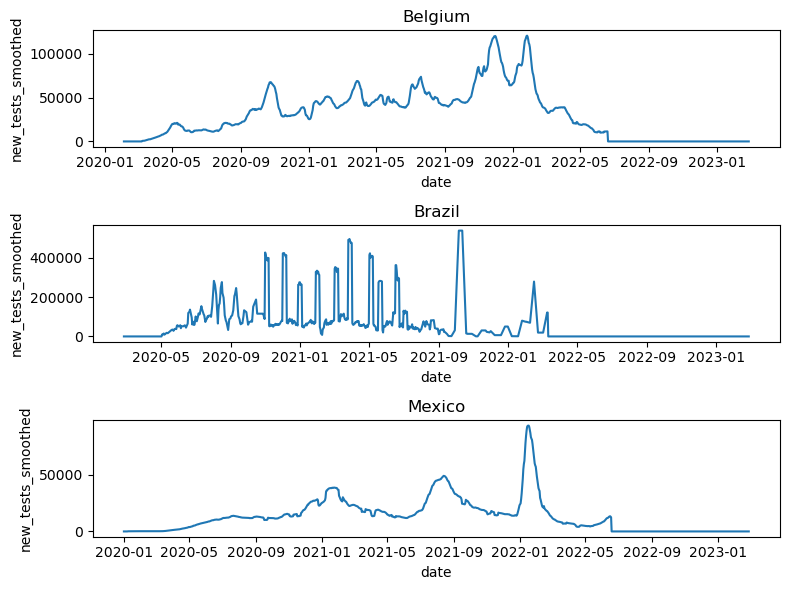

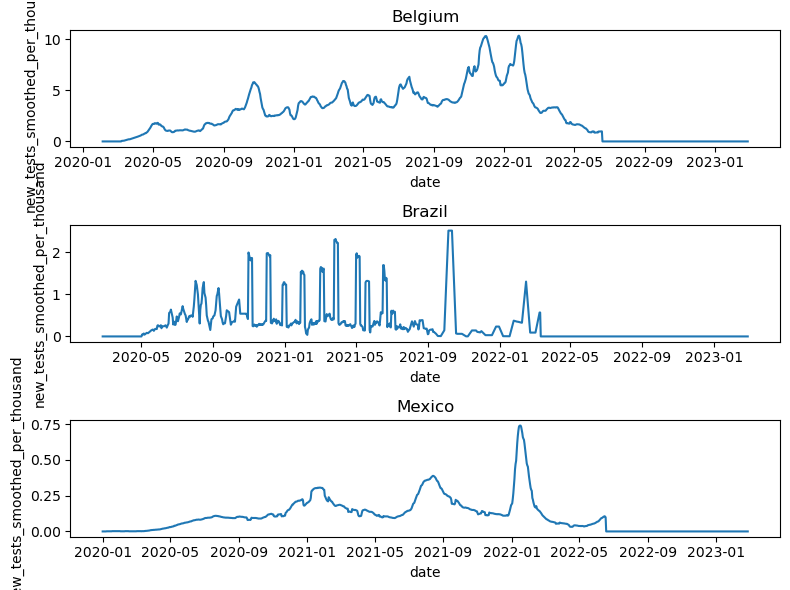

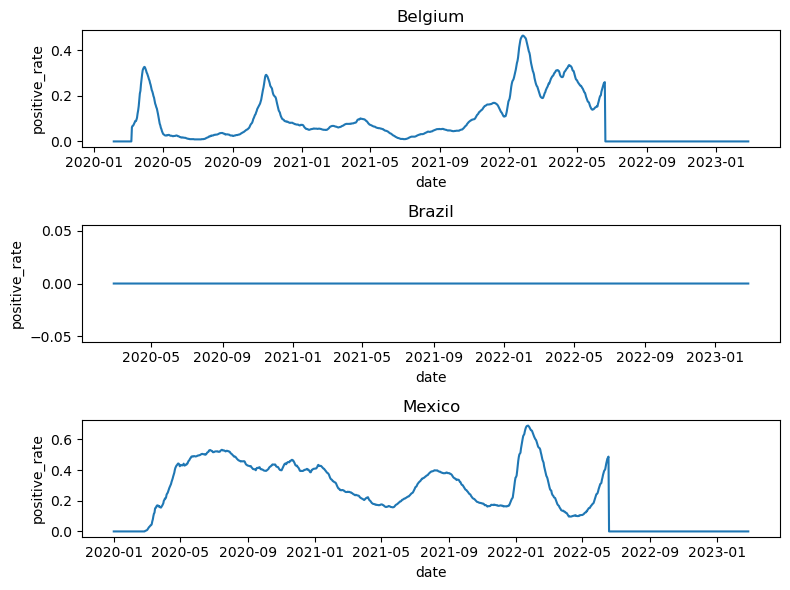

In [73]:
for column in columns_leon:    
    belgium_data = df.groupby("iso_code").get_group("BEL")
    belgium = belgium_data[column].fillna(0)

    brazil_data = df.groupby("iso_code").get_group("BRA")
    brazil = brazil_data[column].fillna(0)

    mexico_data = df.groupby("iso_code").get_group("MEX")
    mexico = mexico_data[column].fillna(0)

    fig, axs = plt.subplots(3, 1, figsize=(8, 6))

    # Plot data on each subplot
    axs[0].plot(belgium_data["date"], belgium)
    axs[0].set_xlabel("date")
    axs[0].set_ylabel(column)
    axs[0].set_title("Belgium")

    axs[1].plot(brazil_data["date"], brazil)
    axs[1].set_xlabel("date")
    axs[1].set_ylabel(column)
    axs[1].set_title("Brazil")

    axs[2].plot(mexico_data["date"], mexico)
    axs[2].set_xlabel("date")
    axs[2].set_ylabel(column)
    axs[2].set_title("Mexico")

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    safepoint = "../output/Missing_Data_Analysis/cols16-32/missing_data-" + column +".png"
    #plt.savefig(safepoint)

Some of them seem to be imputable. We will keep all variables for the cases since we will target number of cases in our prediction. The ones that were missing 75% plus of their values are also the ones that look like they will not be imputable by any means. Brazil also seems to be lacking positive rate completely (which was under 75% missing values but not in the cases group). Positive rate and reproduction rate are the only ones left to determine whether we will keep them or delete them (The ones with 75% plus missing will most likely be deleted).

#### 4.3 How many countries are entirely missing my variables of interest? 

In [74]:
all_countries = list(df.groupby("iso_code").groups.keys())
for column in columns_leon:
    grouped_by_iso = df.groupby("iso_code")
    nan_counts = grouped_by_iso[column].apply(lambda x: x.isnull().all()).sum()
    print("Percentage of countries that completely miss all values of", column,":", nan_counts/len(all_countries)*100)

Percentage of countries that completely miss all values of reproduction_rate : 21.370967741935484
Percentage of countries that completely miss all values of icu_patients : 83.06451612903226
Percentage of countries that completely miss all values of icu_patients_per_million : 83.06451612903226
Percentage of countries that completely miss all values of hosp_patients : 82.66129032258065
Percentage of countries that completely miss all values of hosp_patients_per_million : 82.66129032258065
Percentage of countries that completely miss all values of weekly_icu_admissions : 91.53225806451613
Percentage of countries that completely miss all values of weekly_icu_admissions_per_million : 91.53225806451613
Percentage of countries that completely miss all values of weekly_hosp_admissions : 85.88709677419355
Percentage of countries that completely miss all values of weekly_hosp_admissions_per_million : 85.88709677419355
Percentage of countries that completely miss all values of total_tests : 24.19

This again shows that the variables that miss more than 75% of their values are also very much the ones where the highest percentage of countries do not have any values of them stored at all. (90% means that 90 percent of all countries do not have a single value but Nan for this column)

If we want to keep all variables containing the tests, we would have to delete rows that contain only Nan for those columns. For what countries is that the case?

In [75]:
test_variables = [var for var in columns_leon if 'test' in var]
empty_countries_test = []
for column in test_variables:  
    test_nan_countries = grouped_by_iso[column].apply(lambda x: x.isnull().all())
    test_nan_countries_true = test_nan_countries[test_nan_countries == True]
    empty_countries_test.append(test_nan_countries_true.index)
empty_countries_test


[Index(['BES', 'COK', 'CPV', 'FLK', 'FSM', 'GGY', 'GRL', 'HND', 'IMN', 'JEY', 'KGZ', 'KIR', 'LBY', 'MAC', 'MCO', 'MDA', 'MNE', 'MSR', 'NCL', 'NIU', 'NRU', 'OWID_AFR', 'OWID_ASI', 'OWID_CYN', 'OWID_ENG', 'OWID_EUN', 'OWID_EUR', 'OWID_HIC', 'OWID_INT', 'OWID_LIC', 'OWID_LMC', 'OWID_NAM', 'OWID_NIR', 'OWID_OCE', 'OWID_SAM', 'OWID_SCT', 'OWID_UMC', 'OWID_WLS', 'OWID_WRL', 'PCN', 'PSE', 'PYF', 'SGP', 'SHN', 'SLB', 'SMR', 'SPM', 'SXM', 'SYC', 'TCA', 'TJK', 'TKL', 'TKM', 'TON', 'TUV', 'UZB', 'VAT', 'VEN', 'WLF', 'WSM'], dtype='object', name='iso_code'),
 Index(['AFG', 'AIA', 'AND', 'ATG', 'BEN', 'BES', 'CAF', 'CHN', 'CMR', 'COD', 'COG', 'COK', 'COM', 'DEU', 'DZA', 'EGY', 'ERI', 'ESH', 'FLK', 'FSM', 'GGY', 'GIN', 'GMB', 'GRL', 'GUY', 'HKG', 'HND', 'IMN', 'JEY', 'KGZ', 'KIR', 'LBR', 'MAC', 'MCO', 'MNE', 'MSR', 'MUS', 'NCL', 'NIC', 'NIU', 'NRU', 'OMN', 'OWID_AFR', 'OWID_ASI', 'OWID_CYN', 'OWID_ENG', 'OWID_EUN', 'OWID_EUR', 'OWID_HIC', 'OWID_INT', 'OWID_LIC', 'OWID_LMC', 'OWID_NAM', 'OWID_NIR', '

Now let's see what country is missing how many test variables:

In [76]:
counter_dict = {}
for countries in empty_countries_test:
    for country in countries:
        existing_country = counter_dict.get(country)
        if existing_country is not None:
            counter_dict[country] += 1
        else:
            counter_dict[country] = 1
sorted_counter_dict = dict(sorted(counter_dict.items(), key=lambda item:item[1]))
print(sorted_counter_dict)
sorted_counter_dict.keys()


{'CPV': 2, 'LBY': 2, 'MDA': 2, 'PSE': 2, 'SGP': 2, 'AFG': 2, 'AIA': 2, 'AND': 2, 'ATG': 2, 'CAF': 2, 'CHN': 2, 'CMR': 2, 'COD': 2, 'COG': 2, 'COM': 2, 'DEU': 2, 'EGY': 2, 'GIN': 2, 'GMB': 2, 'GUY': 2, 'HKG': 2, 'MUS': 2, 'NIC': 2, 'OMN': 2, 'PER': 2, 'PLW': 2, 'POL': 2, 'ROU': 2, 'SLE': 2, 'SOM': 2, 'SYR': 2, 'TCD': 2, 'TZA': 2, 'VUT': 2, 'YEM': 2, 'ABW': 2, 'BRN': 2, 'BEN': 4, 'DZA': 4, 'ERI': 4, 'ESH': 4, 'LBR': 4, 'PNG': 4, 'SDN': 4, 'VGB': 4, 'BES': 6, 'COK': 6, 'FLK': 6, 'FSM': 6, 'GGY': 6, 'GRL': 6, 'HND': 6, 'IMN': 6, 'JEY': 6, 'KGZ': 6, 'KIR': 6, 'MAC': 6, 'MCO': 6, 'MNE': 6, 'MSR': 6, 'NCL': 6, 'NIU': 6, 'NRU': 6, 'OWID_AFR': 6, 'OWID_ASI': 6, 'OWID_CYN': 6, 'OWID_ENG': 6, 'OWID_EUN': 6, 'OWID_EUR': 6, 'OWID_HIC': 6, 'OWID_INT': 6, 'OWID_LIC': 6, 'OWID_LMC': 6, 'OWID_NAM': 6, 'OWID_NIR': 6, 'OWID_OCE': 6, 'OWID_SAM': 6, 'OWID_SCT': 6, 'OWID_UMC': 6, 'OWID_WLS': 6, 'OWID_WRL': 6, 'PCN': 6, 'PYF': 6, 'SHN': 6, 'SLB': 6, 'SMR': 6, 'SPM': 6, 'SXM': 6, 'SYC': 6, 'TCA': 6, 'TJK': 6,

dict_keys(['CPV', 'LBY', 'MDA', 'PSE', 'SGP', 'AFG', 'AIA', 'AND', 'ATG', 'CAF', 'CHN', 'CMR', 'COD', 'COG', 'COM', 'DEU', 'EGY', 'GIN', 'GMB', 'GUY', 'HKG', 'MUS', 'NIC', 'OMN', 'PER', 'PLW', 'POL', 'ROU', 'SLE', 'SOM', 'SYR', 'TCD', 'TZA', 'VUT', 'YEM', 'ABW', 'BRN', 'BEN', 'DZA', 'ERI', 'ESH', 'LBR', 'PNG', 'SDN', 'VGB', 'BES', 'COK', 'FLK', 'FSM', 'GGY', 'GRL', 'HND', 'IMN', 'JEY', 'KGZ', 'KIR', 'MAC', 'MCO', 'MNE', 'MSR', 'NCL', 'NIU', 'NRU', 'OWID_AFR', 'OWID_ASI', 'OWID_CYN', 'OWID_ENG', 'OWID_EUN', 'OWID_EUR', 'OWID_HIC', 'OWID_INT', 'OWID_LIC', 'OWID_LMC', 'OWID_NAM', 'OWID_NIR', 'OWID_OCE', 'OWID_SAM', 'OWID_SCT', 'OWID_UMC', 'OWID_WLS', 'OWID_WRL', 'PCN', 'PYF', 'SHN', 'SLB', 'SMR', 'SPM', 'SXM', 'SYC', 'TCA', 'TJK', 'TKL', 'TKM', 'TON', 'TUV', 'UZB', 'VAT', 'VEN', 'WLF', 'WSM'])

Countries missing all 6 columns:

In [77]:
countries_without_tests = [key for key, value in counter_dict.items() if value == 6]
countries_without_tests

['BES',
 'COK',
 'FLK',
 'FSM',
 'GGY',
 'GRL',
 'HND',
 'IMN',
 'JEY',
 'KGZ',
 'KIR',
 'MAC',
 'MCO',
 'MNE',
 'MSR',
 'NCL',
 'NIU',
 'NRU',
 'OWID_AFR',
 'OWID_ASI',
 'OWID_CYN',
 'OWID_ENG',
 'OWID_EUN',
 'OWID_EUR',
 'OWID_HIC',
 'OWID_INT',
 'OWID_LIC',
 'OWID_LMC',
 'OWID_NAM',
 'OWID_NIR',
 'OWID_OCE',
 'OWID_SAM',
 'OWID_SCT',
 'OWID_UMC',
 'OWID_WLS',
 'OWID_WRL',
 'PCN',
 'PYF',
 'SHN',
 'SLB',
 'SMR',
 'SPM',
 'SXM',
 'SYC',
 'TCA',
 'TJK',
 'TKL',
 'TKM',
 'TON',
 'TUV',
 'UZB',
 'VAT',
 'VEN',
 'WLF',
 'WSM']

If we wanted to keep all test variables, we will have to delete all of those countries listed above. We will for sure delete the countries missing all 6 columns.

### 5. Decision over keeping or deleting/imputing columns 32:48 (Florin)

#### 5.1 Functions for analysis

##### 5.11 Function to replace missing data with zeros

In [78]:
""" #here is how to replace the mssing values with zero values
def replace_missing_data(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_Italy.reset_index(drop=True)
    missing_vals = ["NA", "", None, np.NaN]
    missing_country = filtered_country.isin(missing_vals) """


' #here is how to replace the mssing values with zero values\ndef replace_missing_data(country):\n    filtered_country = data_without_OWID.loc[df[\'location\'] == country]\n    filtered_country = filtered_Italy.reset_index(drop=True)\n    missing_vals = ["NA", "", None, np.NaN]\n    missing_country = filtered_country.isin(missing_vals) '

##### 5.12 Function for missing values excluding missing at the end and at the beginning for a specific country

In [79]:
def filtering_missing_country(country):
    filtered_country = data_without_OWID.loc[df['location'] == country]
    filtered_country = filtered_country.reset_index(drop=True)
    filtered_country_summary = filtered_country.isnull().sum()
    first_valid_indices_country = filtered_country.apply(lambda x: x.first_valid_index())
    last_valid_indices_country = filtered_country.apply(lambda x: x.last_valid_index())
    length = len(filtered_country) - 1

    filtered_country_summary_df = filtered_country_summary.to_frame()
    first_valid_indices_country_df = first_valid_indices_country.to_frame()
    last_valid_indices_country_df = last_valid_indices_country.to_frame()
    list_of_dataframes = [filtered_country_summary_df, first_valid_indices_country_df, last_valid_indices_country]

    comparison_country = pd.merge(filtered_country_summary_df, first_valid_indices_country_df, left_index=True, right_index=True)
    comparison_country = comparison_country.rename(columns={"0_x": '# of missing entries', "0_y": "first entry"})
    diff_first = filtered_country_summary_df - first_valid_indices_country_df
    last_valid_indices_country_df_diff = length - last_valid_indices_country_df
    diff_overall = filtered_country_summary_df - first_valid_indices_country_df - last_valid_indices_country_df_diff
    comparison_country = comparison_country.assign(diff_first = diff_first, \
                last_entry= last_valid_indices_country_df, diff_last = last_valid_indices_country_df_diff, \
                diff_overall = diff_overall)
    return (comparison_country)

In [80]:
filtering_missing_country("Germany")

# of missing entries  first entry  diff_first  last_entry  diff_last  diff_overall
iso_code                                                       0          0.0         0.0      1127.0        0.0           0.0
continent                                                      0          0.0         0.0      1127.0        0.0           0.0
location                                                       0          0.0         0.0      1127.0        0.0           0.0
date                                                           0          0.0         0.0      1127.0        0.0           0.0
total_cases                                                    0          0.0         0.0      1127.0        0.0           0.0
new_cases                                                      0          0.0         0.0      1127.0        0.0           0.0
new_cases_smoothed                                             5          5.0         0.0      1127.0        0.0           0.0
total_deaths                                                  42         42.0         0.0      1127.0        0.0           0.0
new_deaths                                                    45         42.0         3.0      1127.0        0.0           3.0
new_deaths_smoothed                                           50         47.0         3.0      1127.0        0.0           3.0
total_cases_per_million                                        0          0.0         0.0      1127.0        0.0           0.0
new_cases_per_million                                          0          0.0         0.0      1127.0        0.0           0.0
new_cases_smoothed_per_million                                 5          5.0         0.0      1127.0        0.0           0.0
total_deaths_per_million                                      42         42.0         0.0      1127.0        0.0           0.0
new_deaths_per_million                                        45         42.0         3.0      1127.0        0.0           3.0
new_deaths_smoothed_per_million                               50         47.0         3.0      1127.0        0.0           3.0
reproduction_rate                                             91         35.0        56.0      1071.0       56.0           0.0
icu_patients                                                  54         53.0         1.0      1126.0        1.0           0.0
icu_patients_per_million                                      54         53.0         1.0      1126.0        1.0           0.0
hosp_patients                                               1128          NaN         NaN         NaN        NaN           NaN
hosp_patients_per_million                                   1128          NaN         NaN         NaN        NaN           NaN
weekly_icu_admissions                                        557        555.0         2.0      1125.0        2.0           0.0
weekly_icu_admissions_per_million                            557        555.0         2.0      1125.0        2.0           0.0
weekly_hosp_admissions                                        34         34.0         0.0      1127.0        0.0           0.0
weekly_hosp_admissions_per_million                            34         34.0         0.0      1127.0        0.0           0.0
total_tests                                                 1010         48.0       962.0       867.0      260.0         702.0
new_tests                                                   1128          NaN         NaN         NaN        NaN           NaN
total_tests_per_thousand                                    1010         48.0       962.0       867.0      260.0         702.0
new_tests_per_thousand                                      1128          NaN         NaN         NaN        NaN           NaN
new_tests_smoothed                                           315         55.0       260.0       867.0      260.0           0.0
new_tests_smoothed_per_thousand                              315         55.0       260.0       867.0      

In [81]:
data_countr = data_without_OWID.loc[df['location'] == "Germany"]
columns_to_print = ["location", "tests_per_case"]
data_countr = data_countr[columns_to_print]
data_countr.head(2000)

location  tests_per_case
86939  Germany             NaN
86940  Germany             NaN
86941  Germany             NaN
86942  Germany             NaN
86943  Germany             NaN
...        ...             ...
88062  Germany             NaN
88063  Germany             NaN
88064  Germany             NaN
88065  Germany             NaN
88066  Germany             NaN

[1128 rows x 2 columns]

##### 5.13 Function total diff for many countries

In [82]:
def locations_per_continent(continent):
    filtered_continent = data_without_OWID.loc[df['continent'] == continent]
    unique_values_continent = filtered_continent['location'].unique()
    return unique_values_continent

In [83]:
unique_locations_Europe = locations_per_continent("Europe")
empty_df = pd.DataFrame()

def several_countries_diff_overall_specific_columns(list_of_countries, empty_dataframe):
    count = 0
    for i in (list_of_countries):
        country = filtering_missing_country(i)
        #print (country)
        country_diff_overall_column = country["diff_overall"]
        #print (country_diff_overall_column)
        country_diff_overall_column_df = country_diff_overall_column.to_frame()
        if count == 0:
            combined_df = pd.concat([empty_df, country_diff_overall_column_df], axis=1)
            count = 1
        elif count > 0:
            combined_df = pd.concat([combined_df, country_diff_overall_column_df], axis=1)
        #print (country_diff_overall_column_df)
        combined_df = combined_df.rename(columns={'diff_overall': i})
    return (combined_df)

output = several_countries_diff_overall_specific_columns(unique_locations_Europe, empty_df)
output.iloc[list(range(2, 3)) + list(range(32, 48)),:]

Albania  Andorra  Austria  Belarus  Belgium  Bosnia and Herzegovina  Bulgaria  Croatia  Cyprus  Czechia  Denmark  Estonia  Faeroe Islands  Finland  France  Germany  Gibraltar  Greece  Guernsey  Hungary  Iceland  Ireland  Isle of Man  Italy  Jersey  Latvia  Liechtenstein  Lithuania  Luxembourg  Malta  Moldova  Monaco  Montenegro  Netherlands  North Macedonia  Norway  Poland  Portugal  Romania  Russia  San Marino  Serbia  Slovakia  Slovenia  Spain  Sweden  Switzerland  Ukraine  United Kingdom  Vatican
location                                        0.0      0.0      0.0      0.0      0.0                     0.0       0.0      0.0     0.0      0.0      0.0      0.0             0.0      0.0     0.0      0.0        0.0     0.0       0.0      0.0      0.0      0.0          0.0    0.0     0.0     0.0            0.0        0.0         0.0    0.0      0.0     0.0         0.0          0.0              0.0     0.0     0.0       0.0      0.0     0.0         0.0     0.0       0.0       0.0    0.0     0.0          0.0      0.0             0.0      0.0
tests_per_case                                  1.0      1.0      0.0      0.0      0.0                     1.0       0.0      0.0     0.0      0.0      1.0      0.0             0.0      0.0     0.0    702.0        0.0     0.0       NaN      2.0      NaN     54.0          NaN    1.0     NaN     0.0           16.0        0.0         1.0    1.0      0.0     NaN         NaN          0.0              0.0     1.0     0.0       1.0      0.0     0.0         NaN     0.0       6.0       3.0    0.0     1.0          0.0      0.0             3.0      NaN
tests_units                                     0.0      0.0      0.0      0.0      0.0                     0.0       0.0      0.0     0.0      0.0      0.0      0.0             0.0      0.0     0.0      0.0        0.0     0.0       NaN      0.0      0.0      0.0          NaN    0.0     NaN     0.0            0.0        0.0         0.0    0.0      0.0     NaN         NaN          0.0              0.0     0.0     0.0       0.0      0.0     0.0         NaN     0.0       0.0       0.0    0.0     0.0          0.0      0.0             0.0      NaN
total_vaccinations                            480.0    676.0      0.0    699.0      2.0                   333.0      60.0    138.0   535.0      3.0      6.0      1.0           231.0    625.0     0.0      0.0      446.0    20.0     580.0    544.0    313.0     13.0        253.0    0.0   555.0    11.0          348.0       53.0        86.0   50.0    415.0   331.0        68.0        516.0            521.0    14.0    92.0     660.0      1.0   337.0       329.0   295.0     500.0      18.0  441.0   668.0         14.0      8.0             0.0      NaN
people_vaccinated                             533.0    681.0      0.0    701.0      2.0                   331.0     524.0    148.0   554.0      3.0      6.0      1.0           231.0    664.0     0.0      0.0      449.0    20.0     684.0    325.0    313.0     13.0        260.0    0.0   555.0    11.0          348.0       53.0        86.0   51.0    574.0   269.0        68.0        516.0            532.0    14.0    98.0     660.0    496.0   344.0       372.0   295.0     500.0      18.0  437.0   668.0         14.0      8.0             1.0      NaN
people_fully_vaccinated                       520.0    645.0      0.0    630.0      2.0                   271.0      90.0    213.0   528.0      3.0     18.0      1.0           231.0    633.0     0.0      0.0      444.0    20.0     683.0    325.0    295.0     13.0        258.0    0.0   555.0     1.0          328.0       50.0       674.0   49.0    405.0   269.0        54.0        498.0            464.0     6.0    94.0     660.0      1.0   282.0       371.0   281.0     488.0      18.0  430.0   655.0         14.0      9.0             0.0      NaN
total_boosters                                380.0    393.0      0.0    388.0      2.0                    55.0      69.0      0.0   374.0      3.0      0.0      0.0            33.0    402.0     0.0   

In [84]:
threshhold = 50
unique_locations_world = data_without_OWID['location'].unique()
empty_df = pd.DataFrame()
dataset = unique_locations_world

In [85]:
def countries_to_check(column, threshhold_value):
    output = several_countries_diff_overall_specific_columns(dataset, empty_df)
    output_filter = output.loc[column] #filtering for the specific column that we are interested in
    output_filter = output_filter.to_frame()
    output_filter = output_filter.dropna(axis = 0)
    output_filter = output_filter[output_filter > threshhold_value]
    output_filter = output_filter.dropna(axis = 0)
    return output_filter

In [86]:
def countries_eligible(column, threshhold_value):
    output = several_countries_diff_overall_specific_columns(dataset, empty_df)
    output_filter = output.loc[column] #filtering for the specific column that we are interested in
    output_filter = output_filter.to_frame()
    output_filter = output_filter.dropna(axis = 0)
    output_filter = output_filter[output_filter < threshhold_value]
    output_filter = output_filter.dropna(axis = 0)
    return output_filter

In [87]:
data_countr = data_without_OWID.loc[df['location'] == "Germany"]
columns_to_print = ["date", "total_vaccinations"]
data_countr = data_countr[columns_to_print]
data_countr.head(2000)

date  total_vaccinations
86939 2020-01-27                 NaN
86940 2020-01-28                 NaN
86941 2020-01-29                 NaN
86942 2020-01-30                 NaN
86943 2020-01-31                 NaN
...          ...                 ...
88062 2023-02-23         192097974.0
88063 2023-02-24         192102332.0
88064 2023-02-25         192103430.0
88065 2023-02-26         192104063.0
88066 2023-02-27                 NaN

[1128 rows x 2 columns]

##### 5.14 Function to check whether there is some pattern in how often the data is missing

In [88]:
def regularity(country, column): #this function is to check how regular the reporting takes place
    data_countr = data_without_OWID.loc[df['location'] == country] #filtering the country of interest, including all columns
    data_countr = data_countr[column] #+filtering the column of interest for the country of interest
    data_countr = data_countr.reset_index(drop=True) #resetting the index to 0
    data_countr = data_countr.to_frame() #converting it to a pandas dataframe
    first_valid_index = data_countr.apply(lambda x: x.first_valid_index()) #finding the first valid index
    first_valid_index = first_valid_index[0] #isolating just the index number
    last_valid_index = data_countr.apply(lambda x: x.last_valid_index()) #finding the last valid index
    last_valid_index = last_valid_index[0] #isolating the last valid index number
    data_countr_filtered = data_countr.iloc[first_valid_index:last_valid_index, :] #filtering the data so we disregard the first values where we have no value and the last values
    data_countr_filtered = data_countr_filtered.isna().sum(axis=1) #1 where there is no data and zero where there is data
    data_countr_filtered = data_countr_filtered.replace({0: 1, 1: 0})
    return data_countr_filtered

#regularity("Germany", "total_vaccinations")

##### 5.15 Function to transform the dataset of regularity before plotting

In [89]:
plt.figure(figsize=(8, 4))
plotting_values = np.array([1,0,1,0,0,0,1,1,1,0,1,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0])
Brazil_data = regularity("Brazil", "total_vaccinations")
Brazil_data = Brazil_data.values

def transform(plotting_values):
    count_month = 2
    counter = 0
    for i in range(len(plotting_values)):
        counter += 1
        if plotting_values[i] == 1:
            plotting_values[i] = count_month
        #print (plotting_values[i])
        if counter == 30:
            counter = 0
            count_month += 1
            #print ("printing : ", count_month)
    return plotting_values

transform(plotting_values)

array([2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 4, 4, 4, 0])

<Figure size 800x400 with 0 Axes>

##### 5.16 Function to plot these patterns

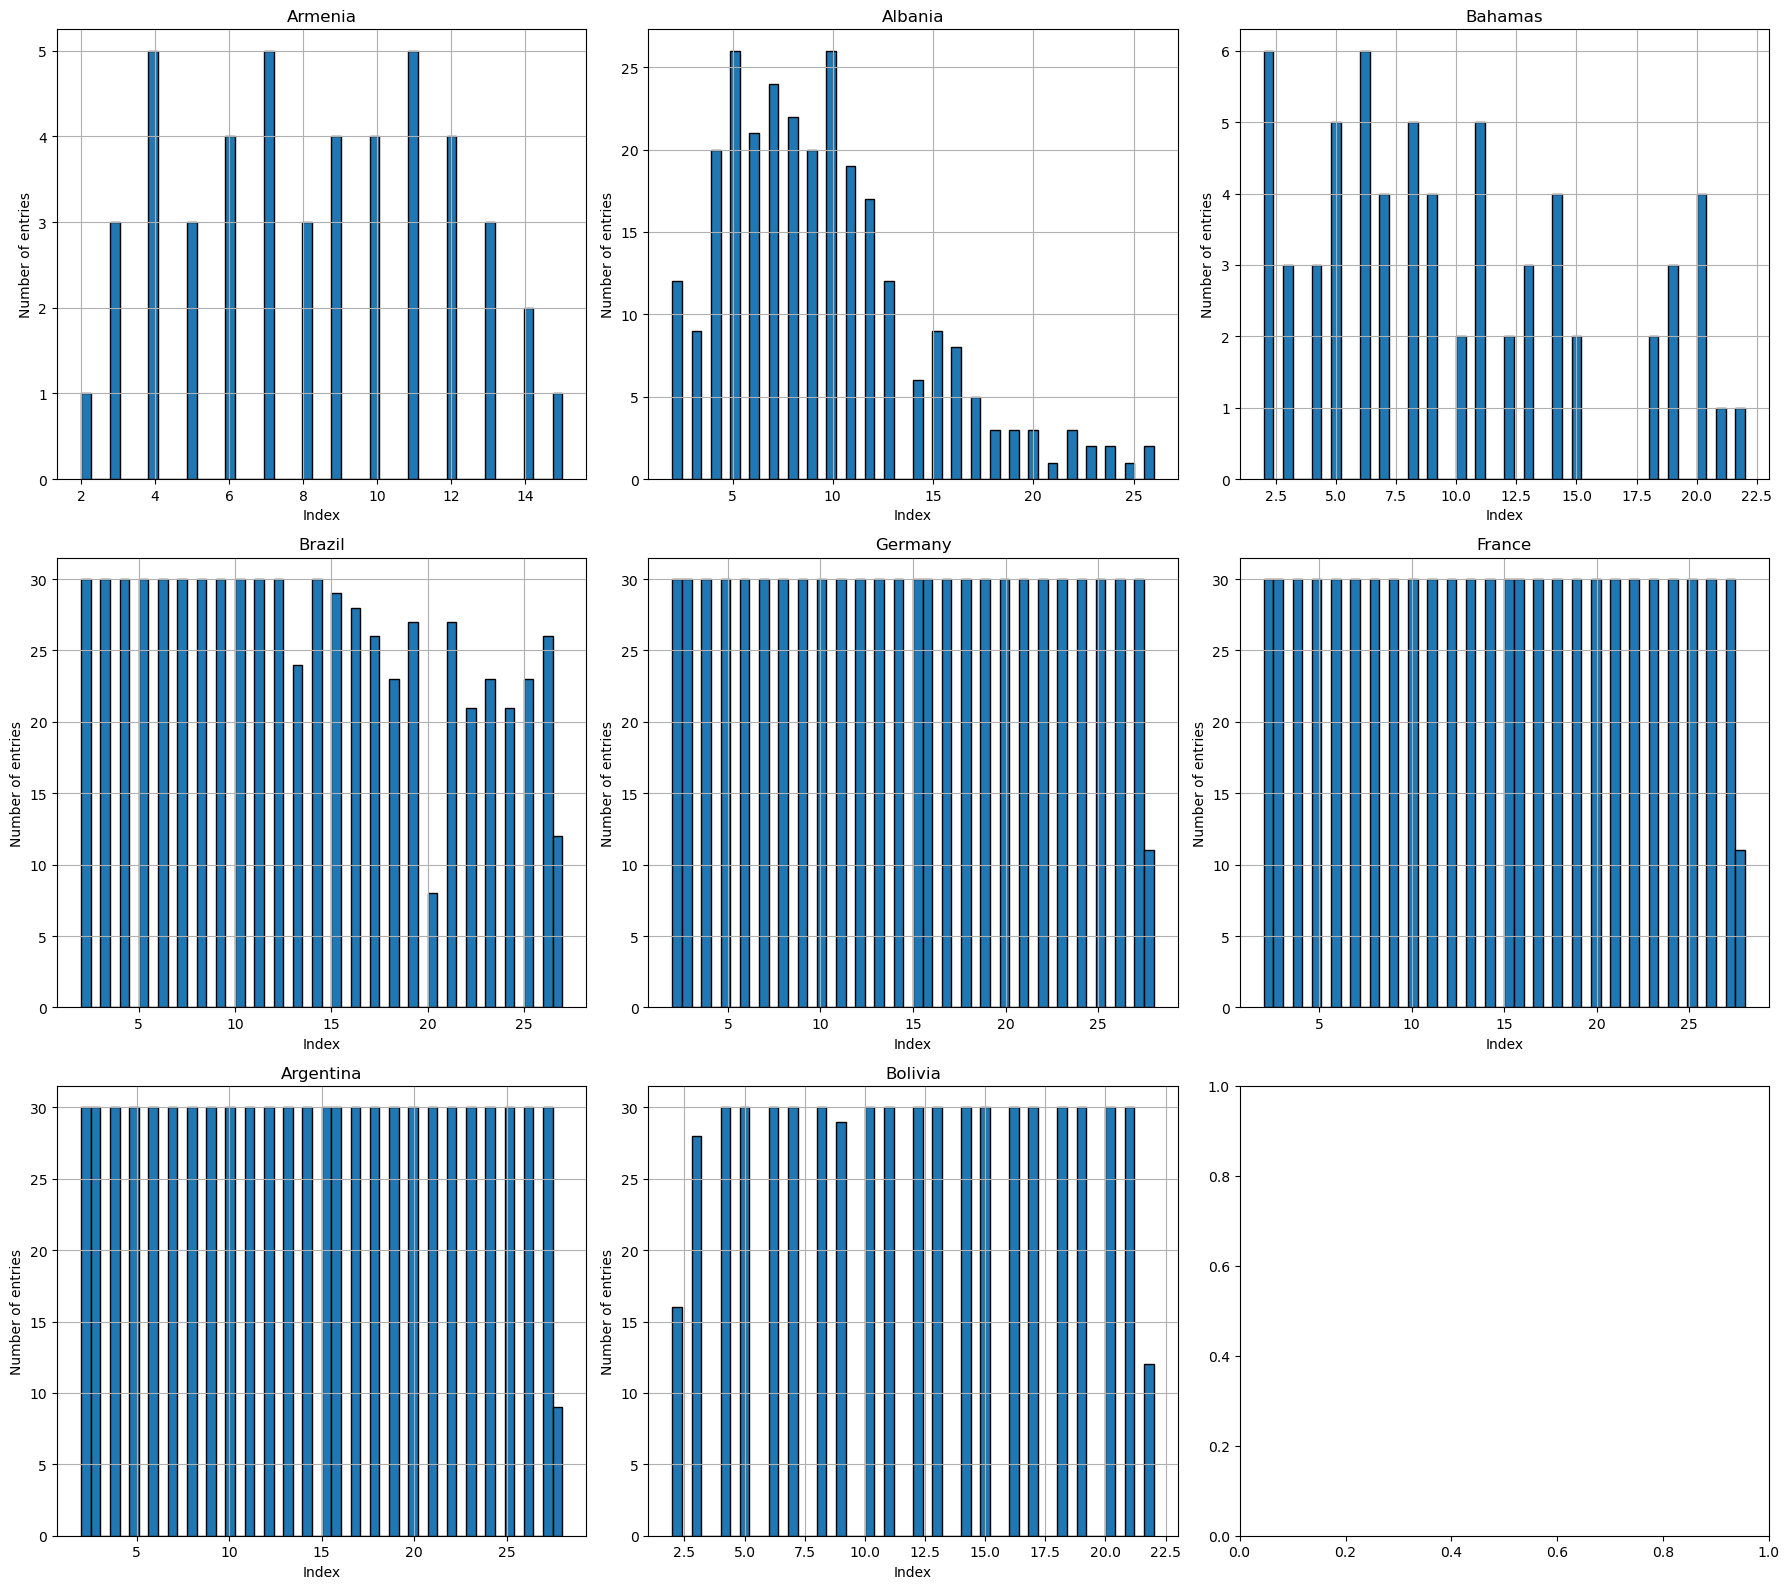

In [90]:
neue_liste = ["Armenia", "Albania", "Bahamas", "Brazil", "Germany", "France", "Argentina", "Bolivia"]
from IPython.display import display, HTML

def plotting_regularity(neue_liste): #this function is to plot the regularity graph
    num_plots = len(neue_liste)
    num_cols = 3  # Number of rows
    num_rows = (num_plots // num_cols) + 1
    fig_width = 6 * num_cols
    fig_height = 2 * num_plots
    j = 0
    k = 0
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height)) #creating as many subplots as the list is long
    for i, dataset in enumerate(neue_liste): #iterating over the list
        #print ("printing i: ", i, "and j and k", j, k )
        filtered_data_new = regularity(neue_liste[i], "total_vaccinations") #calling the regularity function to get the data
        filtered_data_new = filtered_data_new.values #converting the datatype
        filtered_data_new = transform(filtered_data_new)
        filtered_data_new = filtered_data_new[filtered_data_new != 0]
        axs[j,k].hist(filtered_data_new, bins=50, edgecolor='black')  # Plot histogram
        axs[j,k].set_title(neue_liste[i])  # Add title
        axs[j,k].set_xlabel('Index')  # Add x-axis label
        axs[j,k].set_ylabel('Number of entries')  # Add y-axis label
        axs[j,k].grid(True)
        if k == num_cols - 1:
            k = 0
            j += 1
        else: 
            k += 1
    plt.tight_layout()  # Adjust layout
    #display(HTML("<style> .output { overflow-y: auto; max-height: 200px; } </style>"))
    plt.show()  # Show the plot  

plotting_regularity(neue_liste)

#### 5.2 Individual column analysis

##### 5.2.1 Analysis "stringency index" (complete set)

In [91]:
""" ## Analysis "stringency_index"
countries_eligible_stringency_index = countries_eligible("stringency_index", 50)
countries_to_check_stringency_index = countries_to_check("stringency_index", 50)
index_list_to_check_stringency_index = countries_to_check_stringency_index.index.tolist()
index_list_eligible_stringency_index = countries_eligible_stringency_index.index.tolist()
#index_list_to_check_stringency_index """

' ## Analysis "stringency_index"\ncountries_eligible_stringency_index = countries_eligible("stringency_index", 50)\ncountries_to_check_stringency_index = countries_to_check("stringency_index", 50)\nindex_list_to_check_stringency_index = countries_to_check_stringency_index.index.tolist()\nindex_list_eligible_stringency_index = countries_eligible_stringency_index.index.tolist()\n#index_list_to_check_stringency_index '

In [92]:
""" data_stringency_index = data["stringency_index"]
data_stringency_index.head(2000) """

' data_stringency_index = data["stringency_index"]\ndata_stringency_index.head(2000) '

In [93]:
""" plotting_regularity(index_list_eligible_stringency_index) """

' plotting_regularity(index_list_eligible_stringency_index) '

##### 5.2.2 Analysis "new_people_vaccinated_smoothed_per_hundred" (complete set)


In [94]:
""" ## Analysis "new_people_vaccinated_smoothed_per_hundred"
countries_eligible_new_people_vaccinated_smoothed_per_hundred = countries_eligible("new_people_vaccinated_smoothed_per_hundred", 50)
countries_to_check_new_people_vaccinated_smoothed_per_hundred = countries_to_check("new_people_vaccinated_smoothed_per_hundred", 50)
index_list_to_check_new_people_vaccinated_smoothed_per_hundred = countries_to_check_new_people_vaccinated_smoothed_per_hundred.index.tolist()
index_list_eligible_new_people_vaccinated_smoothed_per_hundred = countries_eligible_new_people_vaccinated_smoothed_per_hundred.index.tolist()
#index_list_to_check_new_people_vaccinated_smoothed_per_hundred """

' ## Analysis "new_people_vaccinated_smoothed_per_hundred"\ncountries_eligible_new_people_vaccinated_smoothed_per_hundred = countries_eligible("new_people_vaccinated_smoothed_per_hundred", 50)\ncountries_to_check_new_people_vaccinated_smoothed_per_hundred = countries_to_check("new_people_vaccinated_smoothed_per_hundred", 50)\nindex_list_to_check_new_people_vaccinated_smoothed_per_hundred = countries_to_check_new_people_vaccinated_smoothed_per_hundred.index.tolist()\nindex_list_eligible_new_people_vaccinated_smoothed_per_hundred = countries_eligible_new_people_vaccinated_smoothed_per_hundred.index.tolist()\n#index_list_to_check_new_people_vaccinated_smoothed_per_hundred '

##### 5.2.3 Analysis new_people_vaccinated_smoothed (complete set)

In [95]:
## Analysis "new_people_vaccinated_smoothed"
countries_eligible_new_people_vaccinated_smoothed = countries_eligible("new_people_vaccinated_smoothed", 50)
countries_to_check_new_people_vaccinated_smoothed = countries_to_check("new_people_vaccinated_smoothed", 50)
index_list_to_check_new_people_vaccinated_smoothed = countries_to_check_new_people_vaccinated_smoothed.index.tolist()
index_list_eligible_new_people_vaccinated_smoothed = countries_eligible_new_people_vaccinated_smoothed.index.tolist()
#index_list_to_check_new_people_vaccinated_smoothed

##### 5.2.4 Analysis new_vaccinations_smoothed_per_million (complete set)

In [96]:
""" ## Analysis "new_vaccinations_smoothed_per_million"
countries_eligible_new_vaccinations_smoothed_per_million = countries_eligible("new_vaccinations_smoothed_per_million", 50)
countries_to_check_new_vaccinations_smoothed_per_million = countries_to_check("new_vaccinations_smoothed_per_million", 50)
index_list_to_check_new_vaccinations_smoothed_per_million = countries_to_check_new_vaccinations_smoothed_per_million.index.tolist()
index_list_eligible_new_vaccinations_smoothed_per_million = countries_eligible_new_vaccinations_smoothed_per_million.index.tolist()
#index_list_to_check_new_vaccinations_smoothed_per_million """

' ## Analysis "new_vaccinations_smoothed_per_million"\ncountries_eligible_new_vaccinations_smoothed_per_million = countries_eligible("new_vaccinations_smoothed_per_million", 50)\ncountries_to_check_new_vaccinations_smoothed_per_million = countries_to_check("new_vaccinations_smoothed_per_million", 50)\nindex_list_to_check_new_vaccinations_smoothed_per_million = countries_to_check_new_vaccinations_smoothed_per_million.index.tolist()\nindex_list_eligible_new_vaccinations_smoothed_per_million = countries_eligible_new_vaccinations_smoothed_per_million.index.tolist()\n#index_list_to_check_new_vaccinations_smoothed_per_million '

##### 5.2.5 Analysis "total_boosters_per_hundred"

Summary: dropping Algeria, Niue, Tokelau

In [97]:
""" ## Analysis "total_boosters_per_hundred"
countries_eligible_total_boosters_per_hundred = countries_eligible("total_boosters_per_hundred", 50)
countries_to_check_total_boosters_per_hundred = countries_to_check("total_boosters_per_hundred", 50)
index_list_to_check_total_boosters_per_hundred = countries_to_check_total_boosters_per_hundred.index.tolist()
index_list_eligible_total_boosters_per_hundred = countries_eligible_total_boosters_per_hundred.index.tolist()
#plotting_regularity(index_list_to_check_total_boosters_per_hundred) """



' ## Analysis "total_boosters_per_hundred"\ncountries_eligible_total_boosters_per_hundred = countries_eligible("total_boosters_per_hundred", 50)\ncountries_to_check_total_boosters_per_hundred = countries_to_check("total_boosters_per_hundred", 50)\nindex_list_to_check_total_boosters_per_hundred = countries_to_check_total_boosters_per_hundred.index.tolist()\nindex_list_eligible_total_boosters_per_hundred = countries_eligible_total_boosters_per_hundred.index.tolist()\n#plotting_regularity(index_list_to_check_total_boosters_per_hundred) '

##### 5.2.6 Analysis people_fully_vaccinated_per_hundred	

Summary: Algeria, Nauru, Bonnaire, Pitcern, Niue, Tokelau, Turkmenistan

In [98]:
""" ## Analysis "people_fully_vaccinated_per_hundred"
countries_eligible_people_fully_vaccinated_per_hundred = countries_eligible("people_fully_vaccinated_per_hundred", 50)
countries_to_check_people_fully_vaccinated_per_hundred = countries_to_check("people_fully_vaccinated_per_hundred", 50)
index_list_to_check_people_fully_vaccinated_per_hundred = countries_to_check_people_fully_vaccinated_per_hundred.index.tolist()
index_list_eligible_people_fully_vaccinated_per_hundred = countries_eligible_people_fully_vaccinated_per_hundred.index.tolist()
#plotting_regularity(index_list_to_check_people_fully_vaccinated_per_hundred) """

' ## Analysis "people_fully_vaccinated_per_hundred"\ncountries_eligible_people_fully_vaccinated_per_hundred = countries_eligible("people_fully_vaccinated_per_hundred", 50)\ncountries_to_check_people_fully_vaccinated_per_hundred = countries_to_check("people_fully_vaccinated_per_hundred", 50)\nindex_list_to_check_people_fully_vaccinated_per_hundred = countries_to_check_people_fully_vaccinated_per_hundred.index.tolist()\nindex_list_eligible_people_fully_vaccinated_per_hundred = countries_eligible_people_fully_vaccinated_per_hundred.index.tolist()\n#plotting_regularity(index_list_to_check_people_fully_vaccinated_per_hundred) '

##### 5.2.7 Analysis "people_vaccinated_per_hundred"

Summary: dropping Algeria, Bonnaire, Falkland islands, Pitcern, Niue, St Helena, Tokelau, Turkmenistan

In [99]:
""" ## Analysis "people_vaccinated_per_hundred"
countries_eligible_people_vaccinated_per_hundred = countries_eligible("people_vaccinated_per_hundred", 50)
countries_to_check_people_vaccinated_per_hundred = countries_to_check("people_vaccinated_per_hundred", 50)
index_list_to_check_people_vaccinated_per_hundred = countries_to_check_people_vaccinated_per_hundred.index.tolist()
index_list_eligible_people_vaccinated_per_hundred = countries_eligible_people_vaccinated_per_hundred.index.tolist()
#plotting_regularity(index_list_to_check_people_vaccinated_per_hundred) """

' ## Analysis "people_vaccinated_per_hundred"\ncountries_eligible_people_vaccinated_per_hundred = countries_eligible("people_vaccinated_per_hundred", 50)\ncountries_to_check_people_vaccinated_per_hundred = countries_to_check("people_vaccinated_per_hundred", 50)\nindex_list_to_check_people_vaccinated_per_hundred = countries_to_check_people_vaccinated_per_hundred.index.tolist()\nindex_list_eligible_people_vaccinated_per_hundred = countries_eligible_people_vaccinated_per_hundred.index.tolist()\n#plotting_regularity(index_list_to_check_people_vaccinated_per_hundred) '

##### 5.2.8 Analysis "total_vaccinations_per_hundred"

Summary: dropping Sint, Falkland islands, Pitcern, Niue, St Helena, Turkmenistan

In [100]:
""" ## Analysis "total_vaccinations_per_hundred"
countries_eligible_total_vaccinations_per_hundred = countries_eligible("total_vaccinations_per_hundred", 50)
countries_to_check_total_vaccinations_per_hundred = countries_to_check("total_vaccinations_per_hundred", 50)
index_list_to_check_total_vaccinations_per_hundred = countries_to_check_total_vaccinations_per_hundred.index.tolist()
index_list_eligible_total_vaccinations_per_hundred = countries_eligible_total_vaccinations_per_hundred.index.tolist()
#plotting_regularity(index_list_to_check_total_vaccinations_per_hundred) """

' ## Analysis "total_vaccinations_per_hundred"\ncountries_eligible_total_vaccinations_per_hundred = countries_eligible("total_vaccinations_per_hundred", 50)\ncountries_to_check_total_vaccinations_per_hundred = countries_to_check("total_vaccinations_per_hundred", 50)\nindex_list_to_check_total_vaccinations_per_hundred = countries_to_check_total_vaccinations_per_hundred.index.tolist()\nindex_list_eligible_total_vaccinations_per_hundred = countries_eligible_total_vaccinations_per_hundred.index.tolist()\n#plotting_regularity(index_list_to_check_total_vaccinations_per_hundred) '

##### 5.2.9 Analysis "new_vaccinations_smoothed" (complete set)

In [101]:
""" ## Analysis "new_vaccinations_smoothed"
countries_eligible_new_vaccinations_smoothed = countries_eligible("new_vaccinations_smoothed", 50)
countries_to_check_new_vaccinations_smoothed = countries_to_check("new_vaccinations_smoothed", 50)
index_list_to_check_new_vaccinations_smoothed = countries_to_check_new_vaccinations_smoothed.index.tolist()
index_list_eligible_new_vaccinations_smoothed = countries_eligible_new_vaccinations_smoothed.index.tolist()
#index_list_to_check_new_vaccinations_smoothed """


' ## Analysis "new_vaccinations_smoothed"\ncountries_eligible_new_vaccinations_smoothed = countries_eligible("new_vaccinations_smoothed", 50)\ncountries_to_check_new_vaccinations_smoothed = countries_to_check("new_vaccinations_smoothed", 50)\nindex_list_to_check_new_vaccinations_smoothed = countries_to_check_new_vaccinations_smoothed.index.tolist()\nindex_list_eligible_new_vaccinations_smoothed = countries_eligible_new_vaccinations_smoothed.index.tolist()\n#index_list_to_check_new_vaccinations_smoothed '

##### 5.2.10 Analysis "new_vaccinations"


Summary: no countries to be dropped

In [102]:
""" countries_eligible_new_vaccinations = countries_eligible("new_vaccinations", 50)
countries_to_check_new_vaccinations = countries_to_check("new_vaccinations", 50)
index_list_to_check_new_vaccinations = countries_to_check_new_vaccinations.index.tolist()
index_list_eligible_new_vaccinations = countries_eligible_new_vaccinations.index.tolist()
#plotting_regularity(index_list_to_check_new_vaccinations) """

' countries_eligible_new_vaccinations = countries_eligible("new_vaccinations", 50)\ncountries_to_check_new_vaccinations = countries_to_check("new_vaccinations", 50)\nindex_list_to_check_new_vaccinations = countries_to_check_new_vaccinations.index.tolist()\nindex_list_eligible_new_vaccinations = countries_eligible_new_vaccinations.index.tolist()\n#plotting_regularity(index_list_to_check_new_vaccinations) '

##### 5.2.11 Analysis "total boosters"

Summary: dropping Niue

In [103]:
""" ## Analysis "total_boosters"
countries_eligible_total_boosters = countries_eligible("total_boosters", 50)
countries_to_check_total_boosters = countries_to_check("total_boosters", 50)
index_list_to_check_total_boosters = countries_to_check_total_boosters.index.tolist()
index_list_eligible_total_boosters = countries_eligible_total_boosters.index.tolist()
#plotting_regularity(index_list_eligible_total_boosters) """

' ## Analysis "total_boosters"\ncountries_eligible_total_boosters = countries_eligible("total_boosters", 50)\ncountries_to_check_total_boosters = countries_to_check("total_boosters", 50)\nindex_list_to_check_total_boosters = countries_to_check_total_boosters.index.tolist()\nindex_list_eligible_total_boosters = countries_eligible_total_boosters.index.tolist()\n#plotting_regularity(index_list_eligible_total_boosters) '

In [104]:
""" data_boosters = data[["location", "total_boosters"]]
data_boosters.head(2000) """

' data_boosters = data[["location", "total_boosters"]]\ndata_boosters.head(2000) '

##### 5.2.12 Analysis "people_fully_vaccinated"

Summary: dropping Algeria, Bonnaire, Niue, Pitcern, Turkmenistan

In [105]:
""" ### Analysis "people_fully_vaccinated"
countries_eligible_people_fully_vaccinated = countries_eligible("people_fully_vaccinated", 50)
countries_to_check_people_fully_vaccinated = countries_to_check("people_fully_vaccinated", 50)
index_list_to_check_people_fully_vaccinated = countries_to_check_people_fully_vaccinated.index.tolist()
index_list_eligible_people_fully_vaccinated = countries_eligible_people_fully_vaccinated.index.tolist()
#plotting_regularity(index_list_to_check_people_fully_vaccinated) """

' ### Analysis "people_fully_vaccinated"\ncountries_eligible_people_fully_vaccinated = countries_eligible("people_fully_vaccinated", 50)\ncountries_to_check_people_fully_vaccinated = countries_to_check("people_fully_vaccinated", 50)\nindex_list_to_check_people_fully_vaccinated = countries_to_check_people_fully_vaccinated.index.tolist()\nindex_list_eligible_people_fully_vaccinated = countries_eligible_people_fully_vaccinated.index.tolist()\n#plotting_regularity(index_list_to_check_people_fully_vaccinated) '

##### 5.2.13 Analysis "people_vaccinated"

Summary: dropping Sint, Falkland islands, Pitcern, Niue, St Helena, Tokelau, Turkmenistan, Tuvalu

In [106]:
""" ### Analysis "people_vaccinated"
countries_eligible_people_vaccinated = countries_eligible("people_vaccinated", 50)
countries_to_check_people_vaccinated = countries_to_check("people_vaccinated", 50)
index_list_to_check_people_vaccinated = countries_to_check_people_vaccinated.index.tolist()
index_list_eligible_people_vaccinated = countries_eligible_people_vaccinated.index.tolist()
#plotting_regularity(index_list_to_check_people_vaccinated) """

' ### Analysis "people_vaccinated"\ncountries_eligible_people_vaccinated = countries_eligible("people_vaccinated", 50)\ncountries_to_check_people_vaccinated = countries_to_check("people_vaccinated", 50)\nindex_list_to_check_people_vaccinated = countries_to_check_people_vaccinated.index.tolist()\nindex_list_eligible_people_vaccinated = countries_eligible_people_vaccinated.index.tolist()\n#plotting_regularity(index_list_to_check_people_vaccinated) '

##### 5.2.14 Analysis "total_vaccinations"

Summary: dropping Bonnaire Sint, Falkland islands, Pitcern, Niue, St Helena, Tokelau, Turkmenistan

In [107]:
""" countries_eligible_total_vaccinations = countries_eligible("total_vaccinations", 50)
countries_to_check_total_vaccinations = countries_to_check("total_vaccinations", 50)
index_list_to_check_total_vaccinations = countries_to_check_total_vaccinations.index.tolist()
index_list_eligible_total_vaccinations = countries_eligible_total_vaccinations.index.tolist()
#plotting_regularity(index_list_to_check_total_vaccinations) """

' countries_eligible_total_vaccinations = countries_eligible("total_vaccinations", 50)\ncountries_to_check_total_vaccinations = countries_to_check("total_vaccinations", 50)\nindex_list_to_check_total_vaccinations = countries_to_check_total_vaccinations.index.tolist()\nindex_list_eligible_total_vaccinations = countries_eligible_total_vaccinations.index.tolist()\n#plotting_regularity(index_list_to_check_total_vaccinations) '

##### 5.2.15 Analysis "tests_units"

Summary: dropping this entire column

In [108]:
#useless column as this is only stating "tests performed" or "NaN"

##### 5.2.16 Analysis "tests per case"

Summary: dropping Cameroon, Curacao and Suriname from the dataset

In [109]:
""" countries_eligible_tests_per_case = countries_eligible("tests_per_case", 50)
countries_to_check_tests_per_case = countries_to_check("tests_per_case", 50)
#countries missing completely at random but could be included: Bhutan, Botswana, El Salvador, Libya, Nepal, Palestine, United States Virgin Islands
#too many values generally missing: Cameroon, Curacao, Suriname
#weekly reporting: Germany
#monthly reporting: Hong Kong
#repeating values: Ireland
countries_to_check_tests_per_case """

' countries_eligible_tests_per_case = countries_eligible("tests_per_case", 50)\ncountries_to_check_tests_per_case = countries_to_check("tests_per_case", 50)\n#countries missing completely at random but could be included: Bhutan, Botswana, El Salvador, Libya, Nepal, Palestine, United States Virgin Islands\n#too many values generally missing: Cameroon, Curacao, Suriname\n#weekly reporting: Germany\n#monthly reporting: Hong Kong\n#repeating values: Ireland\ncountries_to_check_tests_per_case '

Results from the analysis above:
1. Vatican needs to be removed

countries with complete information in all categories: [Austria, Belgium, Czechia, Denmark, Estonia, France, Italy, Latvia, Norway, Switzerland, Ukraine, United Kingdom, 	]


In [110]:
EU_tests_per_case_every_value = ['Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czechia', 'Denmark', 'Estonia', 'Faeroe Islands', 'Finland',
       'France', 'Germany', 'Gibraltar', 'Greece', 'Guernsey', 'Hungary',
       'Iceland', 'Ireland', 'Isle of Man', 'Italy', 'Jersey', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova',
       'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway',
       'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'Ukraine', 'United Kingdom', 'Vatican']


total_vaccinations_countries with almost no missing data = []
total_vaccinations_ountries_weekly_reporting = []
total_vaccinations_countries_random_missing_data = []

In [111]:
""" country_of_interest = "Finland"
filtered = data_without_OWID.loc[df["location"] == country_of_interest]
filtered = filtered.reset_index(drop=True)
vaccinations = filtered["total_vaccinations"]
vaccinations.head(500) """

' country_of_interest = "Finland"\nfiltered = data_without_OWID.loc[df["location"] == country_of_interest]\nfiltered = filtered.reset_index(drop=True)\nvaccinations = filtered["total_vaccinations"]\nvaccinations.head(500) '

In [112]:
""" country_name = "Finland"
data_with_all_rows = filtering_missing_country(country_name)
data_with_specific_rows = data_with_all_rows.iloc[list(range(2, 3)) + list(range(32, 48)),:]
data_with_specific_rows """

' country_name = "Finland"\ndata_with_all_rows = filtering_missing_country(country_name)\ndata_with_specific_rows = data_with_all_rows.iloc[list(range(2, 3)) + list(range(32, 48)),:]\ndata_with_specific_rows '

### 6. Decision over keeping or deleting/imputing columns 48:63 (Sevi)

#### 6.1 Rough overview over the percentages of missing values:

In [113]:
columns_sevi = data.columns[48:63]
missing_percentages_sevi = df[columns_sevi].isnull().sum() / df.shape[0] *100
print(missing_percentages_sevi.sort_values(ascending=False))

handwashing_facilities        60.353767
extreme_poverty               47.591982
male_smokers                  39.873430
female_smokers                39.039479
hospital_beds_per_thousand    28.337817
human_development_index       21.435178
aged_65_older                 20.261967
aged_70_older                 19.834054
cardiovasc_death_rate         19.654062
gdp_per_capita                19.494410
median_age                    19.412665
diabetes_prevalence           15.413694
population_density            12.829330
life_expectancy                8.209789
population                     0.428681
dtype: float64


All  <75% that was previously defined -> no complete deletions

7 columns are  <75% and >20% -> further investigation

8 columns are <20% -> keep as is

#### 6.2 Static Values

I first tried to analyze the change of the missing values over for a few countries.

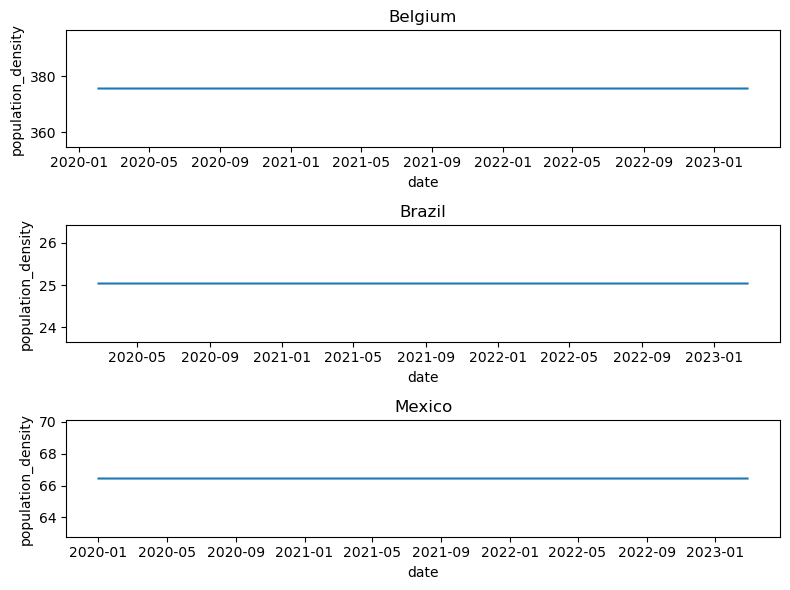

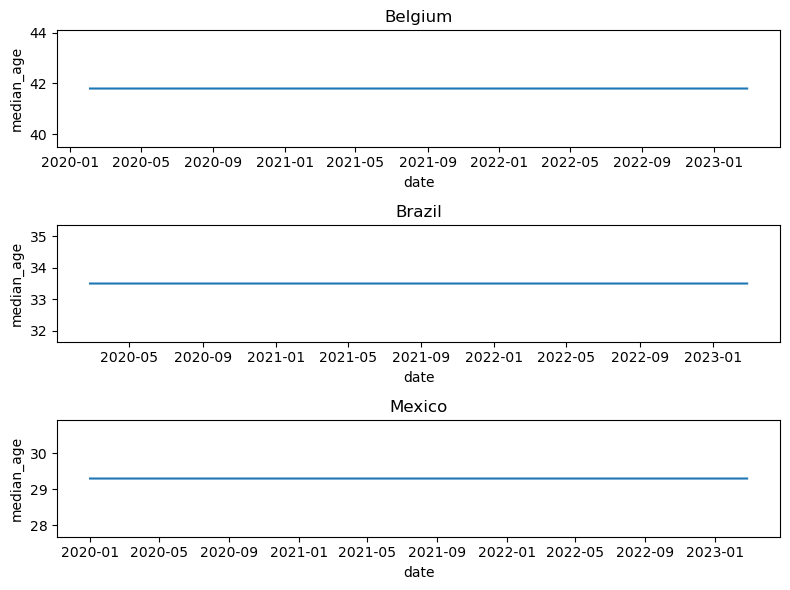

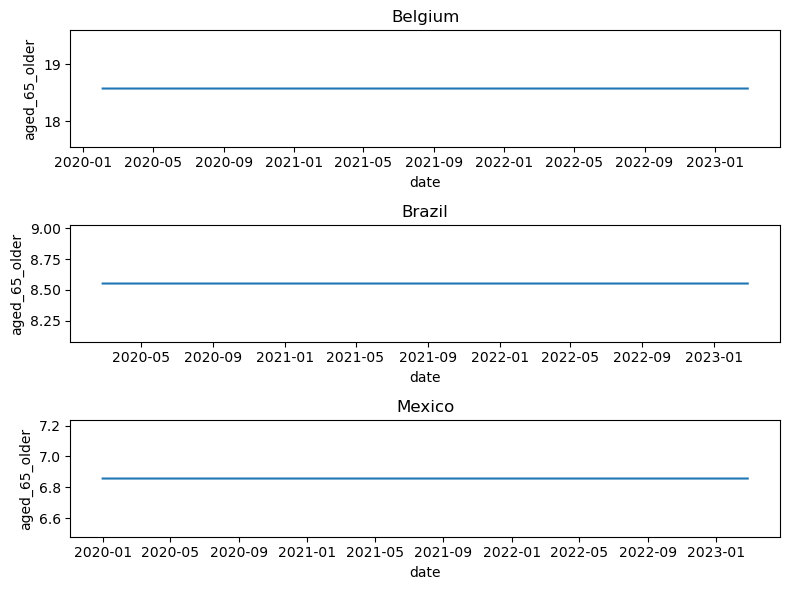

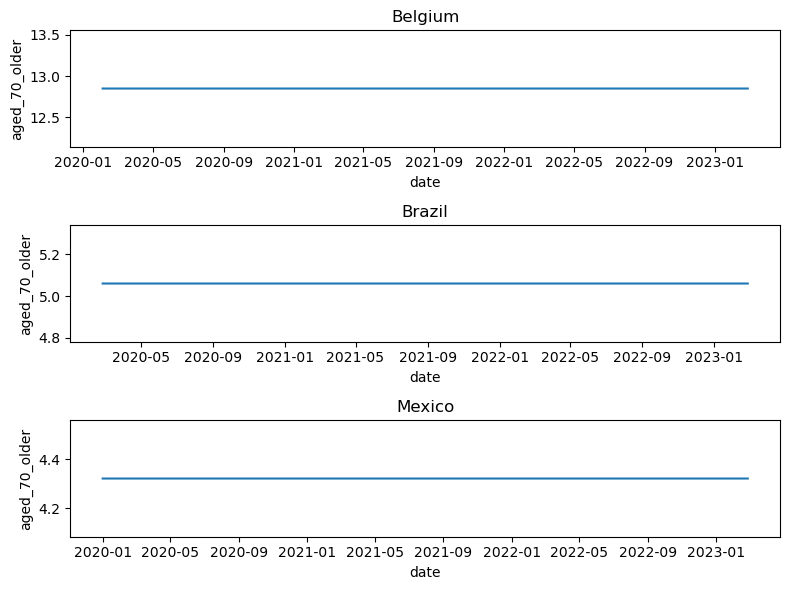

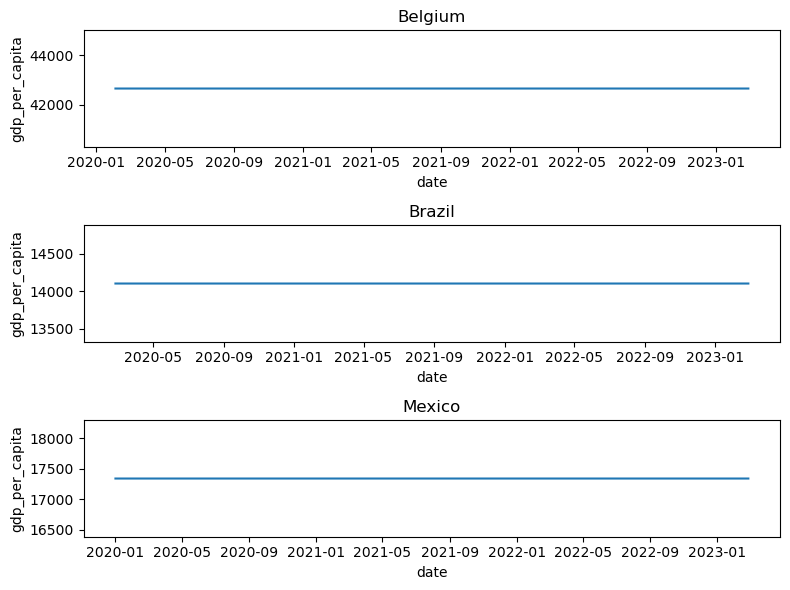

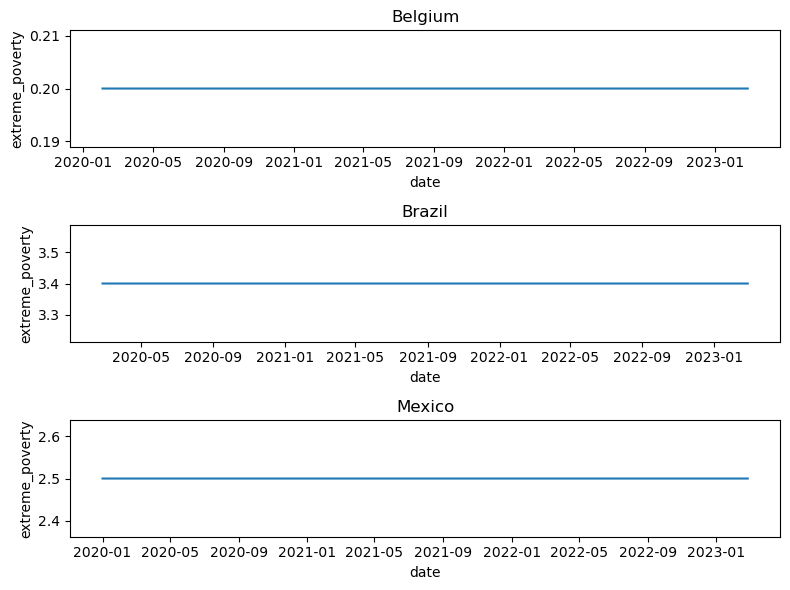

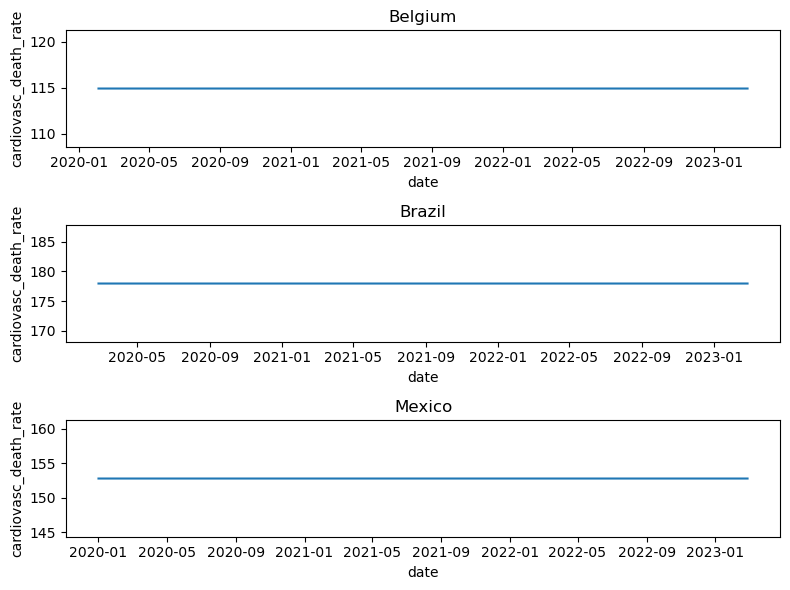

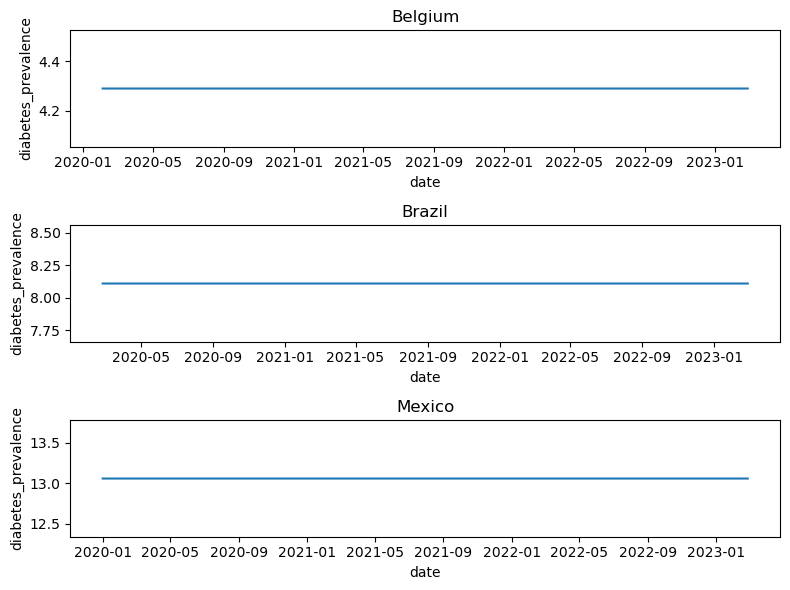

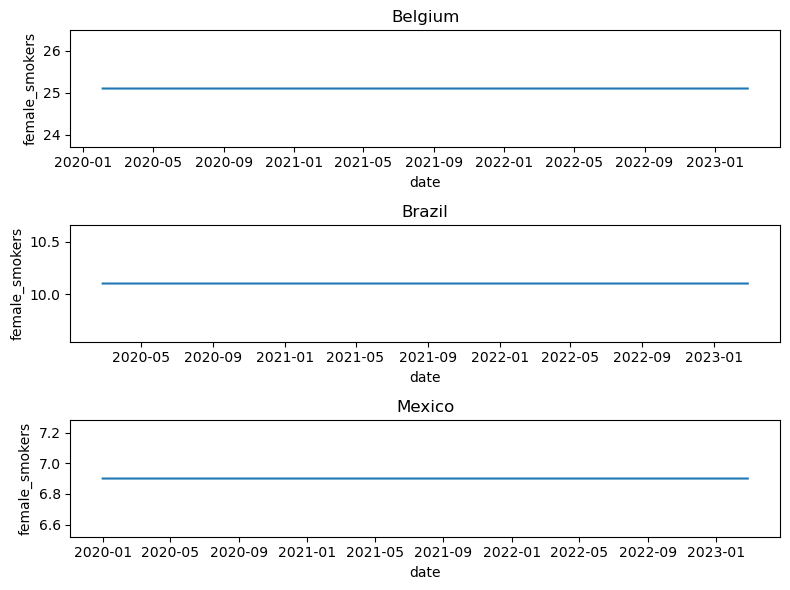

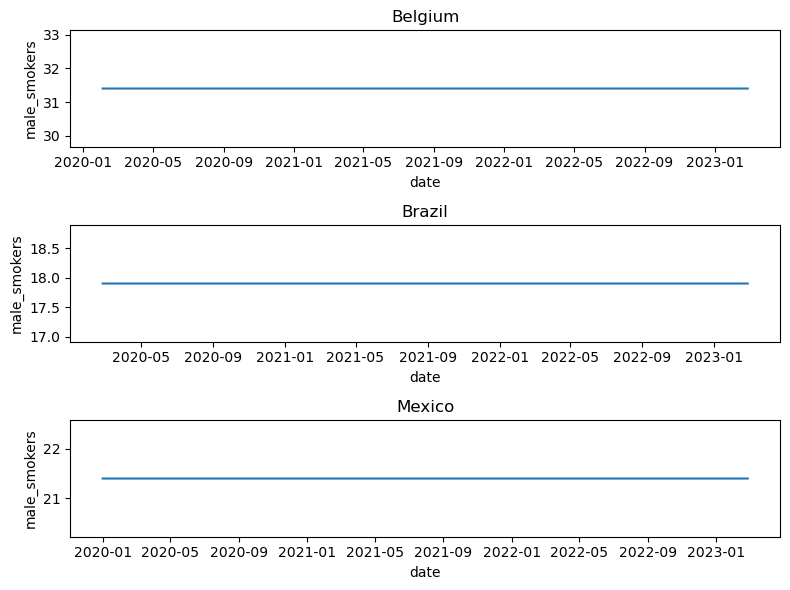

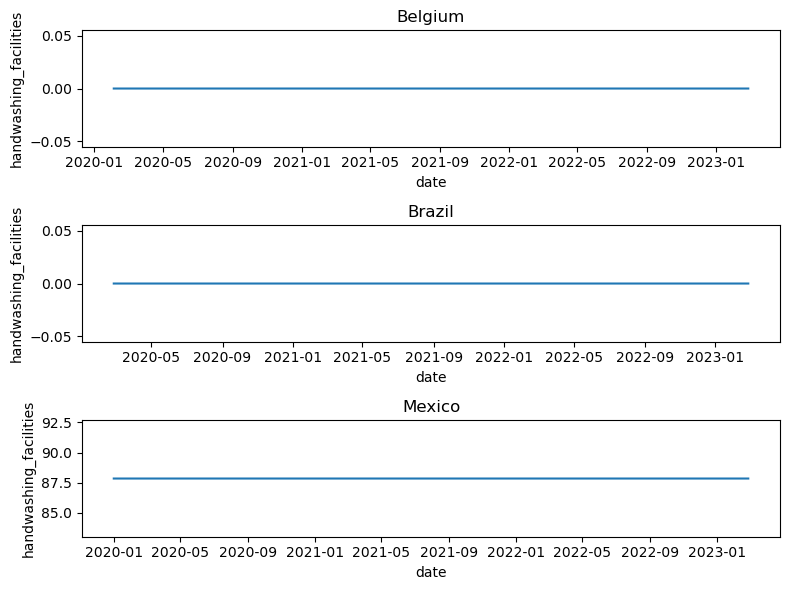

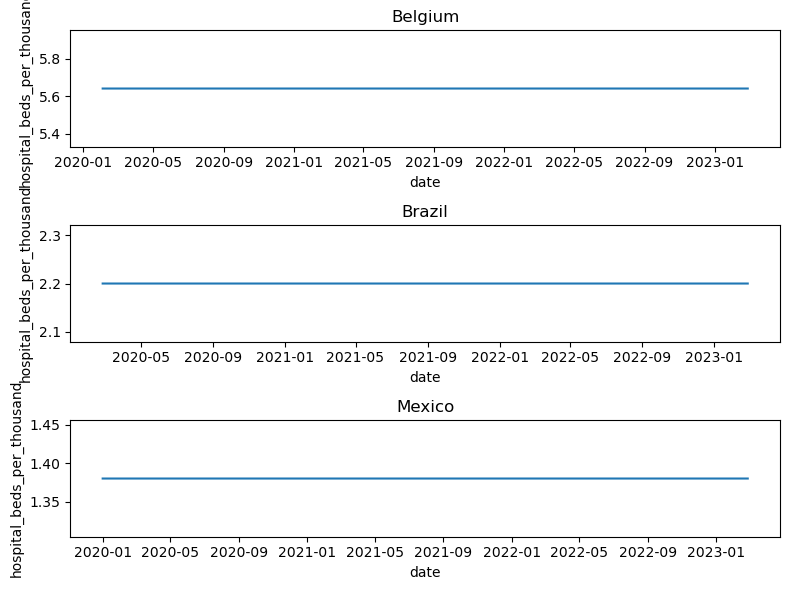

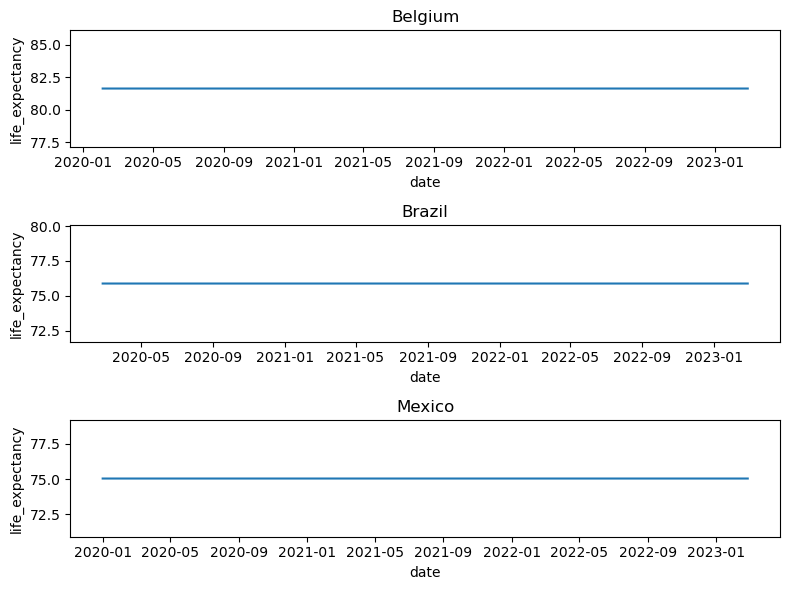

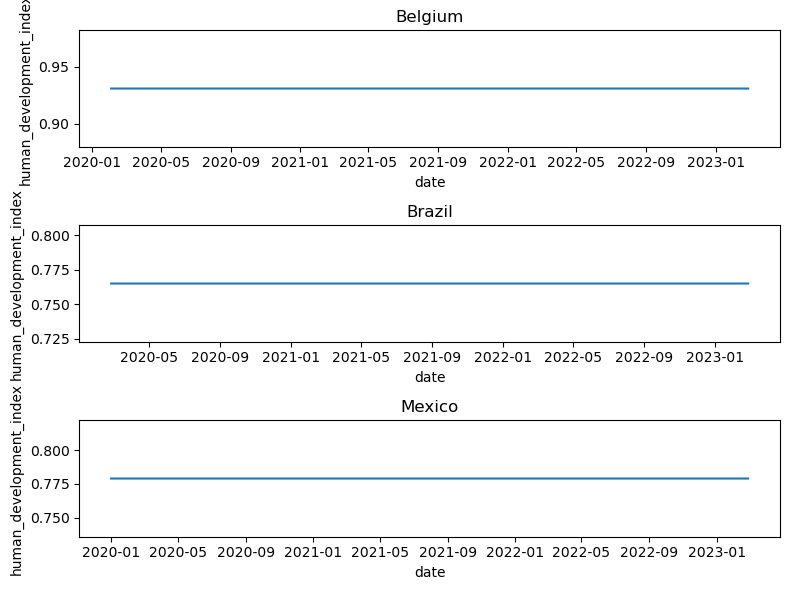

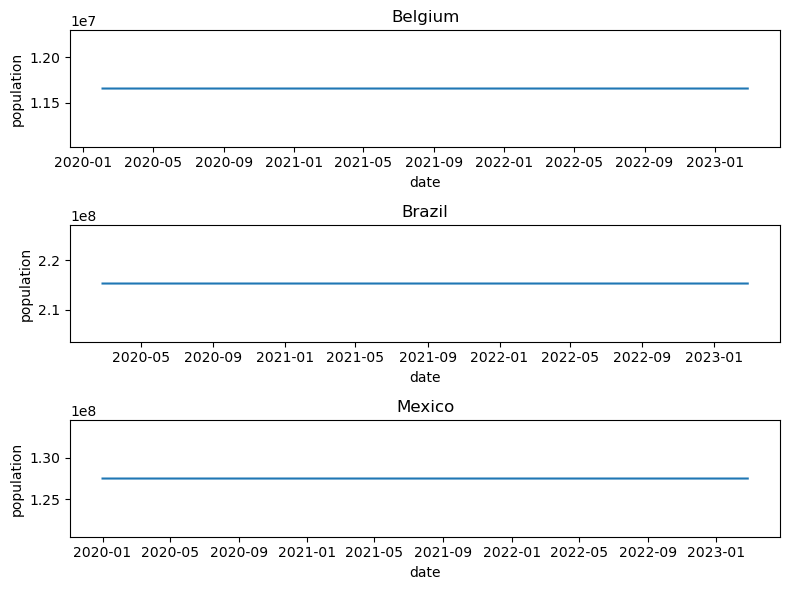

In [114]:
for column in columns_sevi:    
    belgium_data = df.groupby("iso_code").get_group("BEL")
    belgium = belgium_data[column].fillna(0)

    brazil_data = df.groupby("iso_code").get_group("BRA")
    brazil = brazil_data[column].fillna(0)

    mexico_data = df.groupby("iso_code").get_group("MEX")
    mexico = mexico_data[column].fillna(0)

    fig, axs = plt.subplots(3, 1, figsize=(8, 6))

    # Plot data on each subplot
    axs[0].plot(belgium_data["date"], belgium)
    axs[0].set_xlabel("date")
    axs[0].set_ylabel(column)
    axs[0].set_title("Belgium")

    axs[1].plot(brazil_data["date"], brazil)
    axs[1].set_xlabel("date")
    axs[1].set_ylabel(column)
    axs[1].set_title("Brazil")

    axs[2].plot(mexico_data["date"], mexico)
    axs[2].set_xlabel("date")
    axs[2].set_ylabel(column)
    axs[2].set_title("Mexico")

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    #safepoint = "../output/Missing_Data_Analysis/cols48-63/missing_data-" + column +".png"
    #plt.savefig(safepoint)

None of the number of values change over time.

There is only one value for each country for the whole dataset.

This may complicate any impution attempts

Here a function to confirm this finding:

In [115]:
def check_constant_values(data, country_col, time_col, variables):
    results = {}
    for country in data[country_col].unique():
        country_data = data[data[country_col] == country]
        results[country] = {}
        for variable in variables:
            unique_values = country_data[variable].dropna().unique()
            results[country][variable] = len(unique_values) < 2
    return results

constant_value_check = check_constant_values(data_without_OWID, 'iso_code', 'date', columns_sevi)

for country, variables in constant_value_check.items():
    print(f"Country: {country}")
    for var, is_constant in variables.items():
        if is_constant == False:
            print(f"  {var}: varies")
    print("\n")



Country: AFG


Country: ALB


Country: DZA


Country: AND


Country: AGO


Country: AIA


Country: ATG


Country: ARG


Country: ARM


Country: ABW


Country: AUS


Country: AUT


Country: AZE


Country: BHS


Country: BHR


Country: BGD


Country: BRB


Country: BLR


Country: BEL


Country: BLZ


Country: BEN


Country: BMU


Country: BTN


Country: BOL


Country: BES


Country: BIH


Country: BWA


Country: BRA


Country: VGB


Country: BRN


Country: BGR


Country: BFA


Country: BDI


Country: KHM


Country: CMR


Country: CAN


Country: CPV


Country: CYM


Country: CAF


Country: TCD


Country: CHL


Country: CHN


Country: COL


Country: COM


Country: COG


Country: COK


Country: CRI


Country: CIV


Country: HRV


Country: CUB


Country: CUW


Country: CYP


Country: CZE


Country: COD


Country: DNK


Country: DJI


Country: DMA


Country: DOM


Country: ECU


Country: EGY


Country: SLV


Country: GNQ


Country: ERI


Country: EST


Country: SWZ


Country: ETH


Country: F

### 7. Actual imputations and deletions

#### 7.1 First deletions that can already be made

In [116]:
#More than 90% of entries are missing for those four variables:
data_clean = data.drop(["excess_mortality_cumulative_absolute", "excess_mortality_cumulative", "excess_mortality", "excess_mortality_cumulative_per_million"], axis=1, inplace=False)


#Country deletions (Needed to clean up Leon data): They miss all 6 test columns, we want to have at least one tests column for our algorithms:
data_clean = data_clean[~data_clean['iso_code'].isin(countries_without_tests)]


#Leons deletions of columns missing more than 75% of data overall and also over 80% of all countries miss those variables entirely :
data_clean = data_clean.drop(['icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 
                              'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
                              'weekly_hosp_admissions_per_million'],axis=1, inplace=False)

#Florin deletions of additional columns :
data_clean = data_clean.drop(['tests_units'],axis=1, inplace=False)

#Florin country deletions:
countries_to_be_deleted_Florin = ["Algeria", "Bonaire Sint Eustatius and Saba", "Falkland Islands", "Nauru", "Niue", "Pitcairn", "Saint Helena", "Tokelau", "Turkmenistan","Tuvalu", "Vatican"]
data_clean = data_clean[~data_clean['location'].isin(countries_to_be_deleted_Florin)]


#insert all your drops and imputations here and save in data_clean!
#Von jetzt an nur noch data_clean brauchen






# TO REMOVE ASWELL: ALL OWID (we already have created data frames that dont include OWID)
data_clean = data_clean[~data_clean['iso_code'].str.contains('OWID')]


print("Clean data columns left:", data_clean.columns.to_list())
print("Clean data countries left:", data_clean["iso_code"].unique())
###

Clean data columns left: ['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred', 'new_vaccinations_smoothed_per_million', 'new_people_vaccinated_smoothed', 'new_people_vaccinated_smoothed_per_hundred', 'stringency_index', 'population_density', 'median_age', 'aged_

#### 7.2 Data observation after first deletions and further deletions (Leons Columns, countries):

Using this to see how our data_clean behaves after certain removals:

In [117]:
leon_columns_after_first_clean = ["reproduction_rate", "total_tests", "new_tests", "total_tests_per_thousand", 
                                  "new_tests_per_thousand", "new_tests_smoothed", 
                                  "new_tests_smoothed_per_thousand", "positive_rate"]

all_countries = list(data_clean.groupby("iso_code").groups.keys())
for column in leon_columns_after_first_clean:
    grouped_by_iso = data_clean.groupby("iso_code")
    nan_counts = grouped_by_iso[column].apply(lambda x: x.isnull().all()).sum()
    print("Percentage of countries that completely miss all values of", column,":", nan_counts/len(all_countries)*100)

Percentage of countries that completely miss all values of reproduction_rate : 7.853403141361256
Percentage of countries that completely miss all values of total_tests : 2.6178010471204187
Percentage of countries that completely miss all values of new_tests : 19.3717277486911
Percentage of countries that completely miss all values of total_tests_per_thousand : 2.6178010471204187
Percentage of countries that completely miss all values of new_tests_per_thousand : 19.3717277486911
Percentage of countries that completely miss all values of new_tests_smoothed : 4.712041884816754
Percentage of countries that completely miss all values of new_tests_smoothed_per_thousand : 4.712041884816754
Percentage of countries that completely miss all values of positive_rate : 8.37696335078534


We still have 19% of the countries that are entirely missing new_tests and new_tests per thousand. Those will need to be removed, after that we still have 4 variables that contain information about tests, which should be enough.

In [118]:
data_clean = data_clean.drop(["new_tests", "new_tests_per_thousand"],axis=1, inplace=False)

Observing what countries are still missing positive_rate:

In [119]:
empty_countries_p_rate = []
p_rate_loc = grouped_by_iso["positive_rate"].apply(lambda x: x.isnull().all())
p_rate_nan_countries_true = p_rate_loc[p_rate_loc == True]
empty_countries_p_rate.append(p_rate_nan_countries_true.index)

Deleting those countries:

In [120]:
data_clean = data_clean[~data_clean['iso_code'].isin(empty_countries_p_rate[0].tolist())]

Observing what countries are still missing total_tests_per_thousand: 

In [121]:
empty_countries_ttt = []
ttt_loc = grouped_by_iso["total_tests_per_thousand"].apply(lambda x: x.isnull().all())
ttt_nan_countries_true = ttt_loc[ttt_loc == True]
empty_countries_ttt.append(ttt_nan_countries_true.index)


Deleting those countries:

In [122]:
data_clean = data_clean[~data_clean['iso_code'].isin(empty_countries_ttt[0].tolist())]

Observing what countries are still missing reproduction_rate: (Also heavily affects Nicos data)

In [123]:
empty_countries_r_rate = []
r_rate_loc = grouped_by_iso["reproduction_rate"].apply(lambda x: x.isnull().all())
r_rate_nan_countries_true = r_rate_loc[r_rate_loc == True]
empty_countries_r_rate.append(r_rate_nan_countries_true.index)

Deleting those countries:

In [124]:
data_clean = data_clean[~data_clean['iso_code'].isin(empty_countries_r_rate[0].tolist())]

Observation after further deletions:

In [125]:
all_countries = list(data_clean.groupby("iso_code").groups.keys())
for column in data_clean.columns:
    grouped_by_iso = data_clean.groupby("iso_code")
    nan_counts = grouped_by_iso[column].apply(lambda x: x.isnull().all()).sum()
    print("Percentage of countries that completely miss all values of", column,":", nan_counts/len(all_countries)*100)

Percentage of countries that completely miss all values of iso_code : 0.0
Percentage of countries that completely miss all values of continent : 0.0
Percentage of countries that completely miss all values of location : 0.0
Percentage of countries that completely miss all values of date : 0.0
Percentage of countries that completely miss all values of total_cases : 0.0
Percentage of countries that completely miss all values of new_cases : 0.0
Percentage of countries that completely miss all values of new_cases_smoothed : 0.0
Percentage of countries that completely miss all values of total_deaths : 0.0
Percentage of countries that completely miss all values of new_deaths : 0.0
Percentage of countries that completely miss all values of new_deaths_smoothed : 0.0
Percentage of countries that completely miss all values of total_cases_per_million : 0.0
Percentage of countries that completely miss all values of new_cases_per_million : 0.0
Percentage of countries that completely miss all values 

What countries are left after deletions (Leon):

In [126]:
countries_left = data_clean.groupby("iso_code").groups.keys()
print(countries_left)
print(len(countries_left))

dict_keys(['AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 'BRB', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GTM', 'GUY', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LAO', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAR', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI', 'MLT', 'MMR', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW', 'POL', 'PRT', 'PRY', 'ROU', 'RUS', 'RWA', 'SAU', 'SEN', 'SLE', 'SLV', 'SOM', 'SRB', 'SSD', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SWZ', 'SYR', 'TCD', 'TGO', 'T

My remaining six columns have no more completely empty rows. Now on to the imputation of those columns:

#### 7.3 Imputations of remaining six columns (Leon):

To impute (Leon): reproduction_rate, total_tests, total_tests_per_thousand, new_tests_smoothed, new_tests_smoothed_per_thousand, positive_rate

The missing data percentages for the columns are as follows:

In [127]:
leon_columns_after_second_clean =["reproduction_rate", "total_tests", "total_tests_per_thousand", 
                                  "new_tests_smoothed", 
                                  "new_tests_smoothed_per_thousand", "positive_rate"]
missing_percentages_leon_after_del = data_clean[leon_columns_after_second_clean].isnull().sum() / data_clean.shape[0] *100
print(missing_percentages_leon_after_del)

reproduction_rate                  10.639183
total_tests                        57.733937
total_tests_per_thousand           57.733937
new_tests_smoothed                 46.071344
new_tests_smoothed_per_thousand    46.071344
positive_rate                      47.539714
dtype: float64


This may seem like a lot for the latter 5 but if we consider that those columns have a lot of those entries missing at the start or the end they are easily imputable. They miss at start and end because countries either have not tracked them from the beginning or have stopped tracking after a certain time. 

Imputation: 

In [128]:
data_clean = data_clean.interpolate(method='linear', subset=leon_columns_after_second_clean)
knn_imputer = KNNImputer(n_neighbors=5)
data_clean[leon_columns_after_second_clean] = knn_imputer.fit_transform(data_clean[leon_columns_after_second_clean])

I had to first do linear imputations for the end and start parts. There was still missing data after that, thats why there is also the knn imputation.

Taking a look at how imputation went:

In [129]:
missing_percentages_leon_after_imp = data_clean[leon_columns_after_second_clean].isnull().sum() / data_clean.shape[0] *100
print(missing_percentages_leon_after_imp)

reproduction_rate                  0.0
total_tests                        0.0
total_tests_per_thousand           0.0
new_tests_smoothed                 0.0
new_tests_smoothed_per_thousand    0.0
positive_rate                      0.0
dtype: float64


Those columns have no more missing data.

Also visually:

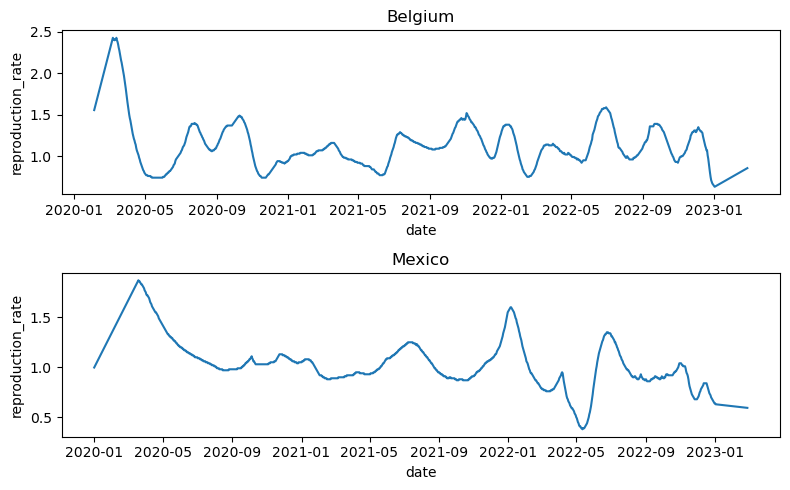

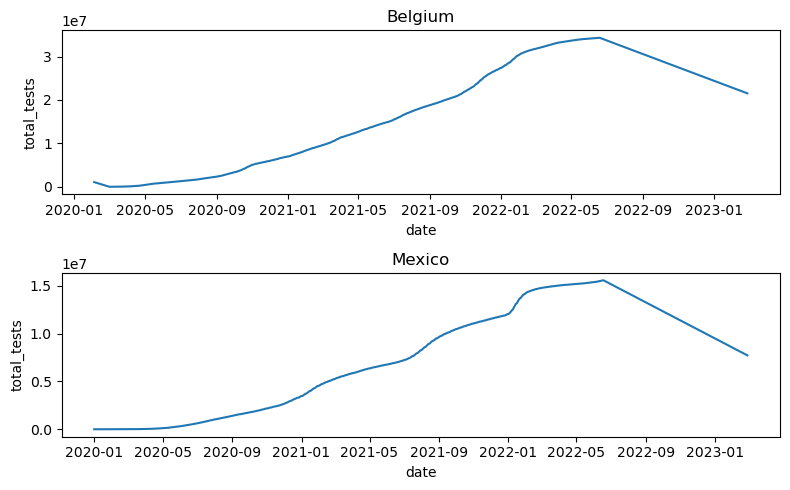

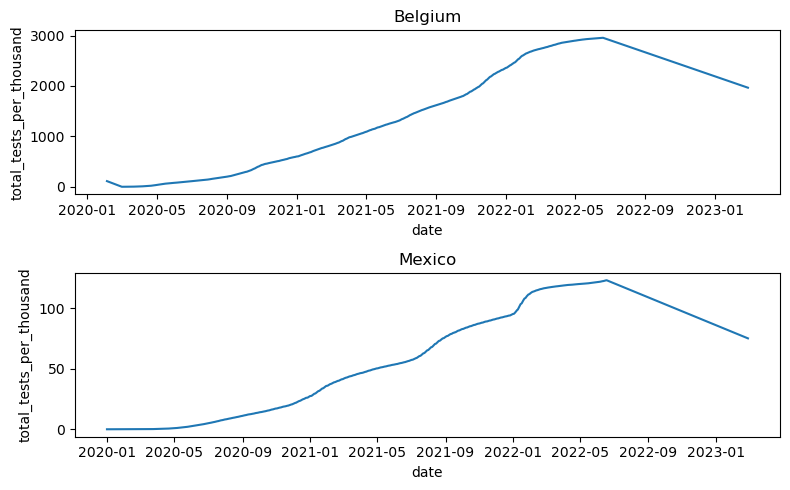

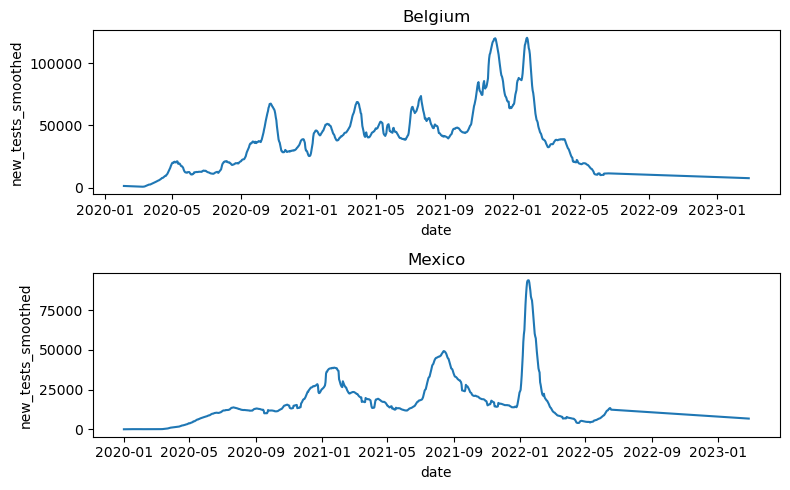

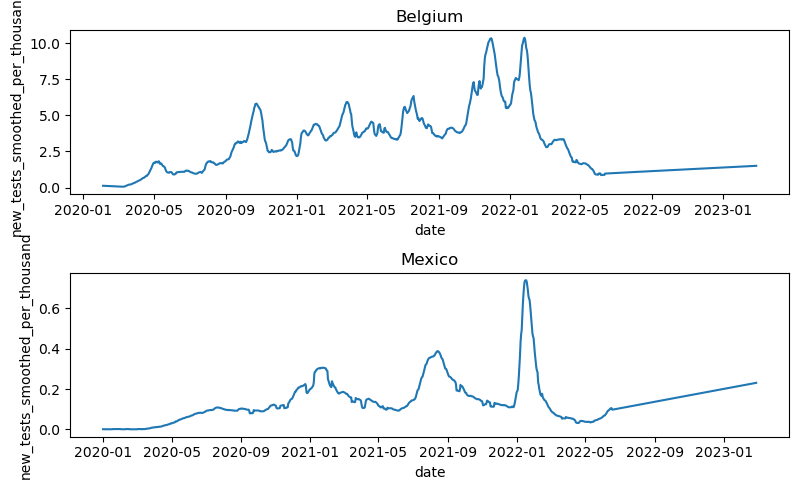

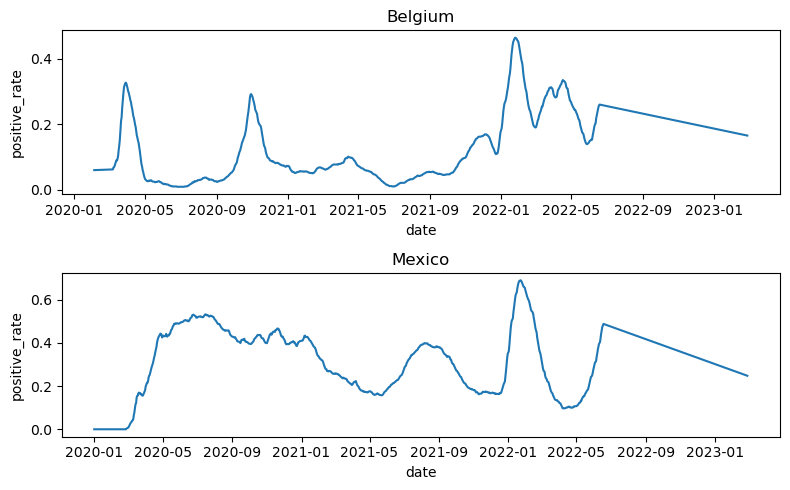

In [130]:
for column in leon_columns_after_second_clean:    
    belgium_data = data_clean.groupby("iso_code").get_group("BEL")
    belgium = belgium_data[column]

    mexico_data = data_clean.groupby("iso_code").get_group("MEX")
    mexico = mexico_data[column]

    fig, axs = plt.subplots(2, 1, figsize=(8, 5))

    # Plot data on each subplot
    axs[0].plot(belgium_data["date"], belgium)
    axs[0].set_xlabel("date")
    axs[0].set_ylabel(column)
    axs[0].set_title("Belgium")

    axs[1].plot(mexico_data["date"], mexico)
    axs[1].set_xlabel("date")
    axs[1].set_ylabel(column)
    axs[1].set_title("Mexico")

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    #safepoint = "../output/Missing_Data_Analysis/cols16-32/missing_data-" + column +"-after_imputation.png"
    #plt.savefig(safepoint)

#### 7.4 Imputations of columns (Sevi):

KNN Imputation

-KNN imputation works well for all seven variables, because they are all descriptive variables for a country's socioeconomic state.

-It identifies similarities based on multiple factors like health, economy, and demographics, ensuring the imputed values fit well with existing data.

In [131]:

knn_imputer = KNNImputer(n_neighbors=5)
variables_to_impute = ['handwashing_facilities', 'extreme_poverty', 'male_smokers', 
                       'female_smokers', 'hospital_beds_per_thousand', 'human_development_index',
                       'aged_65_older']
data_clean[variables_to_impute] = knn_imputer.fit_transform(data_clean[variables_to_impute])



#### 7.5 Imputations of columns (Nico)

Getting an overview over the missing data after the first deletions

In [132]:
nico_columns_after_second_clean = data_clean.columns[4:16] #in the first four columns we do not have to impute anything
missing_percentages_nico_after_del = data_clean[nico_columns_after_second_clean].isnull().sum() / data_clean.shape[0] *100
print(missing_percentages_nico_after_del)

total_cases                        0.000000
new_cases                          0.000000
new_cases_smoothed                 0.002889
total_deaths                       0.016180
new_deaths                         0.016180
new_deaths_smoothed                0.019070
total_cases_per_million            0.000000
new_cases_per_million              0.000000
new_cases_smoothed_per_million     0.002889
total_deaths_per_million           0.016180
new_deaths_per_million             0.016180
new_deaths_smoothed_per_million    0.019070
dtype: float64


There is only very little missing data left. All the columns are missing less than 1% which means a simple imputation method like forward/backward fill or mean imputation are sufficient for these columns. In this case we use forward and then backward fill to get rid of all NAN values. This makes sense since most NAN values are at the end or in the beginning of the recording period. The mean value would make less sense because of that

In [133]:
data_clean[nico_columns_after_second_clean] = data_clean[nico_columns_after_second_clean].ffill().bfill() #using forward fill and then backward fill so that no nan are left
missing_percentages_nico_after_ffill = data_clean[nico_columns_after_second_clean].isnull().sum() / data_clean.shape[0] *100
print(missing_percentages_nico_after_ffill) #checking for missing values

total_cases                        0.0
new_cases                          0.0
new_cases_smoothed                 0.0
total_deaths                       0.0
new_deaths                         0.0
new_deaths_smoothed                0.0
total_cases_per_million            0.0
new_cases_per_million              0.0
new_cases_smoothed_per_million     0.0
total_deaths_per_million           0.0
new_deaths_per_million             0.0
new_deaths_smoothed_per_million    0.0
dtype: float64


To check that there are no more missing values and to check if the imputations make sense, here are two visual representation of the columns from two different countries:

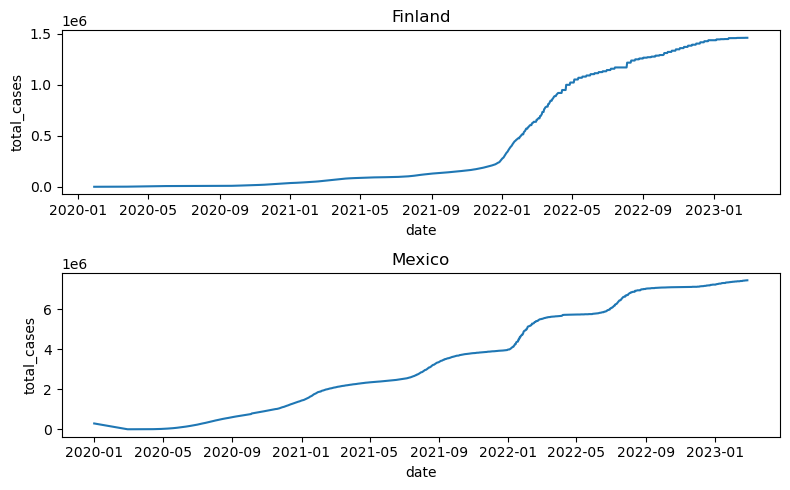

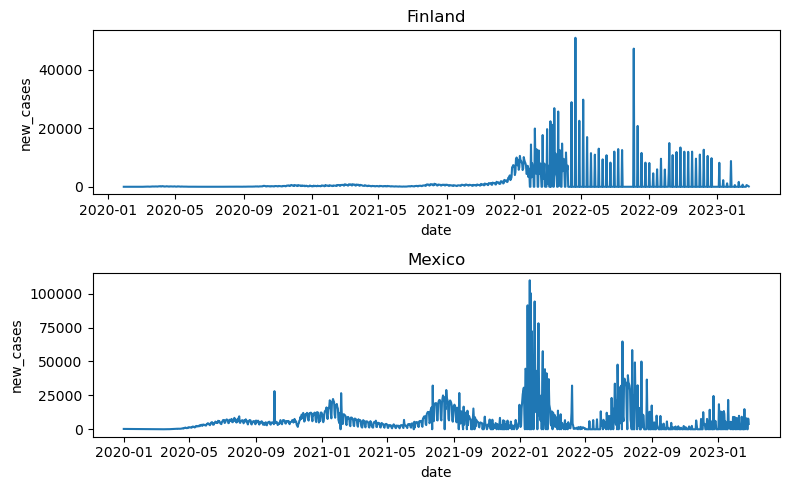

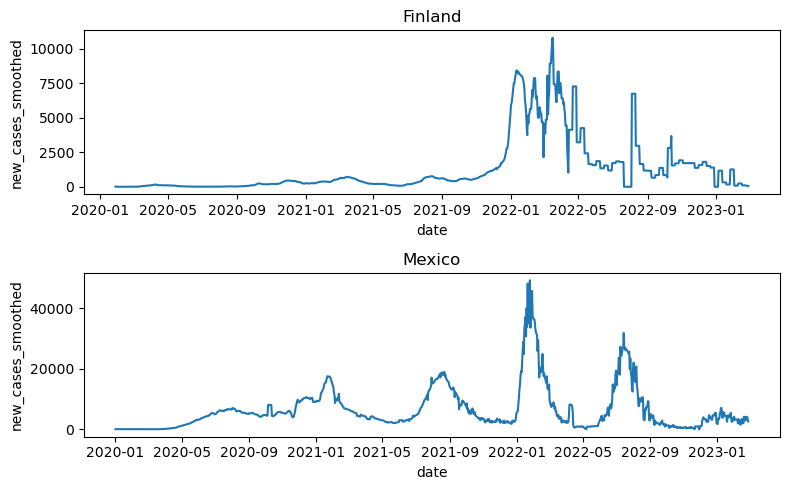

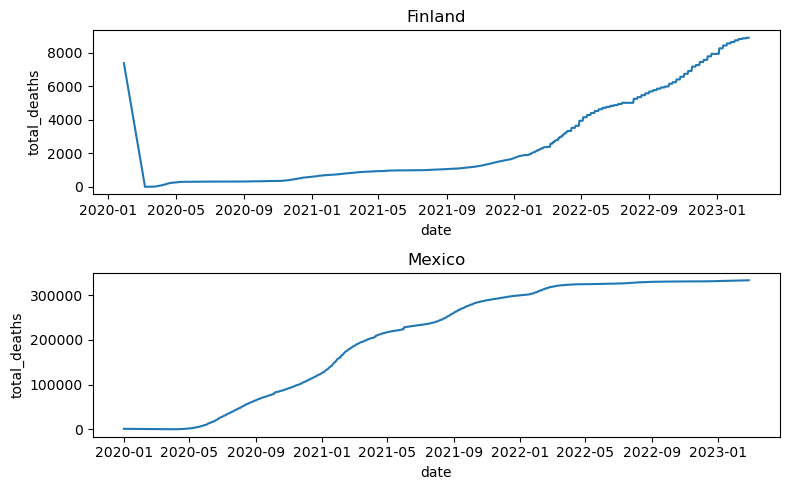

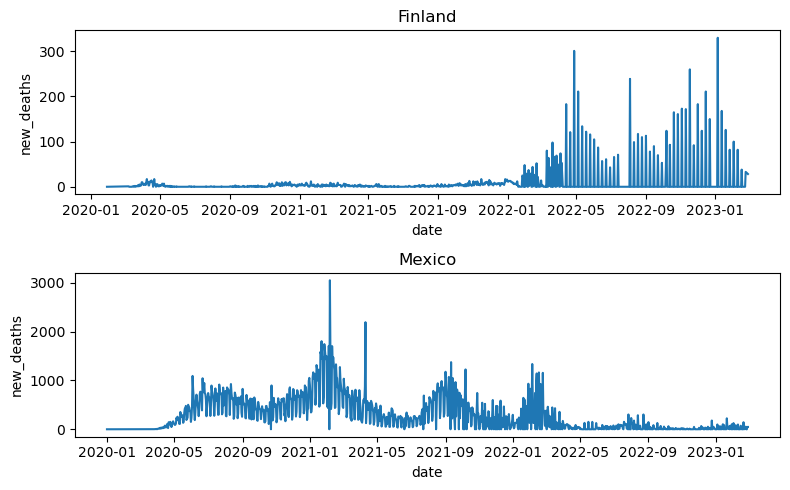

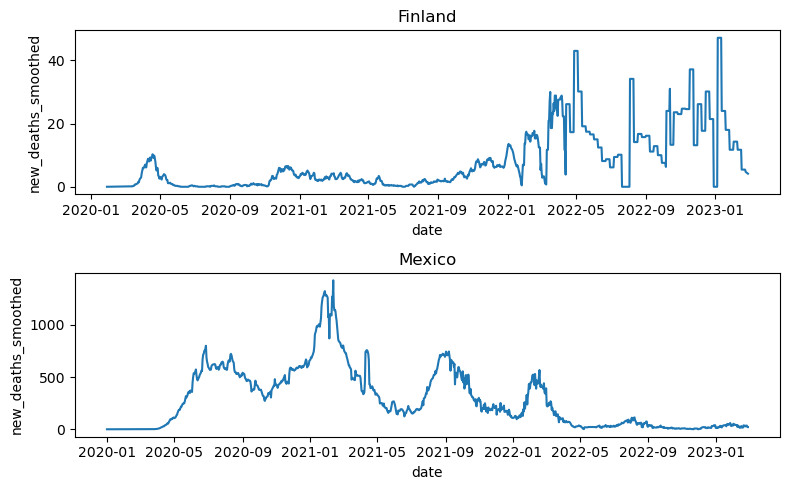

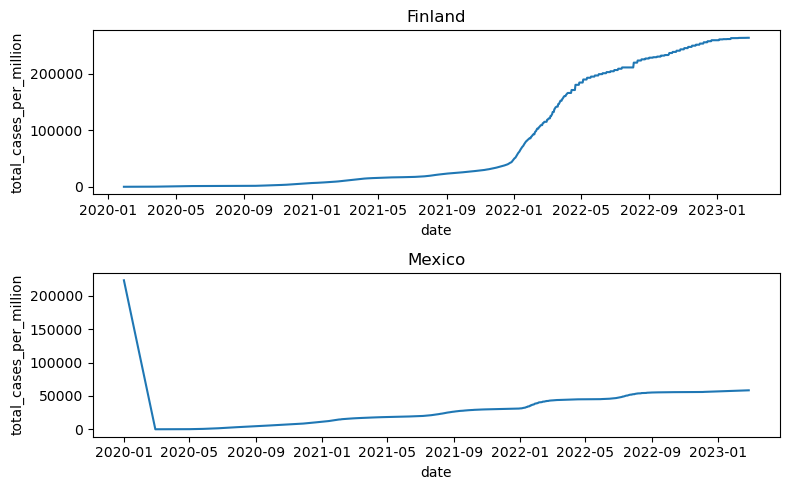

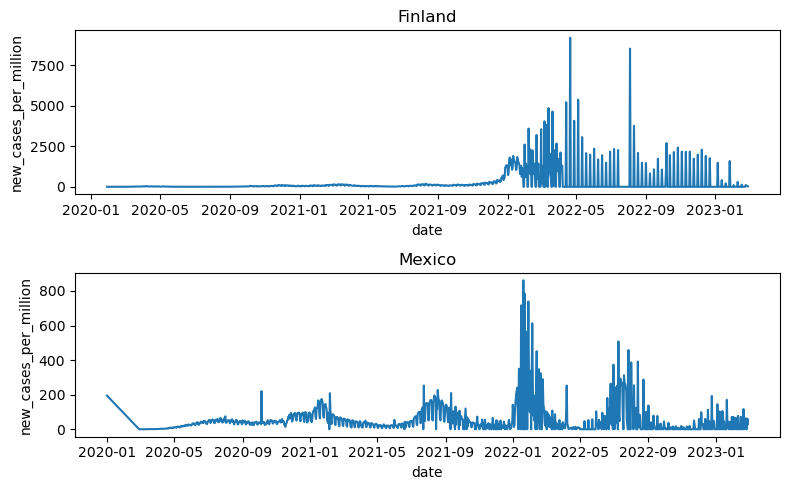

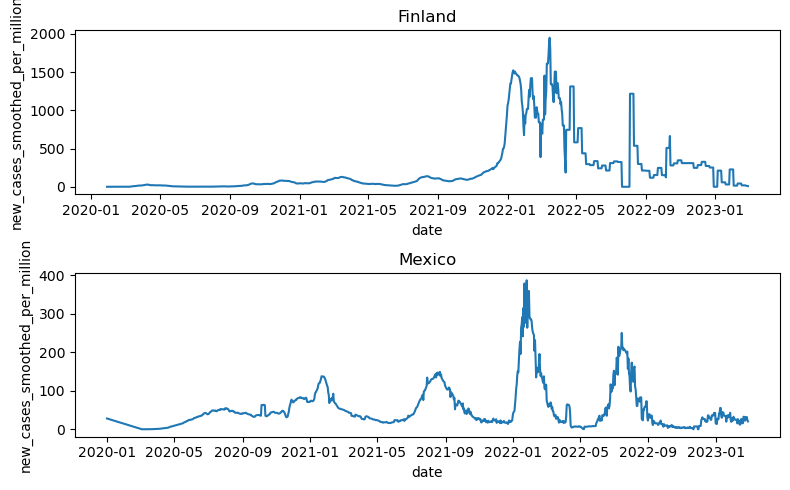

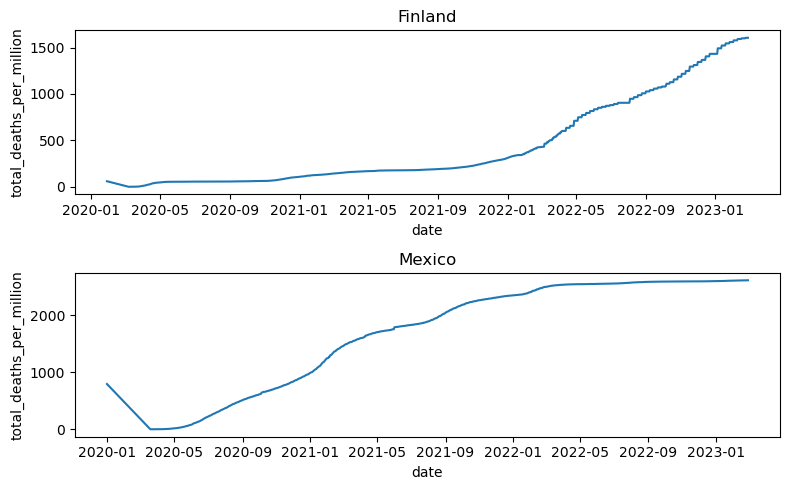

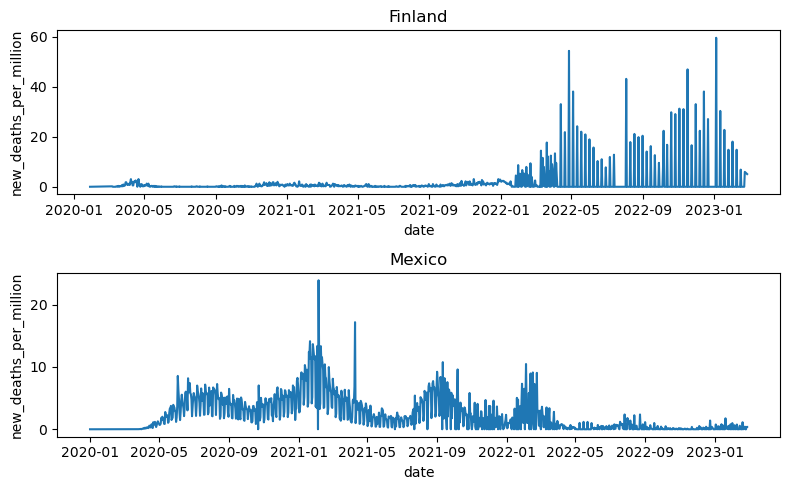

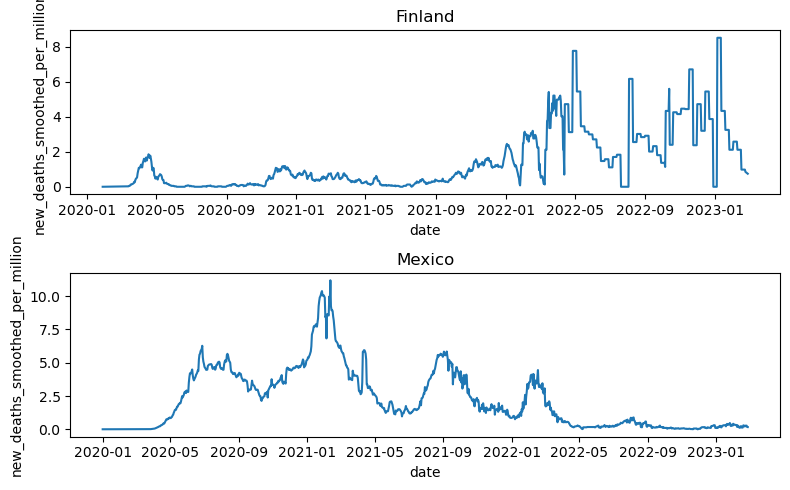

In [134]:
for column in nico_columns_after_second_clean:    
    finland_data_nico = data_clean.groupby("iso_code").get_group("FIN")
    finland_nico = finland_data_nico[column]

    mexico_data_nico = data_clean.groupby("iso_code").get_group("MEX")
    mexico_nico = mexico_data_nico[column]

    fig, axs = plt.subplots(2, 1, figsize=(8, 5))

    # Plot data on each subplot
    axs[0].plot(finland_data_nico["date"], finland_nico)
    axs[0].set_xlabel("date")
    axs[0].set_ylabel(column)
    axs[0].set_title("Finland")

    axs[1].plot(mexico_data_nico["date"], mexico_nico)
    axs[1].set_xlabel("date")
    axs[1].set_ylabel(column)
    axs[1].set_title("Mexico")

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    #safepoint = "../output/Missing_Data_Analysis/cols0-15/missing_data-" + column +"-after_imputation.png"
    #plt.savefig(safepoint)

#### 7.6 Imupations of columns Forin:

In [135]:
#KNN imputations
florin_columns_after_cleaning = ['tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred', 'new_vaccinations_smoothed_per_million', 'new_people_vaccinated_smoothed', 'new_people_vaccinated_smoothed_per_hundred', 'stringency_index']
data_clean = data_clean.interpolate(method='linear', subset=florin_columns_after_cleaning)
knn_imputer = KNNImputer(n_neighbors=5)
data_clean[florin_columns_after_cleaning] = knn_imputer.fit_transform(data_clean[florin_columns_after_cleaning])


In [136]:
#checking how many missing values are left
florin_columns_missing_percentages = data_clean[florin_columns_after_cleaning].isnull().sum() / data_clean.shape[0] *100
print(florin_columns_missing_percentages)

tests_per_case                                0.0
total_vaccinations                            0.0
people_vaccinated                             0.0
people_fully_vaccinated                       0.0
total_boosters                                0.0
new_vaccinations                              0.0
new_vaccinations_smoothed                     0.0
total_vaccinations_per_hundred                0.0
people_vaccinated_per_hundred                 0.0
people_fully_vaccinated_per_hundred           0.0
total_boosters_per_hundred                    0.0
new_vaccinations_smoothed_per_million         0.0
new_people_vaccinated_smoothed                0.0
new_people_vaccinated_smoothed_per_hundred    0.0
stringency_index                              0.0
dtype: float64


#### 7.7 Clean data overview after imputations

Missing percentages:

In [137]:
missing_percentages_after_del_imp = data_clean.isnull().sum() / data_clean.shape[0] *100
print(missing_percentages_after_del_imp)

iso_code                                      0.0
continent                                     0.0
location                                      0.0
date                                          0.0
total_cases                                   0.0
new_cases                                     0.0
new_cases_smoothed                            0.0
total_deaths                                  0.0
new_deaths                                    0.0
new_deaths_smoothed                           0.0
total_cases_per_million                       0.0
new_cases_per_million                         0.0
new_cases_smoothed_per_million                0.0
total_deaths_per_million                      0.0
new_deaths_per_million                        0.0
new_deaths_smoothed_per_million               0.0
reproduction_rate                             0.0
total_tests                                   0.0
total_tests_per_thousand                      0.0
new_tests_smoothed                            0.0


In [138]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173049 entries, 0 to 260566
Data columns (total 52 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    173049 non-null  object        
 1   continent                                   173049 non-null  object        
 2   location                                    173049 non-null  object        
 3   date                                        173049 non-null  datetime64[ns]
 4   total_cases                                 173049 non-null  float64       
 5   new_cases                                   173049 non-null  float64       
 6   new_cases_smoothed                          173049 non-null  float64       
 7   total_deaths                                173049 non-null  float64       
 8   new_deaths                                  173049 non-null  float64       
 9 

In [139]:
data_clean.describe()

date   total_cases     new_cases  new_cases_smoothed  total_deaths     new_deaths  new_deaths_smoothed  total_cases_per_million  new_cases_per_million  new_cases_smoothed_per_million  total_deaths_per_million  new_deaths_per_million  new_deaths_smoothed_per_million  reproduction_rate   total_tests  total_tests_per_thousand  new_tests_smoothed  new_tests_smoothed_per_thousand  positive_rate  tests_per_case  total_vaccinations  people_vaccinated  people_fully_vaccinated  total_boosters  new_vaccinations  new_vaccinations_smoothed  total_vaccinations_per_hundred  people_vaccinated_per_hundred  people_fully_vaccinated_per_hundred  total_boosters_per_hundred  new_vaccinations_smoothed_per_million  new_people_vaccinated_smoothed  new_people_vaccinated_smoothed_per_hundred  stringency_index  population_density     median_age  aged_65_older  aged_70_older  gdp_per_capita  extreme_poverty  cardiovasc_death_rate  diabetes_prevalence  female_smokers  \
count                         173049  1.730490e+05  1.730490e+05       173049.000000  1.730490e+05  173049.000000        173049.000000            173049.000000          173049.000000                   173049.000000             173049.000000           173049.000000                    173049.000000      173049.000000  1.730490e+05             173049.000000        1.730490e+05                    173049.000000  173049.000000    1.730490e+05        1.730490e+05       1.730490e+05             1.730490e+05    1.730490e+05      1.730490e+05               1.730490e+05                   173049.000000                  173049.000000                        173049.000000               173049.000000                          173049.000000                    1.730490e+05                               173049.000000     173049.000000       173049.000000  173049.000000  173049.000000  173049.000000   173049.000000    173049.000000          173049.000000        173049.000000   173049.000000   
mean   2021-08-31 01:46:38.779536128  1.638869e+06  3.598586e+03         3594.429622  2.279901e+04      35.092693            34.957378             68757.164331             153.933409                      153.666629                765.030512                1.374677                         1.262130           0.928961  4.753006e+07                924.353470        1.160665e+05                         2.117106       0.106523    1.529415e+03        4.835742e+07       2.289518e+07             2.082780e+07    1.063833e+07      9.587295e+04               7.795695e+04                       81.956270                      37.383705                            33.865685                   21.437809                            1574.336631                    3.881474e+04                                    0.082063         41.315358          165.954682      30.528048       9.017273       5.692707    18177.966599        14.887253             254.016487             7.669658       11.485878   
min              2020-01-01 00:00:00  1.000000e+00  0.000000e+00            0.000000  1.000000e+00       0.000000             0.000000                 0.001000               0.000000                        0.000000                  0.001000                0.000000                         0.000000          -0.070000  0.000000e+00                  0.000000        0.000000e+00                         0.000000       0.000000    1.000000e+00        0.000000e+00       0.000000e+00             1.000000e+00    1.000000e+00      0.000000e+00               0.000000e+00                        0.000000                       0.000000                             0.000000                    0.000000                               0.000000                    0.000000e+00                                    0.000000          0.000000            1.980000      15.100000       1.144000       0.526000      661.240000         0.100000              79.370000             1.820000        0.100000   
25%              2020-12-02 00:00:00  1.012700e+04  0.000000e+00            9.28

In [140]:
data_clean.shape

(173049, 52)

## 6 Data preprocessing (Handling of missing data excluded) 

### Structure
1. Looking for outliers
2. Distribution of data
3. Splitting the data
4. Scaling

### 1. Looking for outliers

#### 1.1 Looking for outliers using IQR

In [141]:
"""
summary_stats = data_clean.describe()
Q1 = summary_stats.loc['25%']
Q3 = summary_stats.loc['75%']
IQR = Q3 - Q1
# Define outliers using IQR rule
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Align DataFrame columns with summary statistics columns
data_clean, lower_bound = data_clean.align(lower_bound, axis=1, join='inner')
data_clean, upper_bound = data_clean.align(upper_bound, axis=1, join='inner')
outliers = data_clean[(data_clean < lower_bound) | (data_clean > upper_bound)].dropna(axis=1, how='all')
if not outliers.empty:
    print("Outliers:")
    print(outliers)
else:
    print("No outliers found.")
"""

'\nsummary_stats = data_clean.describe()\nQ1 = summary_stats.loc[\'25%\']\nQ3 = summary_stats.loc[\'75%\']\nIQR = Q3 - Q1\n# Define outliers using IQR rule\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n# Align DataFrame columns with summary statistics columns\ndata_clean, lower_bound = data_clean.align(lower_bound, axis=1, join=\'inner\')\ndata_clean, upper_bound = data_clean.align(upper_bound, axis=1, join=\'inner\')\noutliers = data_clean[(data_clean < lower_bound) | (data_clean > upper_bound)].dropna(axis=1, how=\'all\')\nif not outliers.empty:\n    print("Outliers:")\n    print(outliers)\nelse:\n    print("No outliers found.")\n'

#### 1.2 Looking for outliers using the Z-Score

In [142]:
"""
z_scores = (data_clean - data_clean.mean()) / data_clean.std()
outlier_threshold = 3
outliers_zscore = (z_scores > outlier_threshold) | (z_scores < -outlier_threshold)

outliers_rows = outliers_zscore.any(axis=1)  # Rows containing at least one outlier
outliers_cols = outliers_zscore.sum(axis=0) # Amount of outliers per column

print(outliers_cols)
"""

'\nz_scores = (data_clean - data_clean.mean()) / data_clean.std()\noutlier_threshold = 3\noutliers_zscore = (z_scores > outlier_threshold) | (z_scores < -outlier_threshold)\n\noutliers_rows = outliers_zscore.any(axis=1)  # Rows containing at least one outlier\noutliers_cols = outliers_zscore.sum(axis=0) # Amount of outliers per column\n\nprint(outliers_cols)\n'

### 2. Distribution of data 

#### 2.1 Distribution of numercial data

Testing whether the data is normally distributed or not:
Using the anderson darling test, since the shapiro wilks is not suitable for data n > 5000 

In [143]:
num_data_clean = data_clean.select_dtypes(include='number')
distribution_results = {}
for column in num_data_clean.columns:
    result = sts.anderson(num_data_clean[column].dropna(), dist='norm')  ############################### I had to drop all na for it to work!!! -> maybe imputation needed
    test_stat = result.statistic 
    critical_val = result.critical_values
    #print(critical_val)                                
    #print(test_stat)                           
    if test_stat > critical_val[2]:
        result = "not normal"
    else:
        result = "normal"    
    distribution_results[column] = result


not_normal = []
for key, value in distribution_results.items():
    if value == "not normal":
        not_normal.append(key)
if len(not_normal) == 0:
    print("All numerical data seems to be normally distributed.")
elif len(not_normal) == len(num_data_clean.columns):
    print("No variable is normally distributed.")
else:
    print("All data but", not_normal, "seems to be normally distributed")

No variable is normally distributed.


#### Distribution of numercial data visually

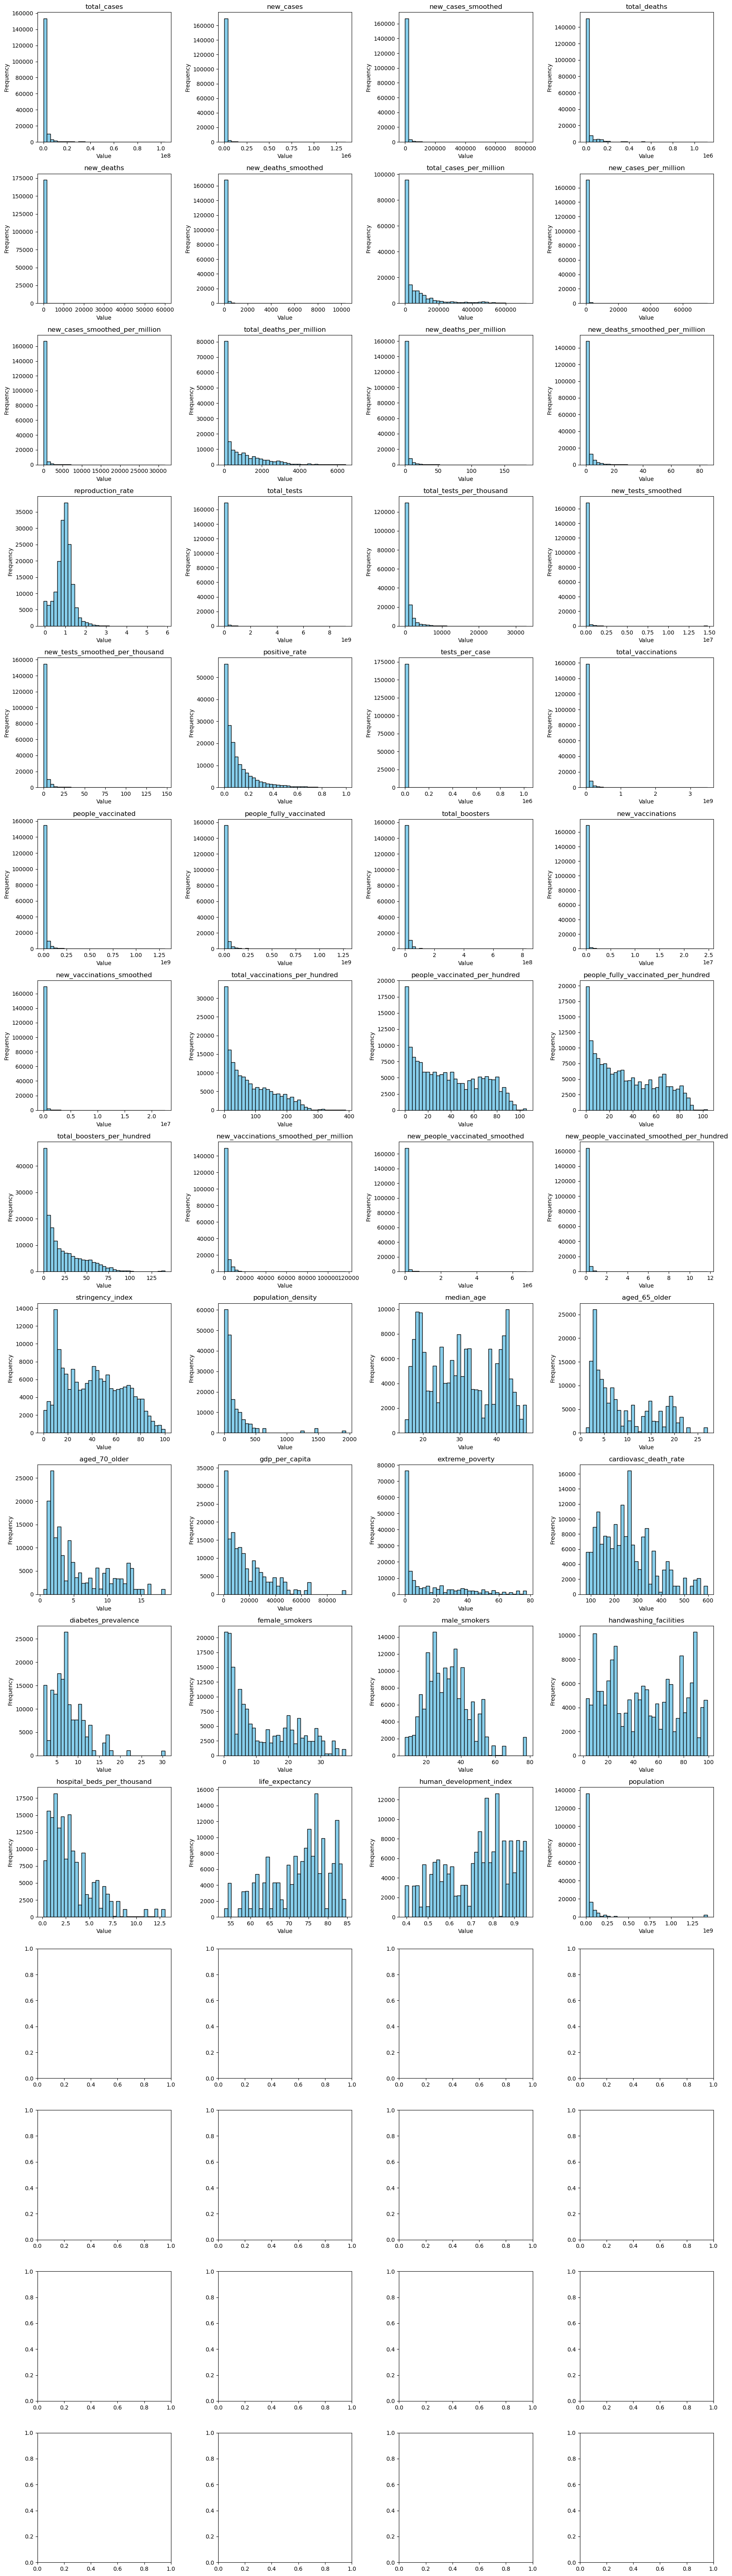

In [144]:
columns_per_row = 3
num_columns = len(num_data_clean.columns)
num_rows = (num_columns - 1) // columns_per_row + 1
fig_width = 6 * columns_per_row
fig_height = 4 * num_rows
fig, axs = plt.subplots(num_rows, 4, figsize=(fig_width, fig_height))
axs = axs.flatten()
for i, column in enumerate(num_data_clean.columns):
    ax = axs[i]
    ax.hist(num_data_clean[column], bins=35, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
plt.tight_layout()
#plt.savefig("../output/Preprocessing/Distributions/distributions_of_variables.png")

### 3. Splitting the data

#### 3.1 Introduction to the split

We want to do a cross validation for multiple time frames of our data. Normal cross validation could lead to data leakage because it takes into account future data to predict past data. Time Series Split makes more sense to me. It works as follows:

Walk-forward validation is similar to time series cross-validation but focuses on predicting one step ahead using all available past data.

**Example:**

*First Fold:*

- Training: January to March

- Validation: April

*Second Fold:*

- Training: January to April

- Validation: May

*Third Fold:*

- Training: January to May

- Validation: June

Trying to find out how many folds to make:

In [145]:
first_day = data_clean["date"].min()
last_day = data_clean["date"].max()
print("Data ranges from", first_day, "to", last_day)

Data ranges from 2020-01-01 00:00:00 to 2023-02-27 00:00:00


#### 3.2 Splitting the data

Splitting the data and saving the splits in a list. I went for a split of the data so that we have train dates for a length of five months and then one test month. 

In [146]:
data_clean_sorted = data_clean.sort_values(by=['date'])
all_dates = pd.Series(data_clean_sorted["date"].unique())

def custom_time_series_split(all_dates, train_window, test_window):
    splits = []
    # Iterate over the DataFrame to create train/test splits
    for i in range(0, len(all_dates), train_window + test_window):
        # Check if there are enough rows remaining for both training and testing data
        if i + train_window + test_window <= len(all_dates):
            # Training data
            train_data = all_dates.iloc[i:i+train_window]

            # Testing data
            test_data = all_dates.iloc[i+train_window:i+train_window+test_window]

            # Store the splits
            splits.append((train_data, test_data))

    return splits

# Create the split
splits = custom_time_series_split(all_dates, 150, 30)


for i, (train_data, test_data) in enumerate(splits):
    print(f"Split {i+1} - Train Data:")
    print(train_data.iloc[0])
    print(train_data.iloc[-1])
    print(f"\nSplit {i+1} - Test Data:")
    print(test_data.iloc[0])
    print(test_data.iloc[-1])
    print("\n----------------------------------------\n")



Split 1 - Train Data:
2020-01-01 00:00:00
2020-05-29 00:00:00

Split 1 - Test Data:
2020-05-30 00:00:00
2020-06-28 00:00:00

----------------------------------------

Split 2 - Train Data:
2020-06-29 00:00:00
2020-11-25 00:00:00

Split 2 - Test Data:
2020-11-26 00:00:00
2020-12-25 00:00:00

----------------------------------------

Split 3 - Train Data:
2020-12-26 00:00:00
2021-05-24 00:00:00

Split 3 - Test Data:
2021-05-25 00:00:00
2021-06-23 00:00:00

----------------------------------------

Split 4 - Train Data:
2021-06-24 00:00:00
2021-11-20 00:00:00

Split 4 - Test Data:
2021-11-21 00:00:00
2021-12-20 00:00:00

----------------------------------------

Split 5 - Train Data:
2021-12-21 00:00:00
2022-05-19 00:00:00

Split 5 - Test Data:
2022-05-20 00:00:00
2022-06-18 00:00:00

----------------------------------------

Split 6 - Train Data:
2022-06-19 00:00:00
2022-11-15 00:00:00

Split 6 - Test Data:
2022-11-16 00:00:00
2022-12-15 00:00:00

----------------------------------------

This creates 6 splits. As one can see, all of 2023 is not included which makes sense, since at the end we had to do most imputations and thus this will be more accurate.

Splitting the whole data accordingly:

In [147]:
train_data_list = []
test_data_list = []

# Iterate over each split
for i, (train_dates, test_dates) in enumerate(splits):
    # Filter the original DataFrame based on the train and test dates
    train_data = data_clean[data_clean['date'].isin(train_dates)]
    test_data = data_clean[data_clean['date'].isin(test_dates)]
    
    # Append train and test dataframes to respective lists
    train_data_list.append(train_data)
    test_data_list.append(test_data)


for i in range(len(train_data_list)):
    print("Split:", i+1, ":")
    print("Train Data:")
    print(train_data_list[i].head())  
    print("\nTest Data:")
    print(test_data_list[i].head()) 
    print("------------------------------------------------------------------------------------------------------------------------")


Split: 1 :
Train Data:
  iso_code continent     location       date  total_cases  new_cases  new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  total_cases_per_million  new_cases_per_million  new_cases_smoothed_per_million  total_deaths_per_million  new_deaths_per_million  new_deaths_smoothed_per_million  reproduction_rate   total_tests  total_tests_per_thousand  new_tests_smoothed  new_tests_smoothed_per_thousand  positive_rate  tests_per_case  total_vaccinations  people_vaccinated  people_fully_vaccinated  total_boosters  new_vaccinations  new_vaccinations_smoothed  total_vaccinations_per_hundred  people_vaccinated_per_hundred  people_fully_vaccinated_per_hundred  total_boosters_per_hundred  new_vaccinations_smoothed_per_million  new_people_vaccinated_smoothed  new_people_vaccinated_smoothed_per_hundred  stringency_index  population_density  median_age  aged_65_older  aged_70_older  gdp_per_capita  extreme_poverty  cardiovasc_death_rate  diabetes_prevalence  female_sm

This now gives us two lists with data frames in them. train_data_list has the six data frames with the training data and test_data_list contain the six data frames where we can use our models. 

### 4. Scaling

#### 3.1 Finding numerical features

Removing the first 4 columns. Checking for non numeric features in the rest of the columns and deleting those to perform Normalization and Standardization:

In [148]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#figuring out the numerical features which have to be scaled... Removing the first 4 columns
numerical_features = data_clean.columns[4:len(data_clean.columns)]

#check for non numeric columns:
non_numeric_columns = []
for col in numerical_features:
    if data_clean[col].dtype not in ['int64', 'float64']:
        non_numeric_columns.append(col)

# Had to remove the non numeric columns for the Scalers to work... Only column "tests_units"... Maybe we can do something else than delete
numerical_features = [col for col in numerical_features if col not in non_numeric_columns]

#### 3.2 Normalization

Scaling each split:

In [149]:
death_columns = [col for col in data_clean.columns if 'deaths' in col]
feature_names = data_clean.drop(columns=['iso_code', 'continent', 'location', 'date'] + death_columns).select_dtypes(include=[np.number]).columns

scaled_train_sets = []
scaled_test_sets = []
true_y_values = []   # This list will contain the actual results! Needed for evaluation etc.

for i, (train_dates, test_dates) in enumerate(splits):
    # Filter the original DataFrame based on the train and test dates
    train_data = data_clean[data_clean['date'].isin(train_dates)]
    test_data = data_clean[data_clean['date'].isin(test_dates)]

    # Extract features and target for train data
    X_train = train_data.drop(columns = ['iso_code', 'continent', 'location', 'date'] + death_columns) 
    # had to also remove so that the model can easily just look at the other death variables to make good predictions
    y_train = train_data['new_deaths']
    y_test = test_data['new_deaths']
    # Extract features for test data, but without label columns
    X_test = test_data.drop(columns = ['iso_code', 'continent', 'location', 'date'] + death_columns)
    
    # Initialize and fit the scaler on the training data
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Append the scaled arrays to respective lists
    scaled_train_sets.append((X_train_scaled, y_train))
    scaled_test_sets.append(X_test_scaled)
    true_y_values.append(y_test)
    
    print(f"scaled train array for Split {i+1}:")
    print(scaled_train_sets[i])
    print(f"scaled test array for Split {i+1}:")
    print(scaled_test_sets[i])
    print("----------------------------------------")



scaled train array for Split 1:
(array([[-0.10062734, -0.04854369, -0.12681435, ..., -1.13695652,
        -1.04313725,  0.77317459],
       [-0.10062734, -0.09708738, -0.12681435, ..., -1.13695652,
        -1.04313725,  0.77317459],
       [-0.10062734, -0.09708738, -0.12681435, ..., -1.13695652,
        -1.04313725,  0.77317459],
       ...,
       [-0.06843673,  0.6407767 , -0.01549548, ..., -1.5       ,
        -0.80784314,  0.10957582],
       [-0.06412775,  0.06796117,  0.00423142, ..., -1.5       ,
        -0.80784314,  0.10957582],
       [-0.06412775, -0.09708738,  0.00423142, ..., -1.5       ,
        -0.80784314,  0.10957582]]), 0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
259558    0.0
259559    0.0
259560    0.0
259561    0.0
259562    0.0
Name: new_deaths, Length: 14026, dtype: float64)
scaled test array for Split 1:
[[ 3.58076168  7.51456311  6.3154277  ... -1.13695652 -1.04313725
   0.77317459]
 [ 3.74577023  6.22330097  6.22383572 

We now have 6 scaled splits saved in the lists scaled_train_sets and scaled_test_sets. The list true_y_values contains the label values we will try to predict. Those values will be needed to evaluate performance.

In [150]:
"""
#normalizing the cleaned data with MinMaxScaler (assuming there are no/few outliers)
#scaler_minmax = MinMaxScaler()
#data_clean_normalized_minmax = data_clean.copy()
#data_clean_normalized_minmax[numerical_features] = scaler_minmax.fit_transform(data_clean[numerical_features])
#print(data_clean_normalized_minmax)
data_clean_numerical = data_clean[numerical_features]
#normalizing the cleaned data with RobustScaler (assuming there are outliers)
scaler_robust = RobustScaler()
data_clean_normalized_robust = data_clean.copy()
data_clean_normalized_robust[numerical_features] = scaler_robust.fit_transform(data_clean_numerical)
"""

'\n#normalizing the cleaned data with MinMaxScaler (assuming there are no/few outliers)\n#scaler_minmax = MinMaxScaler()\n#data_clean_normalized_minmax = data_clean.copy()\n#data_clean_normalized_minmax[numerical_features] = scaler_minmax.fit_transform(data_clean[numerical_features])\n#print(data_clean_normalized_minmax)\ndata_clean_numerical = data_clean[numerical_features]\n#normalizing the cleaned data with RobustScaler (assuming there are outliers)\nscaler_robust = RobustScaler()\ndata_clean_normalized_robust = data_clean.copy()\ndata_clean_normalized_robust[numerical_features] = scaler_robust.fit_transform(data_clean_numerical)\n'

#### 3.3 Standardization

In [151]:
scaler_standard = StandardScaler()
data_clean_standardized = data_clean.copy()
data_clean_standardized[numerical_features] = scaler_standard.fit_transform(data_clean[numerical_features])
#print(data_clean_standardized)

## 7 Machine Learning Models 

### Structure
1. Model Selection
2. Actual Models
3. Model Evaluation

### 1 Model Selection


Total Deaths and Total Cases are both numerical values, therefore mainly regression is suitable, regression models that could be implemented are:

1) **traditional linear regression (lasso/ridge)**

- *Simplicity and Interpretability*: These models are straightforward to implement and interpret, making it easy to understand the relationship between predictors and the target variables.

- *Handling Multicollinearity*: Lasso and Ridge can manage multicollinearity among features, improving the model's stability and performance.
    
- *Feature Selection*: Lasso performs automatic feature selection by shrinking some coefficients to zero, helping identify the most significant predictors.

2) **random forest regression**

- *Non-Linear Relationships:* This model captures complex non-linear interactions between features, which is crucial for accurately modeling real-world phenomena like the spread of a virus.

- *Robustness and Generalization:* By averaging the predictions of multiple decision trees, Random Forests reduce overfitting and provide robust predictions.

- *Feature Importance:* It offers insights into feature importance, helping to understand which factors most influence total cases and deaths.

3) **support vector regression**

- *Handling Non-Linearities:* SVR can model complex relationships using various kernels, making it suitable for datasets with non-linear patterns.

- *Margin Maximization:* It focuses on minimizing prediction error within a margin, providing a balance between accuracy and generalization.

- *Effective in High-Dimensional Spaces:* SVR performs well with high-dimensional data, which can be beneficial when dealing with multiple predictors for total deaths and total cases.

#### 1.2 Scenarios

1) Traditional Regression Analysis

- Use multiple linear regression or other suitable regression techniques.

- Examine the relationship between total_cases/total_deaths and various predictors like:

    -stringency index

    -vaccination rates

    -demographic factors

    -regionality

2) Short-Term Predictions

- Use time-series forecasting techniques such as ARIMA, Prophet, or other regression-based forecasting models.

- Make short-term predictions for total_cases and total_deaths by cutting out recent time periods.

3) Classification possible?

- Only 'continent' as viable option

- logistic regression, random forest, SVM, KNN



### 2 Actual Models

#### 2.1 "Model name" (Florin)

#### 2.2 Random Forest Regression (Sevi)

##### 2.2.1 Regular Model

Summary for Split 1:
Mean Squared Error for Split 1: 6804.071443930136
R^2 Score for Split 1: 0.2957099513195346
Top 5 Important Features:
                   Feature  Importance
1                new_cases    0.476622
2       new_cases_smoothed    0.333009
33   cardiovasc_death_rate    0.103724
14       people_vaccinated    0.012288
37  handwashing_facilities    0.010183
----------------------------------------
Summary for Split 2:
Mean Squared Error for Split 2: 8577.025493694706
R^2 Score for Split 2: 0.8366303418532747
Top 5 Important Features:
                  Feature  Importance
2      new_cases_smoothed    0.712524
1               new_cases    0.063370
11          positive_rate    0.033559
0             total_cases    0.019378
4   new_cases_per_million    0.014191
----------------------------------------
Summary for Split 3:
Mean Squared Error for Split 3: 7318.856462323613
R^2 Score for Split 3: 0.8730237421924831
Top 5 Important Features:
                   Feature  Importance


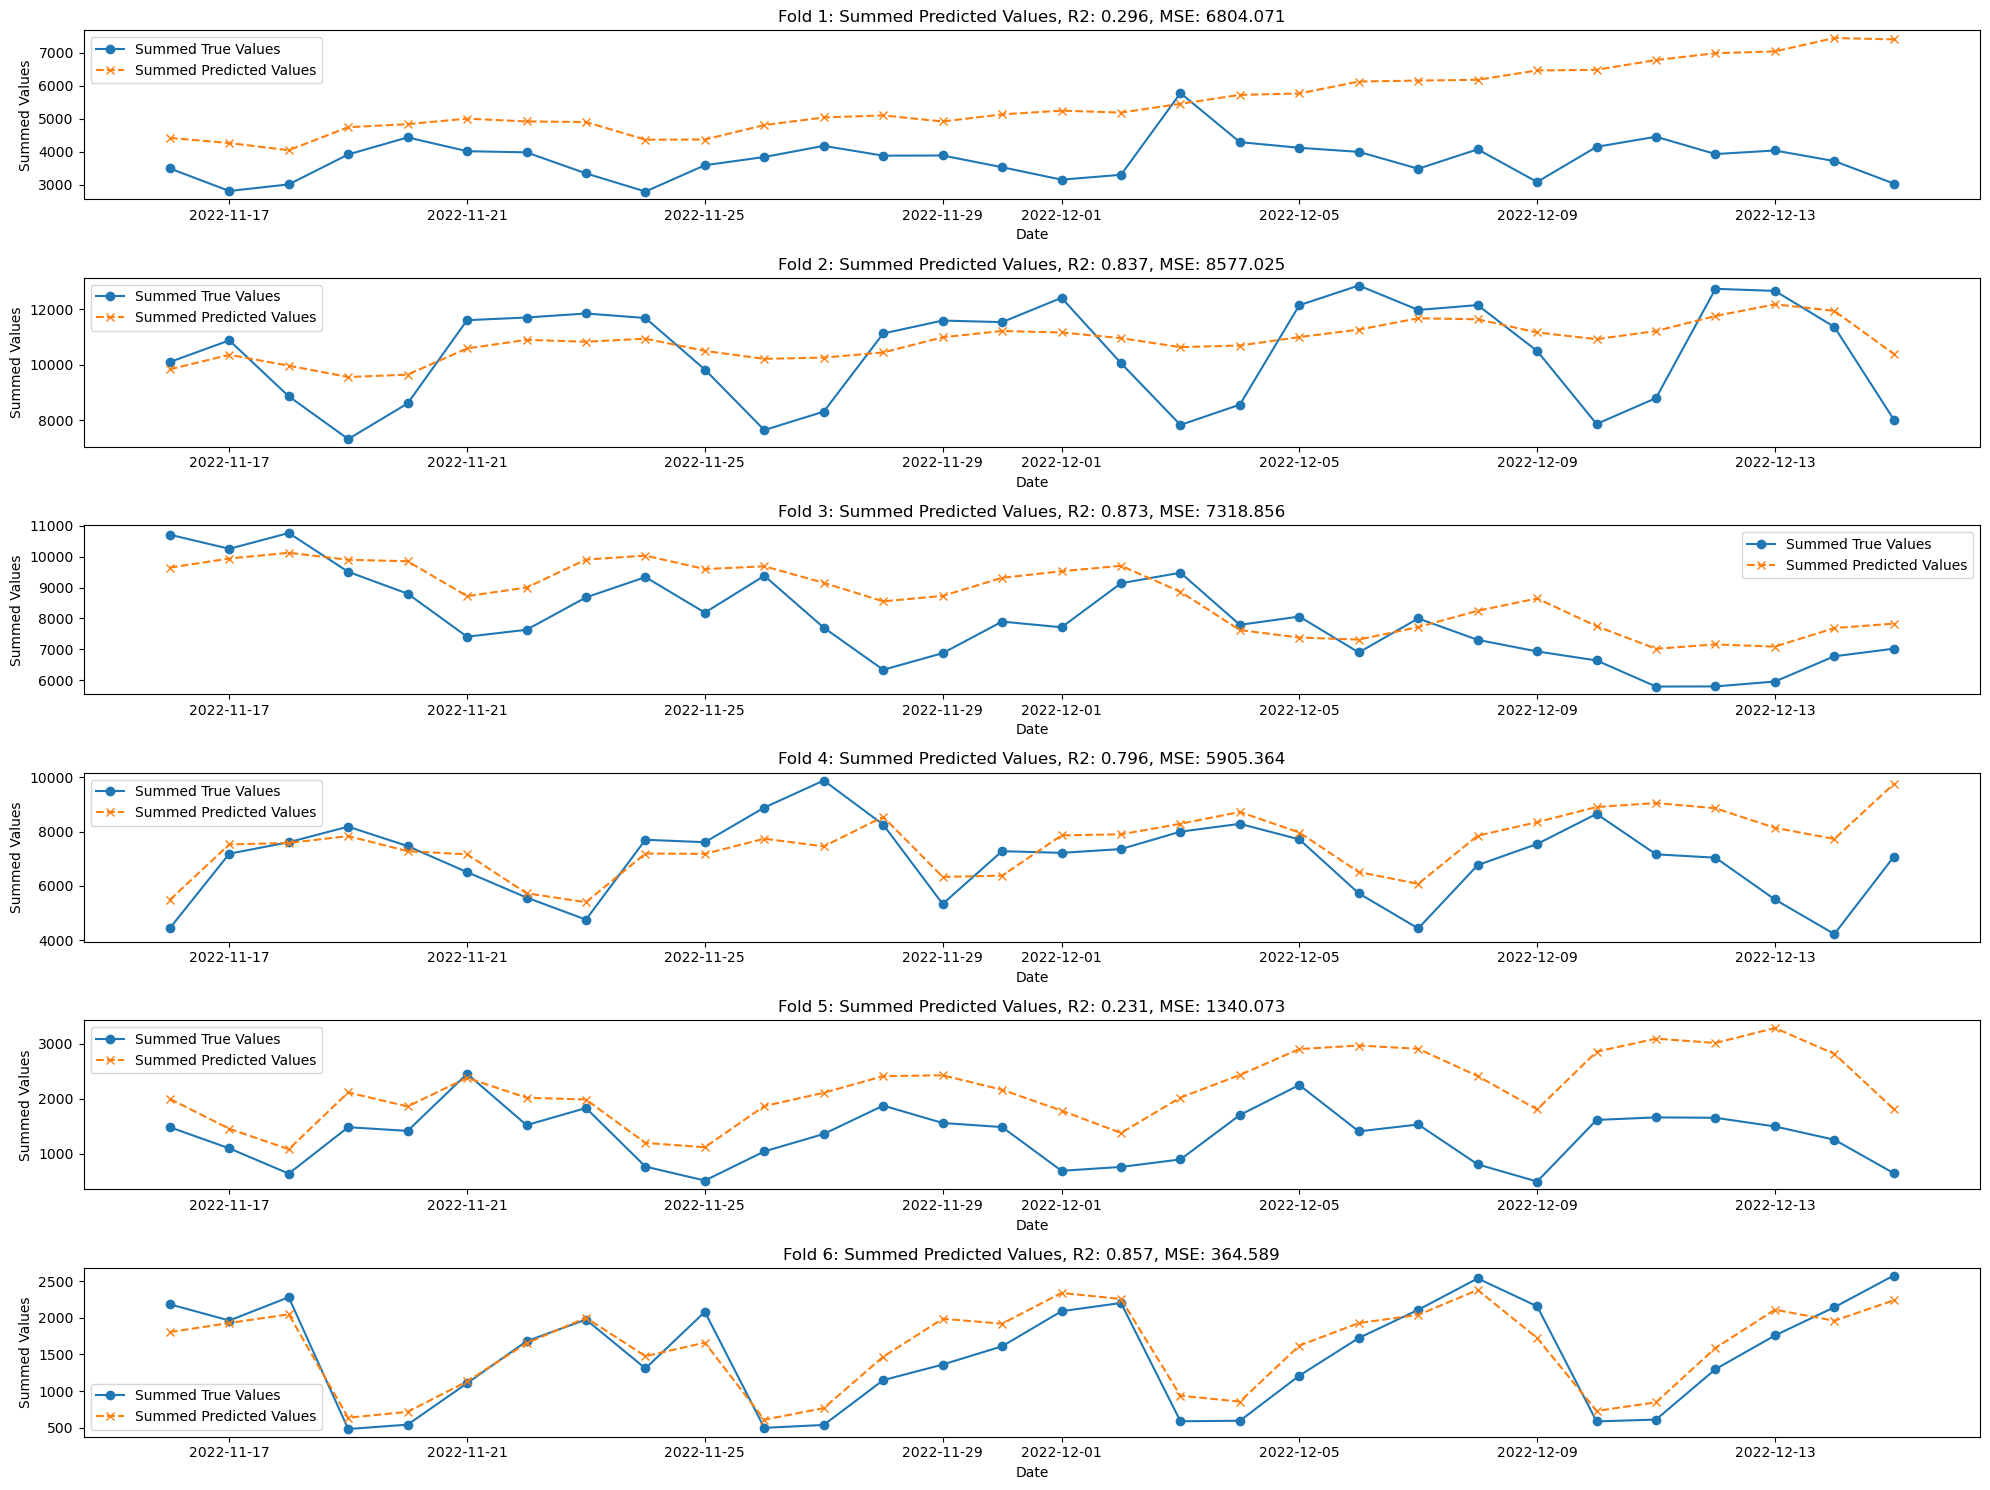

In [152]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

mse_list=[]
r2_list=[]
feature_importances_list = []
fig, axs = plt.subplots(6, 1, figsize=(20, 15))    
for i, (X_train_scaled, y_train) in enumerate(scaled_train_sets):
    X_test_scaled = scaled_test_sets[i]
    y_test = true_y_values[i]

    model = RandomForestRegressor(n_estimators=100, random_state=42)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_list.append(mse)
    r2_list.append(r2)

    predicted_sums = {}
    true_sums={}
    for date, pred, true in zip(test_data['date'], y_pred, y_test):
        if date in predicted_sums:
            predicted_sums[date] += pred
        else:
            predicted_sums[date] = pred
    
        if date in true_sums:
            true_sums[date] += true
        else:
            true_sums[date] = true
    # Sort dates for plotting
    sorted_dates = sorted(predicted_sums.keys())
    summed_predicted_values = [predicted_sums[date] for date in sorted_dates]
    summed_true_values = [true_sums[date] for date in sorted_dates]


    axs[i].plot(sorted_dates, summed_true_values, marker='o', linestyle='-', label='Summed True Values')
    axs[i].plot(sorted_dates, summed_predicted_values, marker='x', linestyle='--', label='Summed Predicted Values')
    axs[i].set_title(f"Fold {i + 1}: Summed Predicted Values, R2: {round(r2,3)}, MSE: {round(mse,3)}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Summed Values")
    axs[i].legend()

    importances = model.feature_importances_
    feature_importances_list.append(importances)
    feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
    })
    top_5_features = feature_importances.sort_values(by='Importance', ascending=False).head(5)

    # Print the summary of the model for the current split
    print(f"Summary for Split {i + 1}:")
    print(f"Mean Squared Error for Split {i + 1}: {mse}")
    print(f"R^2 Score for Split {i + 1}: {r2}")
    print("Top 5 Important Features:")
    print(top_5_features)
    print("----------------------------------------")



plt.tight_layout()
plt.savefig("../output/Models/ForestSeverin.png")
print("Overall Mean Squared Error:", np.mean(mse_list))
print("Overall R^2 Score:", np.mean(r2_list))

mean_importances = np.mean(feature_importances_list, axis=0)
overall_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importances
})
top_10_features_overall = overall_feature_importances.sort_values(by='Importance', ascending=False).head(10)
print("Top 10 Important Features Overall:")
print(top_10_features_overall)

1) **Mean Squared Error (MSE):**

- The MSE values range from **364.59 to 8577.03**, with an overall mean of **5051.66**.
- Lower MSE values (e.g., 364.59 in Split 6) indicate closer predictions to actual values compared to higher MSE values (e.g., 8577.03 in Split 2).

2) **R² Score:**

- The R² values range from **0.231 to 0.873**, with an overall mean of **0.648**.
- Higher R² scores (e.g., 0.873 in Split 3) indicate better explanation of variance in the data compared to lower scores (e.g., 0.231 in Split 5).

3) **Feature Importance:**

- **new_cases_smoothed**, **new_cases**, and **total_cases** consistently appear as important features across multiple folds and overall, indicating these features are highly influential in predicting the target variable.

4) **Overall Interpretation:**

- The mean MSE of 5051.66 indicates **moderate average squared differences** between predicted and actual values.
- The overall R² score of 0.648 suggests the model explains 64.8% of the variance in the target variable, demonstrating a **moderate predictive performance**.


-> new deaths smoothed?

##### 2.2.2 HP Tuned Model


Due to extensively long run-time I commented out the model.

The tuned model would be expected to have lower Mean Squared Error (MSE) and higher R-squared (R²) scores compared to the one using default hyperparameters.

In [153]:
"""
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


your_country = "CHE"
specific_country = data_clean
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

mse_list=[]
r2_list=[]
fig, axs = plt.subplots(6, 1, figsize=(20, 15))    
for i, (train_dates,test_dates) in enumerate(splits):
    train_data = specific_country[specific_country['date'].isin(train_dates)]
    test_data = specific_country[specific_country['date'].isin(test_dates)]
    
    y_train = train_data['new_deaths'].values
    y_test = test_data['new_deaths'].values

    X_train = train_data.drop(columns=['iso_code', 'continent', 'location', 'date', 'new_deaths']).select_dtypes(include=[np.number]).values
    X_test = test_data.drop(columns=['iso_code', 'continent', 'location', 'date', 'new_deaths']).select_dtypes(include=[np.number]).values

    model = RandomForestRegressor(n_estimators=100, random_state=42)

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)


    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_list.append(mse)
    r2_list.append(r2)

    predicted_sums = {}
    true_sums={}
    for date, pred, true in zip(test_data['date'], y_pred, y_test):
        if date in predicted_sums:
            predicted_sums[date] += pred
        else:
            predicted_sums[date] = pred
    
        if date in true_sums:
            true_sums[date] += true
        else:
            true_sums[date] = true
    # Sort dates for plotting
    sorted_dates = sorted(predicted_sums.keys())
    summed_predicted_values = [predicted_sums[date] for date in sorted_dates]
    summed_true_values = [true_sums[date] for date in sorted_dates]


    axs[i].plot(sorted_dates, summed_true_values, marker='o', linestyle='-', label='Summed True Values')
    axs[i].plot(sorted_dates, summed_predicted_values, marker='x', linestyle='--', label='Summed Predicted Values')
    axs[i].set_title(f"Fold {i + 1}: Summed Predicted Values, R2: {round(r2,3)}, MSE: {round(mse,3)}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Summed Values")
    axs[i].legend()
    
    # Print the summary of the model for the current split
    print(f"Summary for Split {i + 1}:")
    print(f"Mean Squared Error for Split {i + 1}: {mse}")
    print(f"R^2 Score for Split {i + 1}: {r2}")
    print("----------------------------------------")
plt.tight_layout()
plt.savefig("../output/Models/ForestSeverinGS.png")
print("Overall Mean Squared Error:", np.mean(mse_list))
print("Overall R^2 Score:", np.mean(r2_list))
"""


'\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom sklearn.model_selection import GridSearchCV\n\n\nyour_country = "CHE"\nspecific_country = data_clean\nparam_grid = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [10, 20, None],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\n\nmse_list=[]\nr2_list=[]\nfig, axs = plt.subplots(6, 1, figsize=(20, 15))    \nfor i, (train_dates,test_dates) in enumerate(splits):\n    train_data = specific_country[specific_country[\'date\'].isin(train_dates)]\n    test_data = specific_country[specific_country[\'date\'].isin(test_dates)]\n    \n    y_train = train_data[\'new_deaths\'].values\n    y_test = test_data[\'new_deaths\'].values\n\n    X_train = train_data.drop(columns=[\'iso_code\', \'continent\', \'location\', \'date\', \'new_deaths\']).select_dtypes(include=[np.number]).values\n    X_test = test_data.drop(columns=[\'iso_code\', \'conti

#### 2.3 "Model name" (Nico)

#### 2.4 "Model name" (Leon)

I am trying to use the ARIMA model. It does not need to be scaled before using it.

'\nfirst_split_evaluation = evaluations[0]\nprint("Evaluation for the first split:")\nprint("True values:\n", first_split_evaluation[\'y_true\'])\nprint("Predicted values:\n", first_split_evaluation[\'y_pred\'])\nprint("Mean Squared Error:\n", first_split_evaluation[\'mse\'])\n'

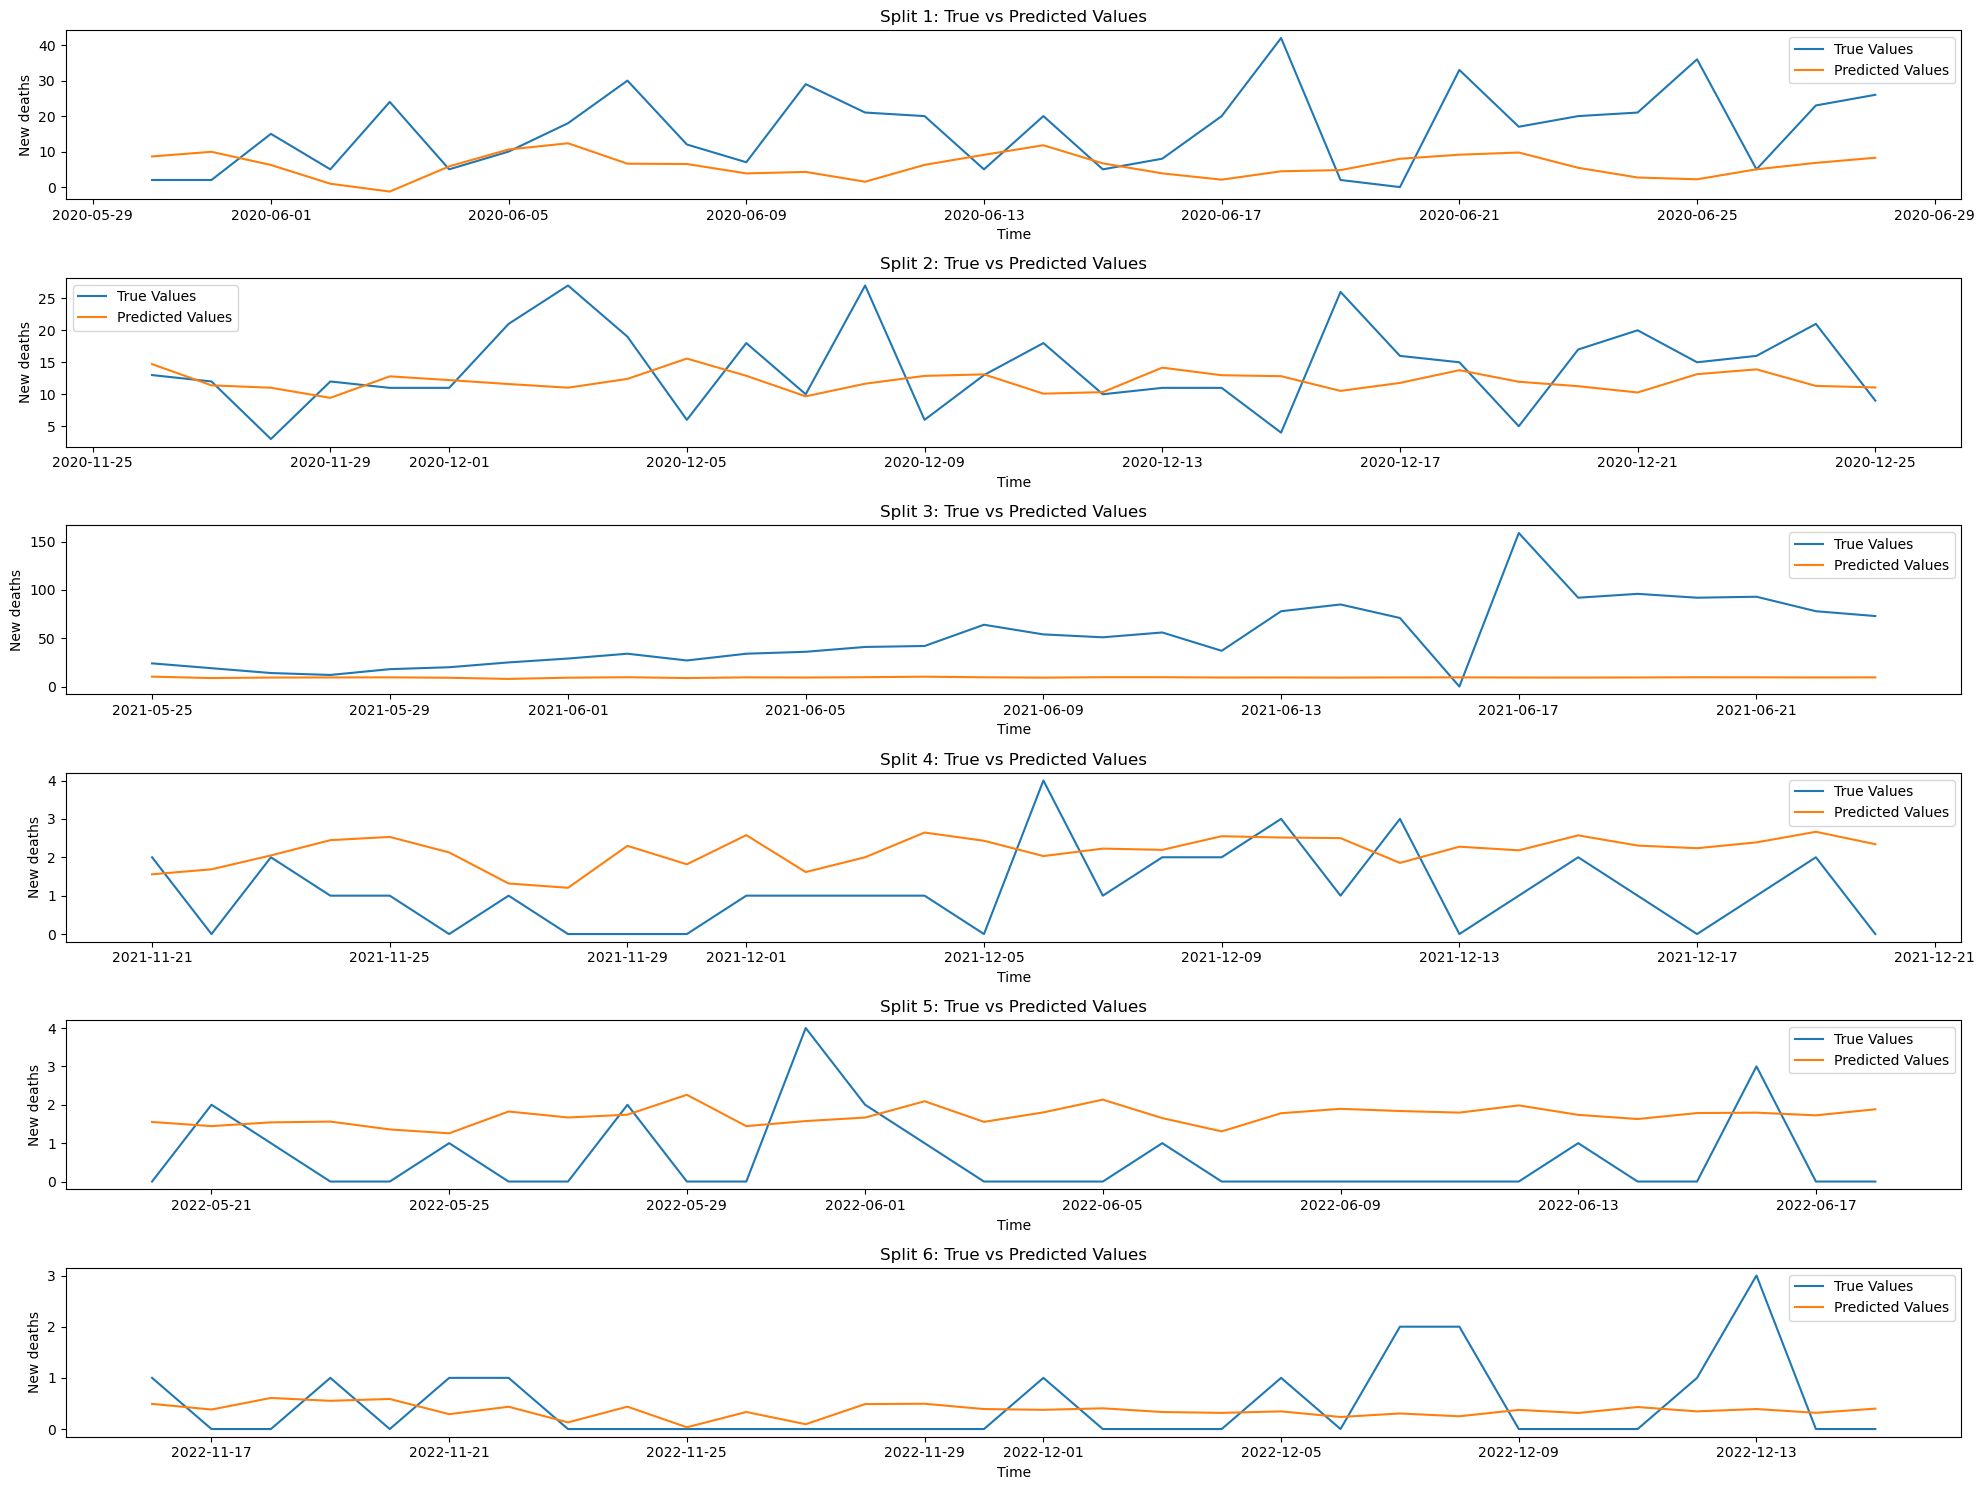

In [154]:
your_country = "AFG"
specific_country = data_clean[data_clean['iso_code'] == your_country]

model_results = []
evaluations = []
fig, axs = plt.subplots(6, 1, figsize=(20, 15))
for i, (train_dates, test_dates) in enumerate(splits):
    # Filter the original DataFrame based on the train and test dates
    train_data = specific_country[specific_country['date'].isin(train_dates)]
    test_data = specific_country[specific_country['date'].isin(test_dates)]
    
    # Extract the target variable for deaths (new_deaths) for ARIMA
    y_train = train_data['new_deaths'].values
    y_test = test_data['new_deaths'].values
    
    """
    # Check for stationarity
    adf_result = adfuller(y_train)
    p_value = adf_result[1]
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {p_value}")
    
    # Differencing if data is not stationary
    if p_value > 0.05:
        y_train = np.diff(y_train, n=1)
        y_test = np.diff(y_test, n=1)
    """
    # Fit the ARIMA model
    model = ARIMA(y_train, order=(20, 1, 0))
    result = model.fit()
    
    # Store the result
    model_results.append(result)
    
    # Make predictions on the test set
    y_pred = result.forecast(steps=len(y_test))
    
    """
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    evaluation = {
        'split': i + 1,
        'test_dates': test_dates,
        'y_true': y_test,
        'y_pred': y_pred,
        'mse': mse
    }
    evaluations.append(evaluation)
    """

    axs[i].plot(specific_country[specific_country["date"].isin(test_dates)]["date"], y_test,  label='True Values')
    axs[i].plot(specific_country[specific_country["date"].isin(test_dates)]["date"], y_pred, label='Predicted Values')
    axs[i].set_title(f"Split {i + 1}: True vs Predicted Values")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("New deaths")
    axs[i].legend()
    
    """
    # Print the summary of the model for the current split
    print(f"Summary for Split {i + 1}:")
    print(result.summary())
    print(f"Mean Squared Error for Split {i + 1}: {mse}")
    print("----------------------------------------")
    """
plt.tight_layout()
plt.savefig("../output/Models/LeonsArima.png")
# Example: Accessing the evaluation for the first split
"""
first_split_evaluation = evaluations[0]
print("Evaluation for the first split:")
print("True values:\n", first_split_evaluation['y_true'])
print("Predicted values:\n", first_split_evaluation['y_pred'])
print("Mean Squared Error:\n", first_split_evaluation['mse'])
"""

### 3 Model Evaluation